In [5]:
# Stock Price Prediction - Feature Analysis for RNN Sequence Selection
# Analyzing features to determine optimal sequence length for LSTM/GRU models
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("="*80)
print("STOCK PRICE PREDICTION - FEATURE ANALYSIS")
print("="*80)
print("\nObjective: Determine optimal sequence length for RNN input")
print("Target: Predict if close price > current price after 30 trading days")
print("="*80)

STOCK PRICE PREDICTION - FEATURE ANALYSIS

Objective: Determine optimal sequence length for RNN input
Target: Predict if close price > current price after 30 trading days


In [6]:

# ============================================================================
# SECTION 1: DATA LOADING AND INITIAL PREPROCESSING
# ============================================================================

print("\n[1] LOADING DATA...")
# Load the dataset
df = pd.read_csv('../data/interim/train_clean_after_2010_and_bad_tickers.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df = df[df['open'] != 0]

# Sort by ticker and date
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f"Total records: {len(df):,}")
print(f"Unique tickers: {df['ticker'].nunique():,}")
print(f"date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic statistics
print("\n" + "="*80)
print("DATA OVERVIEW")
print("="*80)
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())


[1] LOADING DATA...
Total records: 12,269,060
Unique tickers: 4,925
date range: 2010-01-04 00:00:00 to 2024-09-23 00:00:00

Memory usage: 1552.30 MB

DATA OVERVIEW
     ticker       date       open       high        low      close     volume  \
0  ticker_1 2010-01-04  27.875437  28.009543  27.570655  27.662090  2142300.0   
1  ticker_1 2010-01-05  27.729151  27.814489  27.131774  27.302454  2856000.0   
2  ticker_1 2010-01-06  27.278065  27.729145  27.278065  27.595039  2035400.0   
3  ticker_1 2010-01-07  27.637703  27.643798  27.375590  27.497503  1993400.0   
4  ticker_1 2010-01-08  27.424356  27.613320  27.253676  27.582842  1306400.0   

   dividends  stock_splits    return  return_is_outlier  
0        0.0           0.0       NaN              False  
1        0.0           0.0 -0.013001              False  
2        0.0           0.0  0.010716              False  
3        0.0           0.0 -0.003535              False  
4        0.0           0.0  0.003104              False  


In [7]:
def find_unset_values(df):
    result = {}

    result['null'] = df['open'].isnull().sum()
    result['zeros'] = (df['open'] == 0).sum()
    result['infinite'] = np.isinf(df['open']).sum()
    return pd.DataFrame([result])

find_unset_values(df)

null  zeros  infinite
0     0      0         0

In [8]:
# ============================================================================
# SECTION 2: FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("[2] ENGINEERING FEATURES...")
print("="*80)

def engineer_features(df):
    """
    Create optimized features combining:
    1. Previously validated features (28 features)
    2. New high-performing features from research paper (15 selected features)

    Total: 43 high-quality features

    Selection criteria for new features:
    - High Mutual Information (MI > 0.008)
    - Good stability (Avg_Mean_Stability < 15)
    - Meaningful correlation with target

    Returns: DataFrame with all engineered features
    """
    df = df.copy()
    df = df.sort_values(['ticker', 'date']).reset_index(drop=True)
    grouped = df.groupby('ticker')

    print("\nCalculating features:")

    # ========================================================================
    # PREVIOUSLY VALIDATED FEATURES (28 features)
    # ========================================================================

    # ────────────────────────────────────────────────────────────────────────
    # PRICE FEATURES (3 features)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Price features...")

    df['daily_return'] = grouped['close'].pct_change()
    df['high_low_ratio'] = (df['high'] - df['low']) / df['close']
    df['close_30d_ago'] = grouped['close'].shift(30)
    df['return_30'] = (df['close'] - df['close_30d_ago']) / (df['close_30d_ago'] + 1e-8)

    # ────────────────────────────────────────────────────────────────────────
    # MOVING AVERAGES (3 features)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Moving averages...")

    df['MA_5'] = grouped['close'].transform(lambda x: x.rolling(5, min_periods=1).mean())
    df['MA_20'] = grouped['close'].transform(lambda x: x.rolling(20, min_periods=1).mean())
    df['MA_60'] = grouped['close'].transform(lambda x: x.rolling(60, min_periods=1).mean())

    # ────────────────────────────────────────────────────────────────────────
    # MA-BASED FEATURES (4 features)
    # ────────────────────────────────────────────────────────────────────────
    print("  - MA-based features...")

    df['price_to_MA5'] = (df['close'] - df['MA_5']) / (df['MA_5'] + 1e-8)
    df['price_to_MA20'] = (df['close'] - df['MA_20']) / (df['MA_20'] + 1e-8)
    df['price_to_MA60'] = (df['close'] - df['MA_60']) / (df['MA_60'] + 1e-8)
    df['MA_60_slope'] = grouped['MA_60'].pct_change(30)

    # ────────────────────────────────────────────────────────────────────────
    # VOLATILITY FEATURES (3 features)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Volatility features...")

    df['volatility_20'] = grouped['daily_return'].transform(
        lambda x: x.rolling(20, min_periods=1).std()
    )

    df['parkinson_volatility'] = grouped.apply(
        lambda x: np.sqrt(
            1/(4*np.log(2)) *
            ((np.log(x['high']/(x['low']+1e-8)))**2).rolling(10, min_periods=1).mean()
        )
    ).reset_index(level=0, drop=True)

    df['downside_deviation_10'] = grouped['daily_return'].transform(
        lambda x: x.where(x < 0, 0).rolling(10, min_periods=1).std()
    )

    # ────────────────────────────────────────────────────────────────────────
    # TECHNICAL INDICATORS (1 feature)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Technical indicators...")

    def calculate_rsi(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
        rs = gain / (loss + 1e-8)
        return 100 - (100 / (1 + rs))

    df['RSI_14'] = grouped['close'].transform(lambda x: calculate_rsi(x, 14))

    # ────────────────────────────────────────────────────────────────────────
    # SUPPORT/RESISTANCE FEATURES (4 features)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Support/Resistance levels...")

    df['recent_high_20'] = grouped['high'].transform(lambda x: x.rolling(20, min_periods=1).max())
    df['recent_low_20'] = grouped['low'].transform(lambda x: x.rolling(20, min_periods=1).min())
    df['distance_from_high'] = (df['close'] - df['recent_high_20']) / (df['recent_high_20'] + 1e-8)
    df['distance_from_low'] = (df['close'] - df['recent_low_20']) / (df['recent_low_20'] + 1e-8)

    # ────────────────────────────────────────────────────────────────────────
    # RISK FEATURES (1 feature)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Risk features...")

    def max_drawdown(series, window):
        roll_max = series.rolling(window, min_periods=1).max()
        drawdown = (series - roll_max) / (roll_max + 1e-8)
        return drawdown.rolling(window, min_periods=1).min()

    df['max_drawdown_20'] = grouped['close'].transform(lambda x: max_drawdown(x, 20))

    # ────────────────────────────────────────────────────────────────────────
    # BOLLINGER BANDS (2 features)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Bollinger Bands...")

    df['BB_std'] = grouped['close'].transform(lambda x: x.rolling(20, min_periods=1).std())
    df['BB_upper'] = df['MA_20'] + 2 * df['BB_std']
    df['BB_lower'] = df['MA_20'] - 2 * df['BB_std']

    # ────────────────────────────────────────────────────────────────────────
    # NORMALIZED PRICE FEATURES (3 features)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Normalized price features...")

    df['high_to_close_ratio'] = df['recent_high_20'] / (df['close'] + 1e-8)
    df['low_to_close_ratio'] = df['recent_low_20'] / (df['close'] + 1e-8)
    df['price_position_20'] = (
        (df['close'] - df['recent_low_20']) /
        (df['recent_high_20'] - df['recent_low_20'] + 1e-8)
    )

    # ────────────────────────────────────────────────────────────────────────
    # TEMPORAL FEATURES (3 features)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Temporal features...")

    df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)
    df['is_up_day'] = (df['daily_return'] > 0).astype(int)

    # ========================================================================
    # NEW HIGH-PERFORMING FEATURES (15 features)
    # Selected based on MI > 0.008 and good stability
    # ========================================================================

    # ────────────────────────────────────────────────────────────────────────
    # VOLUME PRICE INDEX (3 features) - Highest MI scores!
    # ────────────────────────────────────────────────────────────────────────
    print("  - Volume Price Index features (NEW)...")

    # PVT_cumsum: MI = 0.0426 (Best!)
    df['price_change'] = grouped['close'].pct_change()
    df['PVT'] = (df['price_change'] * df['volume']).fillna(0)
    df['PVT_cumsum'] = grouped['PVT'].transform(lambda x: x.cumsum())

    # WAD_cumsum: MI = 0.0381 (Second best!)
    df['WAD_close_prev_close'] = df['close'] - grouped['close'].shift(1)
    df['WAD'] = df['WAD_close_prev_close'] * df['volume']
    df['WAD_cumsum'] = grouped['WAD'].transform(lambda x: x.cumsum())

    # MOBV: MI = 0.0209
    df['MOBV_signal'] = np.where(df['price_change'] > 0, df['volume'],
                                  np.where(df['price_change'] < 0, -df['volume'], 0))
    df['MOBV'] = grouped['MOBV_signal'].transform(lambda x: x.cumsum())

    # ────────────────────────────────────────────────────────────────────────
    # DIRECTIONAL MOVEMENT (4 features)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Directional Movement features (NEW)...")

    # EXPMA_50: MI = 0.0132
    df['EXPMA_50'] = grouped['close'].transform(lambda x: x.ewm(span=50, adjust=False).mean())

    # MTM: MI = 0.0127
    df['MTM'] = df['close'] - grouped['close'].shift(12)

    # BBI: MI = 0.0095
    df['MA_3'] = grouped['close'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['MA_6'] = grouped['close'].transform(lambda x: x.rolling(6, min_periods=1).mean())
    df['MA_12'] = grouped['close'].transform(lambda x: x.rolling(12, min_periods=1).mean())
    df['BBI'] = (df['MA_3'] + df['MA_6'] + df['MA_12'] + df['MA_20']) / 4

    # EXPMA_12: MI = 0.0095
    df['EXPMA_12'] = grouped['close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())

    # ────────────────────────────────────────────────────────────────────────
    # PRESSURE AND SUPPORT (4 features)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Pressure and Support Index features (NEW)...")

    # CDP indicators: MI = 0.0100-0.0116
    df['CDP_PT'] = (df['high'] + df['low'] + df['close']) / 3
    df['CDP_NH'] = 2 * df['CDP_PT'] - df['low']
    df['CDP_NL'] = 2 * df['CDP_PT'] - df['high']
    df['CDP_AH'] = df['CDP_PT'] + (df['high'] - df['low'])
    df['CDP_AL'] = df['CDP_PT'] - (df['high'] - df['low'])

    # ────────────────────────────────────────────────────────────────────────
    # OVERBOUGHT/OVERSOLD (1 feature)
    # ────────────────────────────────────────────────────────────────────────
    print("  - OverBought & OverSold features (NEW)...")

    # ADTM: MI = 0.0104
    df['DTM'] = np.where(df['open'] <= grouped['open'].shift(1),
                         0,
                         np.maximum(df['high'] - df['open'], df['open'] - grouped['open'].shift(1)))
    df['DBM'] = np.where(df['open'] >= grouped['open'].shift(1),
                         0,
                         np.maximum(df['open'] - df['low'], df['open'] - grouped['open'].shift(1)))
    df['DTM_sum'] = grouped['DTM'].transform(lambda x: x.rolling(23, min_periods=1).sum())
    df['DBM_sum'] = grouped['DBM'].transform(lambda x: x.rolling(23, min_periods=1).sum())
    df['ADTM'] = (df['DTM_sum'] - df['DBM_sum']) / (df['DTM_sum'] + df['DBM_sum'] + 1e-8)

    # ────────────────────────────────────────────────────────────────────────
    # ENERGY INDEX (2 features)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Energy Index features (NEW)...")

    # PSY: MI = 0.0085
    df['PSY'] = grouped['is_up_day'].transform(lambda x: x.rolling(12, min_periods=1).mean()) * 100

    # VHF: MI = 0.0088 (من Volatility لكن مفيد)
    df['highest_close'] = grouped['close'].transform(lambda x: x.rolling(28, min_periods=1).max())
    df['lowest_close'] = grouped['close'].transform(lambda x: x.rolling(28, min_periods=1).min())
    df['close_diff_sum'] = grouped['close'].transform(lambda x: x.diff().abs().rolling(28, min_periods=1).sum())
    df['VHF'] = (df['highest_close'] - df['lowest_close']) / (df['close_diff_sum'] + 1e-8)

    # ────────────────────────────────────────────────────────────────────────
    # STOCHASTIC OSCILLATOR (1 feature - best of K/D/WR)
    # ────────────────────────────────────────────────────────────────────────
    print("  - Stochastic features (NEW)...")

    # K: MI = 0.0083 (أفضل من D و WR)
    df['lowest_low_9'] = grouped['low'].transform(lambda x: x.rolling(9, min_periods=1).min())
    df['highest_high_9'] = grouped['high'].transform(lambda x: x.rolling(9, min_periods=1).max())
    df['K'] = ((df['close'] - df['lowest_low_9']) / (df['highest_high_9'] - df['lowest_low_9'] + 1e-8)) * 100

    # ========================================================================
    # TARGET VARIABLE
    # ========================================================================
    print("  - Target variable...")

    df['close_30d_future'] = grouped['close'].shift(-30)
    df['target'] = (df['close_30d_future'] > df['close']).astype(int)

    # ========================================================================
    # CLEANUP TEMPORARY COLUMNS
    # ========================================================================
    temp_columns = [
        'BB_std', 'close_30d_future',
        'price_change', 'PVT', 'WAD_close_prev_close', 'WAD', 'MOBV_signal',
        'MA_3', 'MA_6', 'MA_12',
        'CDP_PT',
        'DTM', 'DBM', 'DTM_sum', 'DBM_sum',
        'highest_close', 'lowest_close', 'close_diff_sum',
        'lowest_low_9', 'highest_high_9'
    ]
    df = df.drop(columns=temp_columns, errors='ignore')

    return df


# Apply feature engineering
df_features = engineer_features(df)

print("\n✓ Feature engineering complete!")
print(f"Total features created: 45")
print(f"Rows with complete features: {df_features.dropna().shape[0]:,}")

# ============================================================================
# SECTION 2: FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("[2] ENGINEERING FEATURES...")
print("="*80)

def engineer_features(df):
    """
    Create optimized features based on correlation and MI analysis
    Total features: 35 high-quality features (after improvements)
    """
    df = df.copy()
    df = df.sort_values(['ticker', 'date']).reset_index(drop=True)
    grouped = df.groupby('ticker')

    print("\nCalculating features:")

    # ========================================================================
    # PRICE FEATURES (5 features - removed intraday_return)
    # ========================================================================
    print("  - Price features...")

    # Daily return: (close - prev_close) / prev_close
    df['daily_return'] = grouped['close'].pct_change()

    # High-Low ratio: (high - low) / close
    df['high_low_ratio'] = (df['high'] - df['low']) / df['close']

    # Return over 30 days
    df['close_30d_ago'] = grouped['close'].shift(30)
    df['return_30'] = (df['close'] - df['close_30d_ago']) / (df['close_30d_ago'] + 1e-8)

    # ========================================================================
    # MOVING AVERAGES (3 features)
    # ========================================================================
    print("  - Moving averages (5, 20, 60 days)...")

    df['MA_5'] = grouped['close'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean()
    )
    df['MA_20'] = grouped['close'].transform(
        lambda x: x.rolling(window=20, min_periods=1).mean()
    )
    df['MA_60'] = grouped['close'].transform(
        lambda x: x.rolling(window=60, min_periods=1).mean()
    )

    # ========================================================================
    # MA-BASED FEATURES (4 features)
    # ========================================================================
    print("  - MA-based features...")

    df['price_to_MA5'] = (df['close'] - df['MA_5']) / (df['MA_5'] + 1e-8)
    df['price_to_MA20'] = (df['close'] - df['MA_20']) / (df['MA_20'] + 1e-8)
    df['price_to_MA60'] = (df['close'] - df['MA_60']) / (df['MA_60'] + 1e-8)
    df['MA_60_slope'] = grouped['MA_60'].pct_change(30)

    # ========================================================================
    # VOLATILITY FEATURES (4 features)
    # ========================================================================
    print("  - Volatility features...")

    df['volatility_20'] = grouped['daily_return'].transform(
        lambda x: x.rolling(window=20, min_periods=1).std()
    )

    df['parkinson_volatility'] = grouped.apply(
        lambda x: np.sqrt(
            1/(4*np.log(2)) *
            ((np.log(x['high']/(x['low']+1e-8)))**2).rolling(10, min_periods=1).mean()
        )
    ).reset_index(level=0, drop=True)

    df['downside_deviation_10'] = grouped['daily_return'].transform(
        lambda x: x.where(x < 0, 0).rolling(10, min_periods=1).std()
    )

    # ========================================================================
    # TECHNICAL INDICATORS (1 feature)
    # ========================================================================
    print("  - Technical indicators...")

    def calculate_rsi(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
        rs = gain / (loss + 1e-8)
        return 100 - (100 / (1 + rs))

    df['RSI_14'] = grouped['close'].transform(lambda x: calculate_rsi(x, 14))

    # ========================================================================
    # SUPPORT/RESISTANCE FEATURES (4 features)
    # ========================================================================
    print("  - Support/Resistance levels...")

    df['recent_high_20'] = grouped['high'].transform(
        lambda x: x.rolling(20, min_periods=1).max()
    )
    df['recent_low_20'] = grouped['low'].transform(
        lambda x: x.rolling(20, min_periods=1).min()
    )

    df['distance_from_high'] = (df['close'] - df['recent_high_20']) / (df['recent_high_20'] + 1e-8)
    df['distance_from_low'] = (df['close'] - df['recent_low_20']) / (df['recent_low_20'] + 1e-8)

    # ========================================================================
    # RISK FEATURES (1 feature)
    # ========================================================================
    print("  - Risk features...")

    def max_drawdown(series, window):
        roll_max = series.rolling(window, min_periods=1).max()
        drawdown = (series - roll_max) / (roll_max + 1e-8)
        return drawdown.rolling(window, min_periods=1).min()

    df['max_drawdown_20'] = grouped['close'].transform(lambda x: max_drawdown(x, 20))

    # ========================================================================
    # BOLLINGER BANDS (2 features)
    # ========================================================================
    print("  - Bollinger Bands...")

    df['BB_std'] = grouped['close'].transform(
        lambda x: x.rolling(20, min_periods=1).std()
    )
    df['BB_upper'] = df['MA_20'] + 2 * df['BB_std']
    df['BB_lower'] = df['MA_20'] - 2 * df['BB_std']

    # ========================================================================
    # 🆕 NORMALIZED PRICE FEATURES (4 features)
    # ========================================================================
    print("  - Normalized price features...")

    # Recent high/low as ratio to current price
    df['high_to_close_ratio'] = df['recent_high_20'] / (df['close'] + 1e-8)
    df['low_to_close_ratio'] = df['recent_low_20'] / (df['close'] + 1e-8)

    # Position within 20-day range
    df['price_position_20'] = (
        (df['close'] - df['recent_low_20']) /
        (df['recent_high_20'] - df['recent_low_20'] + 1e-8)
    )

    # ========================================================================
    # 🆕 IMPROVED TEMPORAL FEATURES (6 features)
    # ========================================================================
    print("  - Improved temporal features...")

    # Cyclical encoding for month
    df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)

    df['is_up_day'] = (df['daily_return'] > 0).astype(int)

    # ========================================================================
    # TARGET VARIABLE
    # ========================================================================
    print("  - Target variable...")

    df['close_30d_future'] = grouped['close'].shift(-30)
    df['target'] = (df['close_30d_future'] > df['close']).astype(int)

    #################################################################################################
    #################################################################################################
    #################################################################################################
    #################################################################################################



    # ========================================================================
    # 1. TURNOVER INDEX (5 NEW features)
    # ========================================================================
    print("  - Turnover Index features...")

    # Quantity Relative Ratio (QRR) - volume relative to average
    df['volume_ma_6'] = grouped['volume'].transform(lambda x: x.rolling(6, min_periods=1).mean())
    df['QRR'] = df['volume'] / (df['volume_ma_6'] + 1e-8)

    # Total Amount Weighted Stock Index (TAPI) - price * volume trend
    df['amount'] = df['close'] * df['volume']
    df['amount_ma_6'] = grouped['amount'].transform(lambda x: x.rolling(6, min_periods=1).mean())
    df['TAPI'] = df['amount'] / (df['amount_ma_6'] + 1e-8)

    # Volume Oscillator (VOSC) - difference between short and long volume MA
    df['volume_ma_12'] = grouped['volume'].transform(lambda x: x.rolling(12, min_periods=1).mean())
    df['volume_ma_26'] = grouped['volume'].transform(lambda x: x.rolling(26, min_periods=1).mean())
    df['VOSC'] = ((df['volume_ma_12'] - df['volume_ma_26']) / df['volume_ma_26']) * 100

    # Volume Standard Deviation (VSTD)
    df['VSTD'] = grouped['volume'].transform(lambda x: x.rolling(20, min_periods=1).std())

    # Volume MACD (VMACD)
    df['volume_ema_12'] = grouped['volume'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    df['volume_ema_26'] = grouped['volume'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['VMACD'] = df['volume_ema_12'] - df['volume_ema_26']
    df['VMACD_signal'] = df.groupby('ticker')['VMACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    df['VMACD_hist'] = df['VMACD'] - df['VMACD_signal']

    # ========================================================================
    # 2. ENERGY INDEX (6 NEW features)
    # ========================================================================
    print("  - Energy Index features...")

    # Energy Index (CR) - price momentum strength
    df['CR_mid'] = (df['high'] + df['low']) / 2
    df['CR_mid_prev'] = grouped['CR_mid'].shift(1)
    df['CR_high_diff'] = df['high'] - df['CR_mid_prev']
    df['CR_low_diff'] = df['CR_mid_prev'] - df['low']
    df['CR_high_sum'] = grouped['CR_high_diff'].transform(lambda x: x.rolling(26, min_periods=1).sum())
    df['CR_low_sum'] = grouped['CR_low_diff'].transform(lambda x: x.rolling(26, min_periods=1).sum())
    df['CR'] = (df['CR_high_sum'] / (df['CR_low_sum'] + 1e-8)) * 100

    # Psychological Line (PSY) - percentage of up days
    df['PSY'] = grouped['is_up_day'].transform(lambda x: x.rolling(12, min_periods=1).mean()) * 100

    # Volume Ratio (VR) - buying vs selling pressure
    df['volume_up'] = df['volume'] * df['is_up_day']
    df['volume_down'] = df['volume'] * (1 - df['is_up_day'])
    df['volume_up_sum'] = grouped['volume_up'].transform(lambda x: x.rolling(26, min_periods=1).sum())
    df['volume_down_sum'] = grouped['volume_down'].transform(lambda x: x.rolling(26, min_periods=1).sum())
    df['VR'] = (df['volume_up_sum'] / (df['volume_down_sum'] + 1e-8)) * 100

    # Popularity Index (AR) - buying power
    df['AR_high_open'] = df['high'] - df['open']
    df['AR_open_low'] = df['open'] - df['low']
    df['AR_high_sum'] = grouped['AR_high_open'].transform(lambda x: x.rolling(26, min_periods=1).sum())
    df['AR_low_sum'] = grouped['AR_open_low'].transform(lambda x: x.rolling(26, min_periods=1).sum())
    df['AR'] = (df['AR_high_sum'] / (df['AR_low_sum'] + 1e-8)) * 100

    # Willingness Indicator (BR) - selling power
    df['BR_high_prev_close'] = df['high'] - grouped['close'].shift(1)
    df['BR_prev_close_low'] = grouped['close'].shift(1) - df['low']
    df['BR_high_sum'] = grouped['BR_high_prev_close'].transform(lambda x: x.rolling(26, min_periods=1).sum())
    df['BR_low_sum'] = grouped['BR_prev_close_low'].transform(lambda x: x.rolling(26, min_periods=1).sum())
    df['BR'] = (df['BR_high_sum'] / (df['BR_low_sum'] + 1e-8)) * 100

    # Williams Accumulation/Distribution (WAD)
    df['WAD_true_range'] = df[['high', 'low']].apply(lambda x: x['high'] - x['low'], axis=1)
    df['WAD_close_prev_close'] = df['close'] - grouped['close'].shift(1)
    df['WAD'] = df['WAD_close_prev_close'] * df['volume']
    df['WAD_cumsum'] = grouped['WAD'].transform(lambda x: x.cumsum())

    # ========================================================================
    # 3. VOLUME PRICE INDEX (3 NEW features)
    # ========================================================================
    print("  - Volume Price Index features...")

    # Modified On Balance Volume (MOBV)
    df['price_change'] = grouped['close'].pct_change()
    df['MOBV_signal'] = np.where(df['price_change'] > 0, df['volume'],
                                  np.where(df['price_change'] < 0, -df['volume'], 0))
    df['MOBV'] = grouped['MOBV_signal'].transform(lambda x: x.cumsum())

    # Price and Volume Trend (PVT)
    df['PVT'] = (df['price_change'] * df['volume']).fillna(0)
    df['PVT_cumsum'] = grouped['PVT'].transform(lambda x: x.cumsum())

    # William's Variable Accumulation Distribution (WVAD)
    df['WVAD_numerator'] = (df['close'] - df['open']) / (df['high'] - df['low'] + 1e-8) * df['volume']
    df['WVAD'] = grouped['WVAD_numerator'].transform(lambda x: x.rolling(24, min_periods=1).sum())

    # ========================================================================
    # 4. DIRECTIONAL MOVEMENT INDEX (5 NEW features)
    # ========================================================================
    print("  - Directional Movement Index features...")

    # Bull And Bear Index (BBI) - composite moving average
    df['MA_3'] = grouped['close'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['MA_6'] = grouped['close'].transform(lambda x: x.rolling(6, min_periods=1).mean())
    df['MA_12'] = grouped['close'].transform(lambda x: x.rolling(12, min_periods=1).mean())
    df['MA_24'] = grouped['close'].transform(lambda x: x.rolling(24, min_periods=1).mean())
    df['BBI'] = (df['MA_3'] + df['MA_6'] + df['MA_12'] + df['MA_24']) / 4

    # Exponential Moving Average (EXPMA) - different from simple MA
    df['EXPMA_12'] = grouped['close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    df['EXPMA_50'] = grouped['close'].transform(lambda x: x.ewm(span=50, adjust=False).mean())

    # MACD (already partially exists, but we'll add complete version)
    df['MACD_line'] = df['EXPMA_12'] - df['EXPMA_50']
    df['MACD_signal_line'] = grouped['MACD_line'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    df['MACD_histogram'] = df['MACD_line'] - df['MACD_signal_line']

    # Momentum Index (MTM)
    df['MTM'] = df['close'] - grouped['close'].shift(12)
    df['MTM_MA'] = grouped['MTM'].transform(lambda x: x.rolling(6, min_periods=1).mean())

    # Price Oscillator (PRICEOSC)
    df['PRICEOSC'] = ((df['EXPMA_12'] - df['EXPMA_50']) / df['EXPMA_50']) * 100

    # Triple Exponential Smoothed Average (TRIX)
    df['EMA1'] = grouped['close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    df['EMA2'] = grouped['EMA1'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    df['EMA3'] = grouped['EMA2'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    df['TRIX'] = grouped['EMA3'].pct_change() * 100

    # ========================================================================
    # 5. INVERSE DIRECTIONAL MOVEMENT INDEX (9 NEW features)
    # ========================================================================
    print("  - Inverse Directional Movement Index features...")

    # Commodity Channel Index (CCI)
    df['TP'] = (df['high'] + df['low'] + df['close']) / 3  # Typical Price
    df['TP_MA'] = grouped['TP'].transform(lambda x: x.rolling(20, min_periods=1).mean())
    df['TP_MD'] = grouped['TP'].transform(lambda x: (x - x.rolling(20, min_periods=1).mean()).abs().rolling(20, min_periods=1).mean())
    df['CCI'] = (df['TP'] - df['TP_MA']) / (0.015 * df['TP_MD'] + 1e-8)

    # Deviation Bias Ratio Convergence and Divergence (DBCD)
    df['BIAS_5'] = ((df['close'] - df['MA_5']) / df['MA_5']) * 100
    df['BIAS_10'] = ((df['close'] - grouped['close'].transform(lambda x: x.rolling(10, min_periods=1).mean())) /
                     grouped['close'].transform(lambda x: x.rolling(10, min_periods=1).mean())) * 100
    df['DBCD'] = df['BIAS_5'] - df['BIAS_10']

    # Detrended Price Oscillator (DPO)
    df['MA_20_shifted'] = grouped['close'].transform(lambda x: x.rolling(20, min_periods=1).mean()).shift(10)
    df['DPO'] = df['close'] - df['MA_20_shifted']

    # Stochastic Oscillator (K, D, J)
    df['lowest_low_9'] = grouped['low'].transform(lambda x: x.rolling(9, min_periods=1).min())
    df['highest_high_9'] = grouped['high'].transform(lambda x: x.rolling(9, min_periods=1).max())
    df['K'] = ((df['close'] - df['lowest_low_9']) / (df['highest_high_9'] - df['lowest_low_9'] + 1e-8)) * 100
    df['D'] = grouped['K'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['J'] = 3 * df['K'] - 2 * df['D']

    # Swing Ratio of Dynamic Movement (SRDM)
    df['SRDM_high_low'] = df['high'] - df['low']
    df['SRDM_prev_close'] = grouped['close'].shift(1)
    df['SRDM'] = grouped['SRDM_high_low'].transform(lambda x: x.rolling(12, min_periods=1).sum()) / \
                 (grouped['SRDM_prev_close'].transform(lambda x: x.rolling(12, min_periods=1).sum()) + 1e-8) * 100

    # Volume Rate of Change (VROC)
    df['VROC'] = ((df['volume'] - grouped['volume'].shift(12)) / (grouped['volume'].shift(12) + 1e-8)) * 100

    # Volume Relative Strength Index (VRSI)
    df['volume_delta'] = grouped['volume'].diff()
    df['volume_gain'] = df['volume_delta'].clip(lower=0)
    df['volume_loss'] = (-df['volume_delta']).clip(lower=0)
    df['volume_avg_gain'] = grouped['volume_gain'].transform(lambda x: x.rolling(14, min_periods=1).mean())
    df['volume_avg_loss'] = grouped['volume_loss'].transform(lambda x: x.rolling(14, min_periods=1).mean())
    df['volume_rs'] = df['volume_avg_gain'] / (df['volume_avg_loss'] + 1e-8)
    df['VRSI'] = 100 - (100 / (1 + df['volume_rs']))

    # Williams %R (WR)
    df['WR'] = ((df['highest_high_9'] - df['close']) / (df['highest_high_9'] - df['lowest_low_9'] + 1e-8)) * -100

    # ========================================================================
    # 6. OVERBOUGHT & OVERSOLD (1 NEW feature)
    # ========================================================================
    print("  - OverBought & OverSold features...")

    # Adaptive Dynamic Trading Money Flow Index (ADTM)
    df['DTM'] = np.where(df['open'] <= grouped['open'].shift(1),
                         0,
                         np.maximum(df['high'] - df['open'], df['open'] - grouped['open'].shift(1)))
    df['DBM'] = np.where(df['open'] >= grouped['open'].shift(1),
                         0,
                         np.maximum(df['open'] - df['low'], df['open'] - grouped['open'].shift(1)))
    df['DTM_sum'] = grouped['DTM'].transform(lambda x: x.rolling(23, min_periods=1).sum())
    df['DBM_sum'] = grouped['DBM'].transform(lambda x: x.rolling(23, min_periods=1).sum())
    df['ADTM'] = (df['DTM_sum'] - df['DBM_sum']) / (df['DTM_sum'] + df['DBM_sum'] + 1e-8)

    # ========================================================================
    # 7. PRESSURE AND SUPPORT INDEX (1 NEW feature)
    # ========================================================================
    print("  - Pressure and Support Index features...")

    # Contrarian Operation (CDP)
    df['CDP_PT'] = (df['high'] + df['low'] + df['close']) / 3  # Pivot Point
    df['CDP_AH'] = df['CDP_PT'] + (df['high'] - df['low'])  # Resistance
    df['CDP_AL'] = df['CDP_PT'] - (df['high'] - df['low'])  # Support
    df['CDP_NH'] = 2 * df['CDP_PT'] - df['low']
    df['CDP_NL'] = 2 * df['CDP_PT'] - df['high']

    # ========================================================================
    # 8. OSCILLATOR (5 NEW features)
    # ========================================================================
    print("  - Oscillator features...")

    # Momentum Index (MI) - different from MTM
    df['MI'] = df['close'] - grouped['close'].shift(6)

    # Momentum Indicator Convergence and Divergence (MICD)
    df['MI_EMA_12'] = grouped['MI'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    df['MI_EMA_26'] = grouped['MI'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['MICD'] = df['MI_EMA_12'] - df['MI_EMA_26']

    # Rate of Change (RC)
    df['RC'] = ((df['close'] - grouped['close'].shift(12)) / (grouped['close'].shift(12) + 1e-8)) * 100

    # Rate of Change Convergence and Divergence (RCCD)
    df['RC_EMA_12'] = grouped['RC'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    df['RC_EMA_26'] = grouped['RC'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['RCCD'] = df['RC_EMA_12'] - df['RC_EMA_26']

    # Momentum Index Correction Indicator (SRMI)
    df['SRMI_num'] = grouped['close'].transform(lambda x: x.diff().rolling(13, min_periods=1).sum())
    df['SRMI_den'] = grouped['close'].transform(lambda x: x.diff().abs().rolling(13, min_periods=1).sum())
    df['SRMI'] = (df['SRMI_num'] / (df['SRMI_den'] + 1e-8)) * 100

    # ========================================================================
    # 9. VOLATILITY INDICATOR (4 NEW features)
    # ========================================================================
    print("  - Volatility Indicator features...")

    # Chaikin Volatility (CVLT)
    df['HL_EMA'] = grouped['SRDM_high_low'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
    df['HL_EMA_shifted'] = df['HL_EMA'].shift(10)
    df['CVLT'] = ((df['HL_EMA'] - df['HL_EMA_shifted']) / (df['HL_EMA_shifted'] + 1e-8)) * 100

    # Mass Index (MASS)
    df['HL_ratio'] = df['high'] - df['low']
    df['HL_EMA_9'] = grouped['HL_ratio'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    df['HL_EMA_9_EMA_9'] = grouped['HL_EMA_9'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    df['EMA_ratio'] = df['HL_EMA_9'] / (df['HL_EMA_9_EMA_9'] + 1e-8)
    df['MASS'] = grouped['EMA_ratio'].transform(lambda x: x.rolling(25, min_periods=1).sum())

    # Standard Deviation (STD) - different windows
    df['STD_20'] = grouped['close'].transform(lambda x: x.rolling(20, min_periods=1).std())

    # Vertical Horizontal Filter (VHF)
    df['highest_close'] = grouped['close'].transform(lambda x: x.rolling(28, min_periods=1).max())
    df['lowest_close'] = grouped['close'].transform(lambda x: x.rolling(28, min_periods=1).min())
    df['close_diff_sum'] = grouped['close'].transform(lambda x: x.diff().abs().rolling(28, min_periods=1).sum())
    df['VHF'] = (df['highest_close'] - df['lowest_close']) / (df['close_diff_sum'] + 1e-8)

    # ========================================================================
    # CLEANUP TEMPORARY COLUMNS
    # ========================================================================
    temp_columns = [
        'volume_ma_6', 'amount', 'amount_ma_6', 'volume_ma_12', 'volume_ma_26',
        'volume_ema_12', 'volume_ema_26', 'VMACD_signal',
        'CR_mid', 'CR_mid_prev', 'CR_high_diff', 'CR_low_diff', 'CR_high_sum', 'CR_low_sum',
        'volume_up', 'volume_down', 'volume_up_sum', 'volume_down_sum',
        'AR_high_open', 'AR_open_low', 'AR_high_sum', 'AR_low_sum',
        'BR_high_prev_close', 'BR_prev_close_low', 'BR_high_sum', 'BR_low_sum',
        'WAD_true_range', 'WAD_close_prev_close', 'WAD',
        'price_change', 'MOBV_signal', 'PVT', 'WVAD_numerator',
        'MA_3', 'MA_6', 'MA_12', 'MA_24',
        'MACD_signal_line', 'MTM_MA',
        'EMA1', 'EMA2', 'EMA3',
        'TP', 'TP_MA', 'TP_MD', 'BIAS_5', 'BIAS_10', 'MA_20_shifted',
        'lowest_low_9', 'highest_high_9',
        'SRDM_high_low', 'SRDM_prev_close',
        'volume_delta', 'volume_gain', 'volume_loss', 'volume_avg_gain', 'volume_avg_loss', 'volume_rs',
        'DTM', 'DBM', 'DTM_sum', 'DBM_sum',
        'CDP_PT',
        'MI_EMA_12', 'MI_EMA_26', 'RC_EMA_12', 'RC_EMA_26',
        'SRMI_num', 'SRMI_den',
        'HL_EMA', 'HL_EMA_shifted', 'HL_ratio', 'HL_EMA_9', 'HL_EMA_9_EMA_9', 'EMA_ratio',
        'highest_close', 'lowest_close', 'close_diff_sum'
    ]
    df = df.drop(columns=temp_columns, errors='ignore')

    return df



# Apply feature engineering
df_features = engineer_features(df)

print("\n✓ Feature engineering complete!")
print(f"Total features created: 31")
print(f"Rows with complete features: {df_features.dropna().shape[0]:,}")


[2] ENGINEERING FEATURES...

Calculating NEW features:
  - Price features...
  - Moving averages (5, 20, 60 days)...
  - MA-based features...
  - Volatility features...
  - Technical indicators...
  - Support/Resistance levels...
  - Risk features...
  - Bollinger Bands...
  - Normalized price features...
  - Improved temporal features...
  - Target variable...

✓ Feature engineering complete!
Total features created: 31
Rows with complete features: 12,121,310

[2] ENGINEERING FEATURES...

Calculating features:
  - Price features...
  - Moving averages (5, 20, 60 days)...
  - MA-based features...
  - Volatility features...
  - Technical indicators...
  - Support/Resistance levels...
  - Risk features...
  - Bollinger Bands...
  - Normalized price features...
  - Improved temporal features...
  - Target variable...
  - Turnover Index features...
  - Energy Index features...
  - Volume Price Index features...
  - Directional Movement Index features...
  - Inverse Directional Movement Ind


[3] DATA QUALITY ANALYSIS

Missing values in engineered features:
                Missing_Count  Missing_Percentage
QRR                         0                0.00
TAPI                        0                0.00
VOSC                        0                0.00
VSTD                     4925                0.04
VMACD_hist                  0                0.00
CR                       4925                0.04
PSY                         0                0.00
VR                          0                0.00
AR                          0                0.00
BR                       4925                0.04
WAD_cumsum               4925                0.04
MOBV                        0                0.00
PVT_cumsum                  0                0.00
WVAD                        0                0.00
BBI                         0                0.00
EXPMA_12                    0                0.00
EXPMA_50                    0                0.00
MACD_histogram              0    

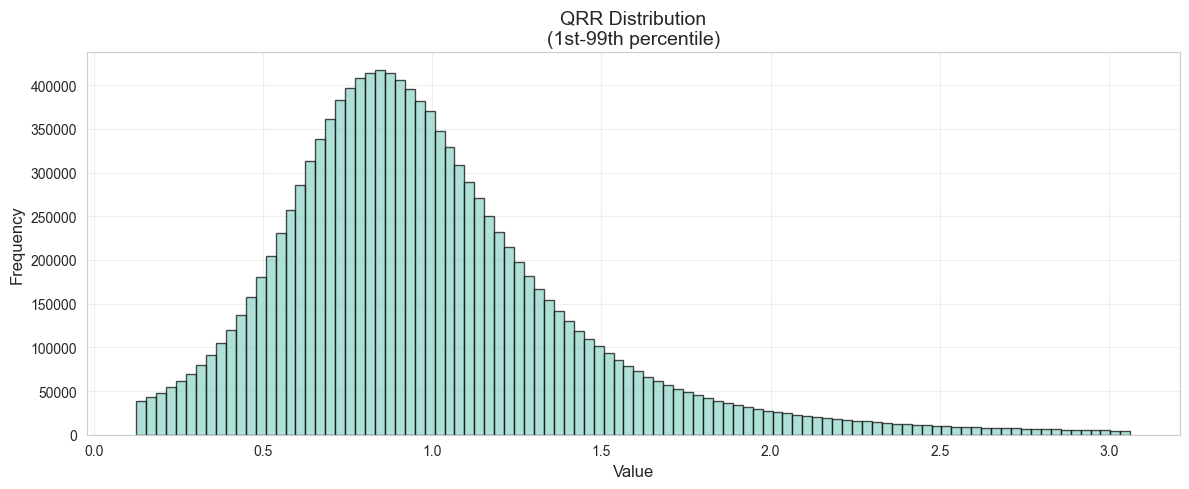

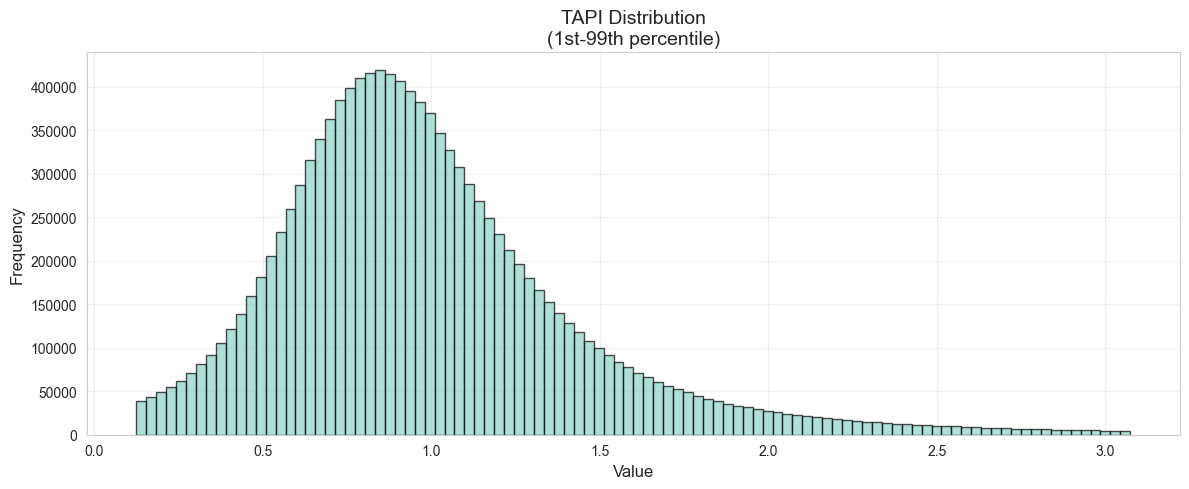

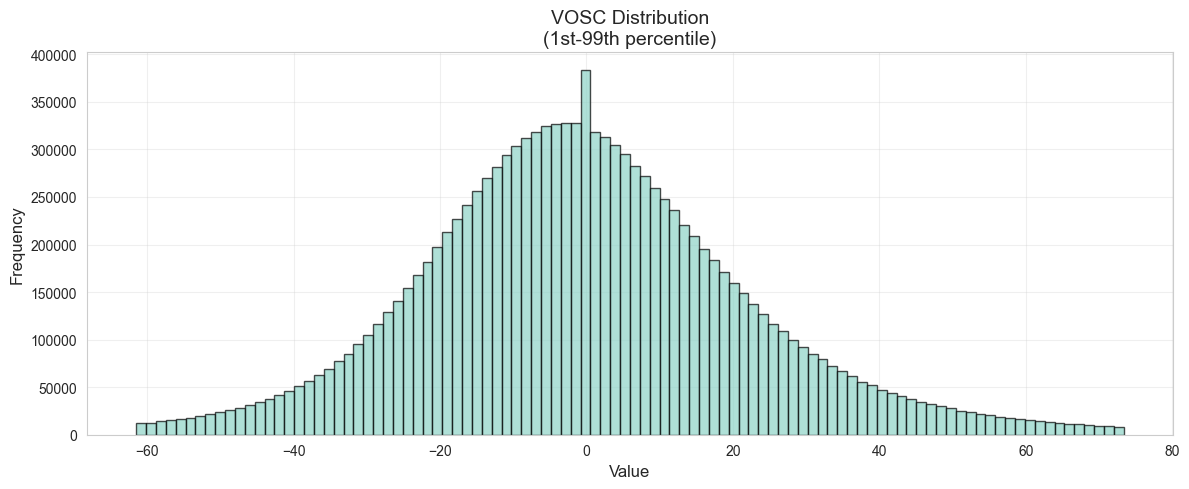

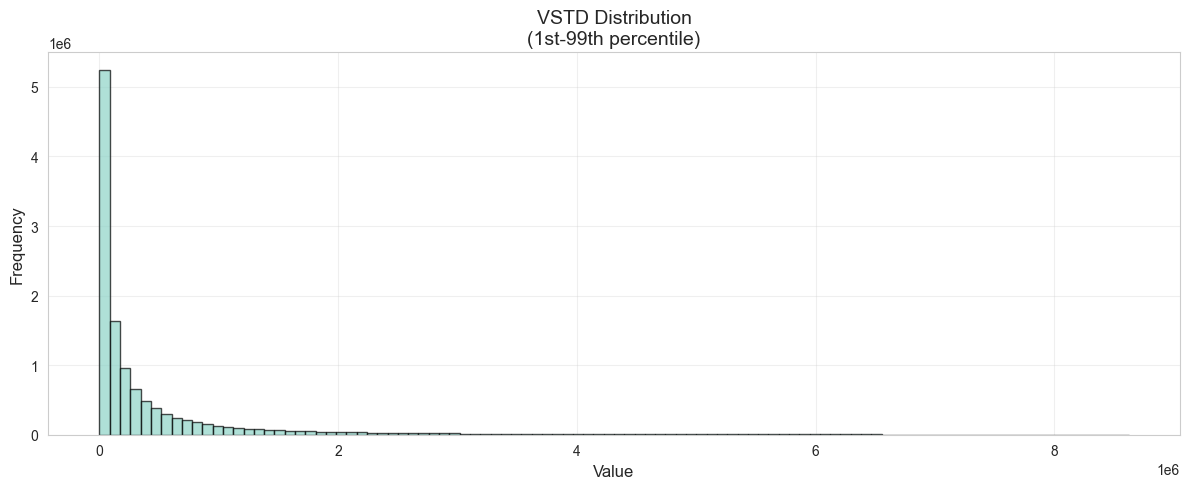

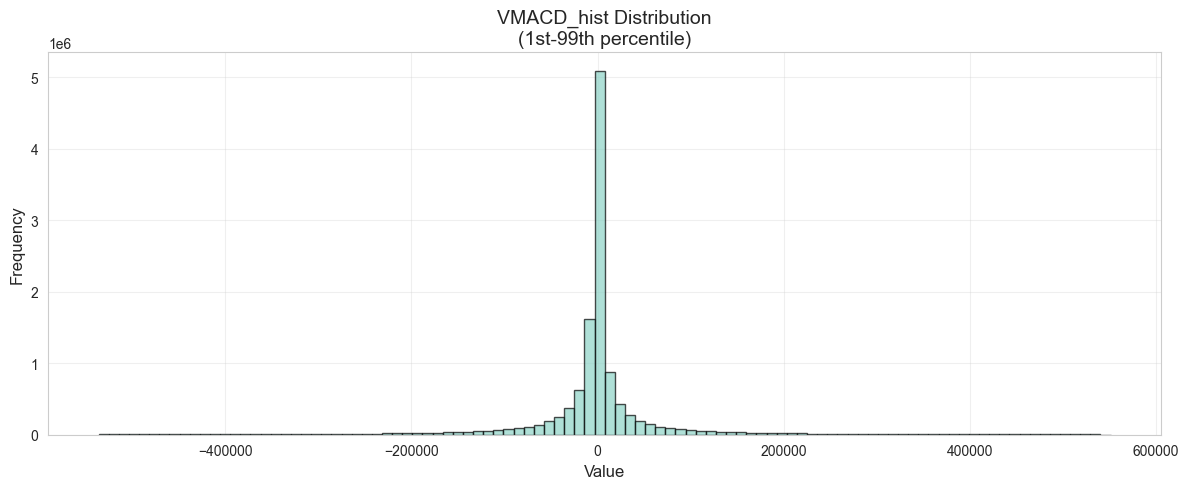

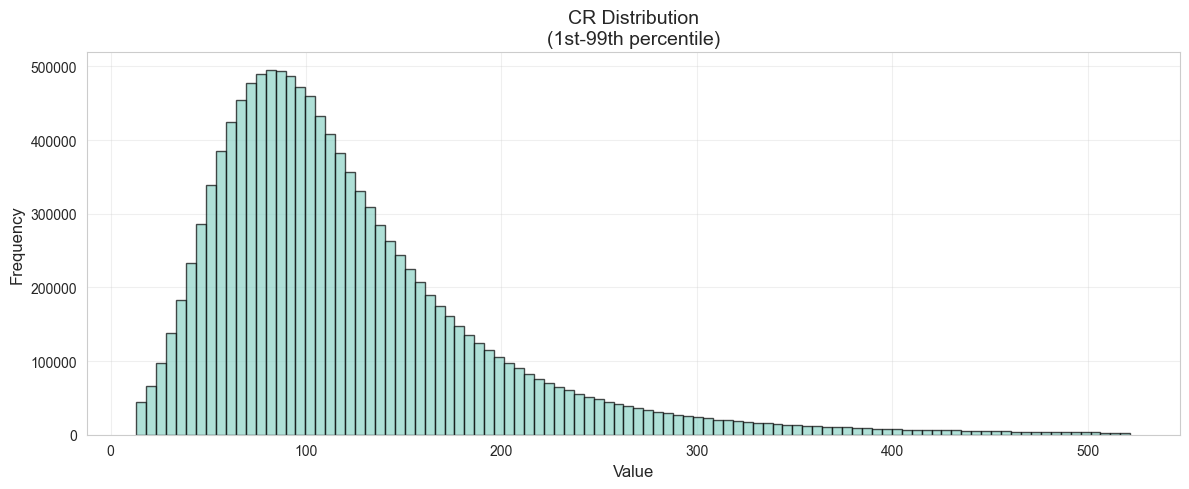

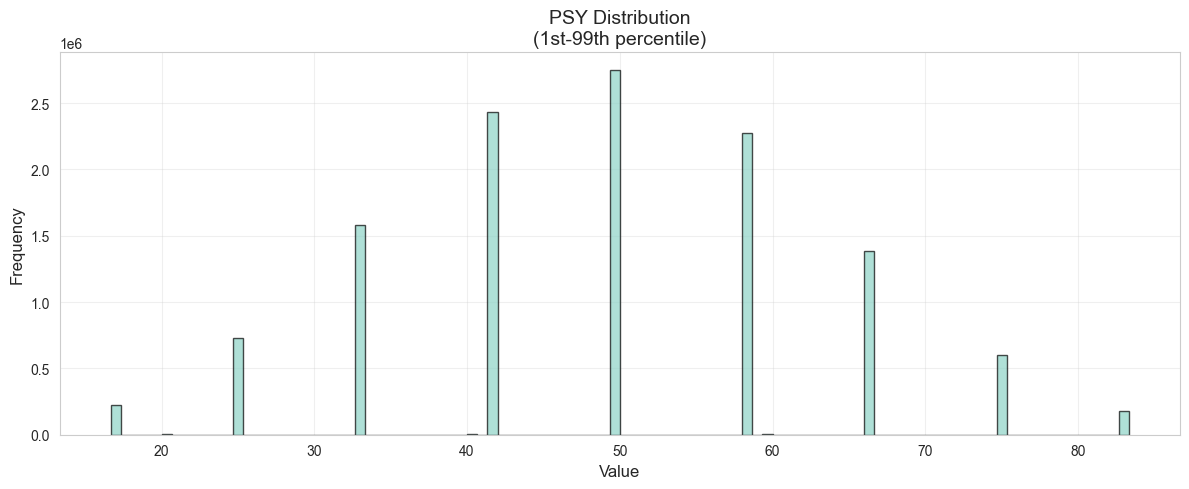

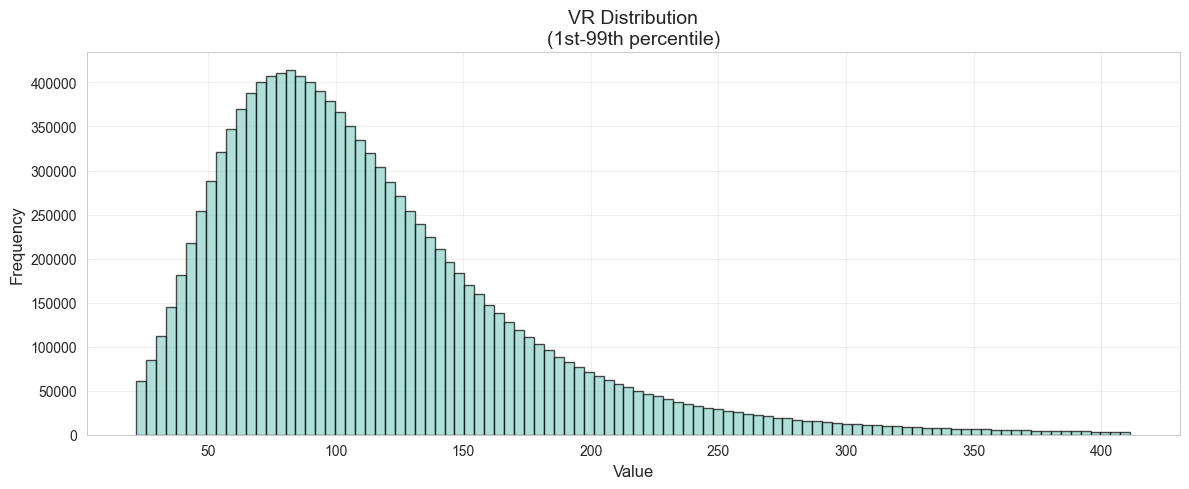

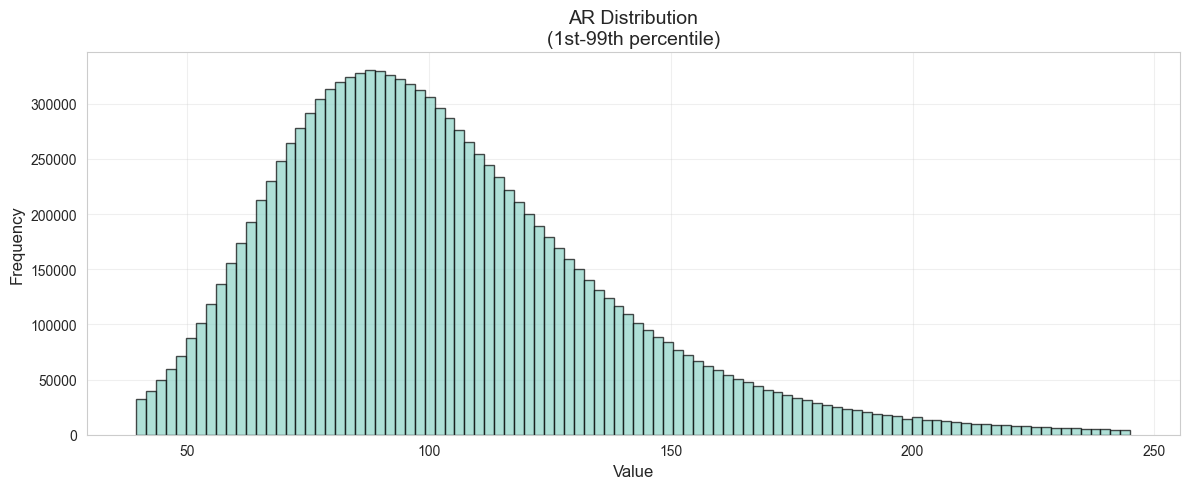

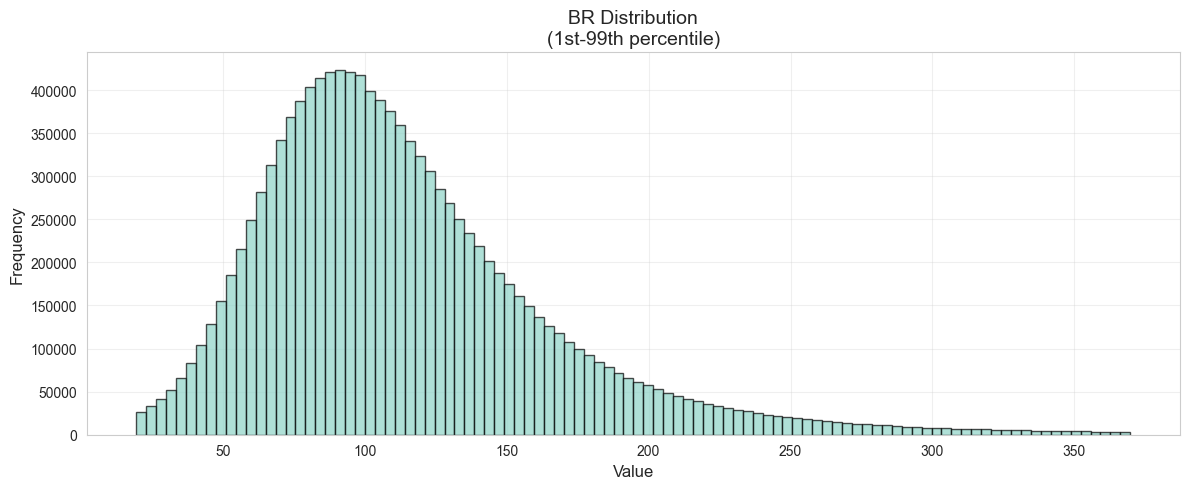

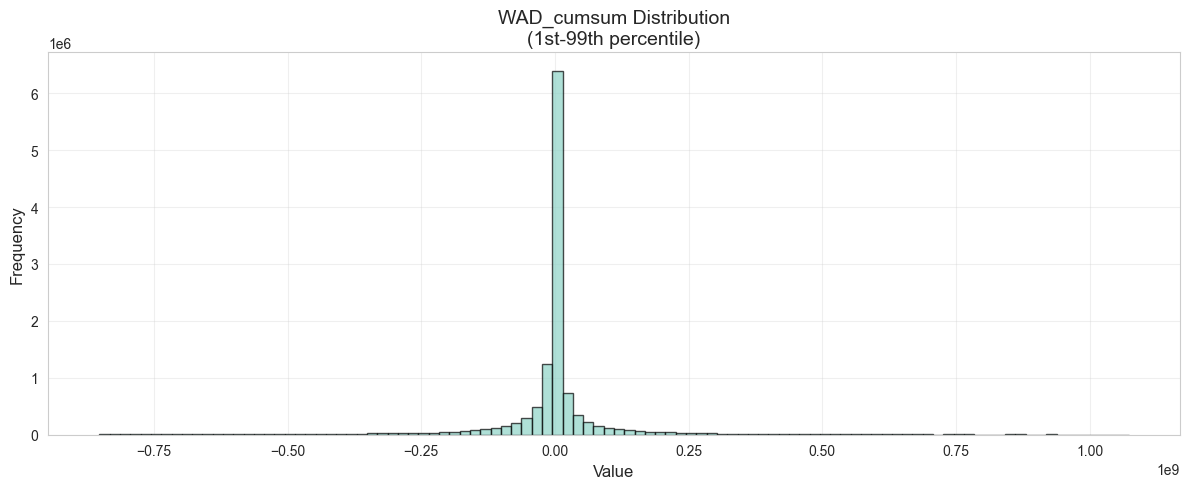

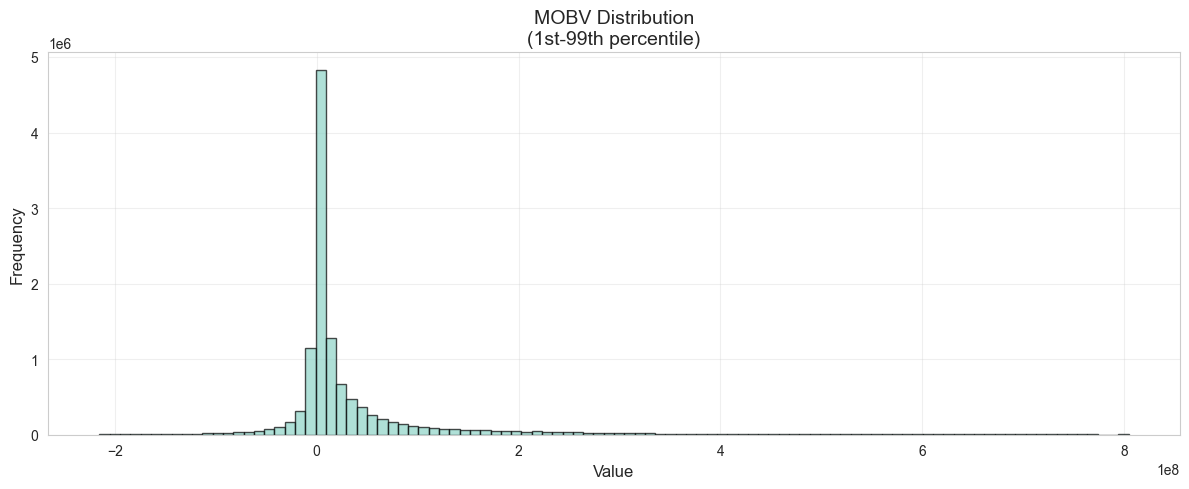

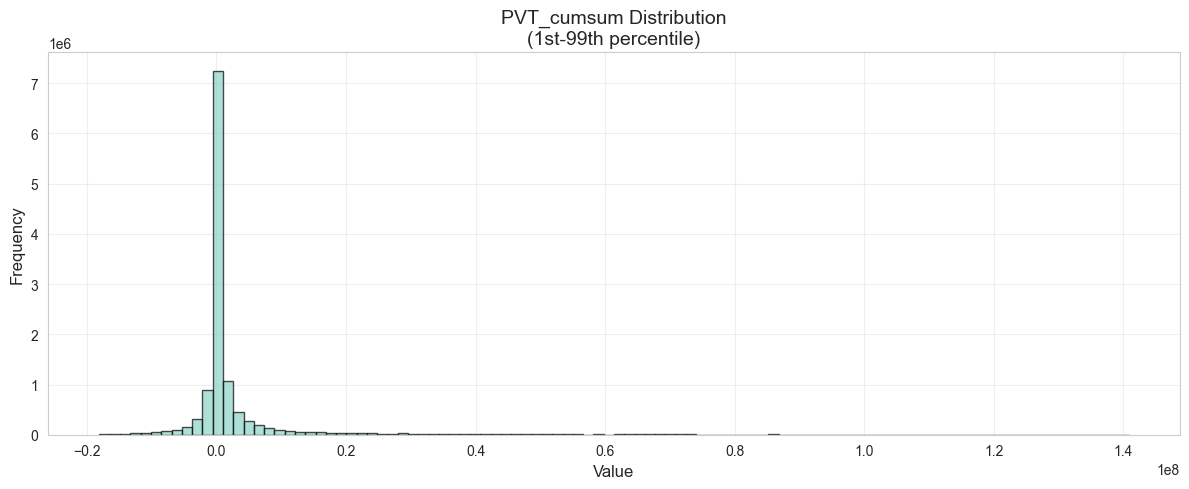

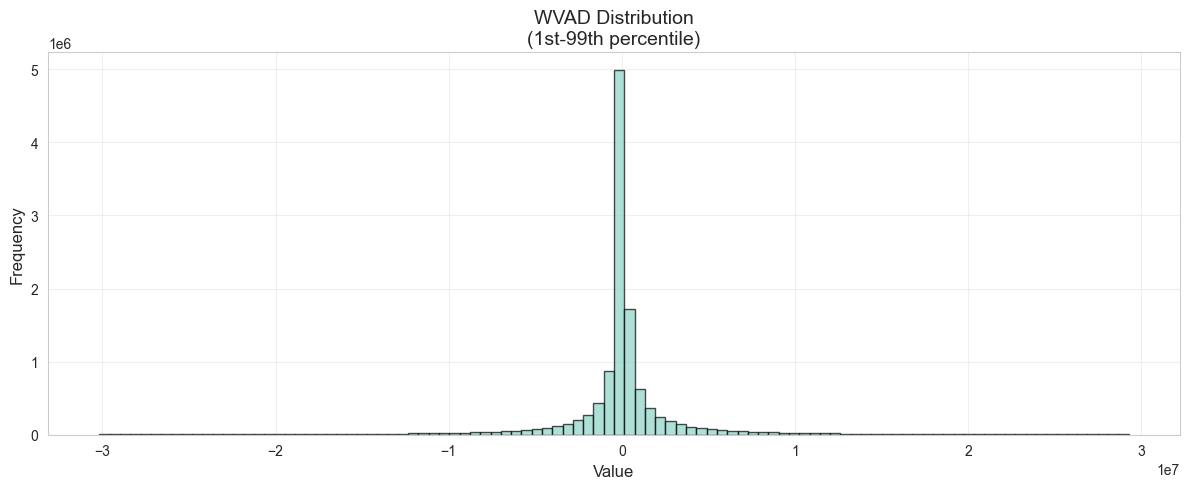

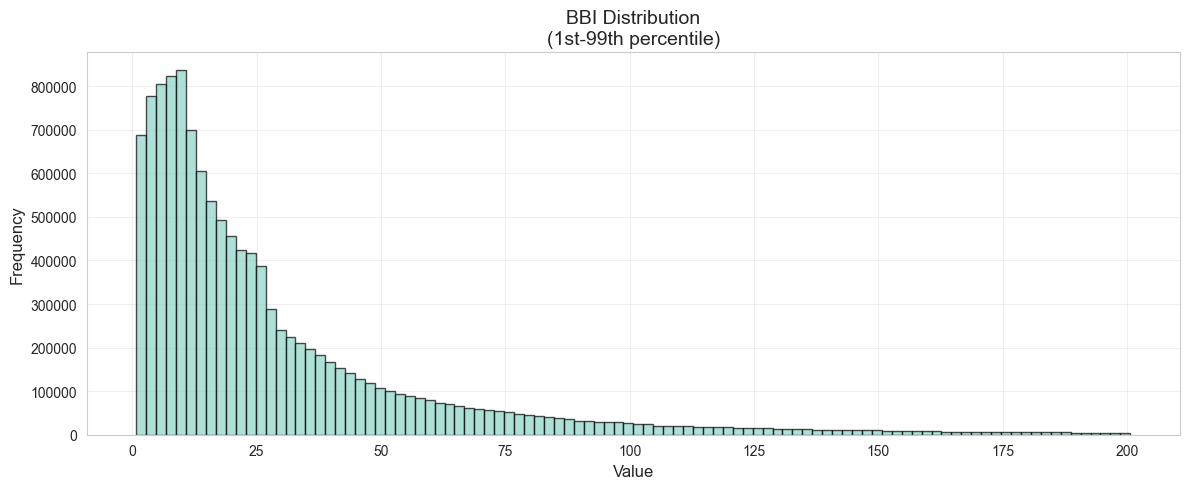

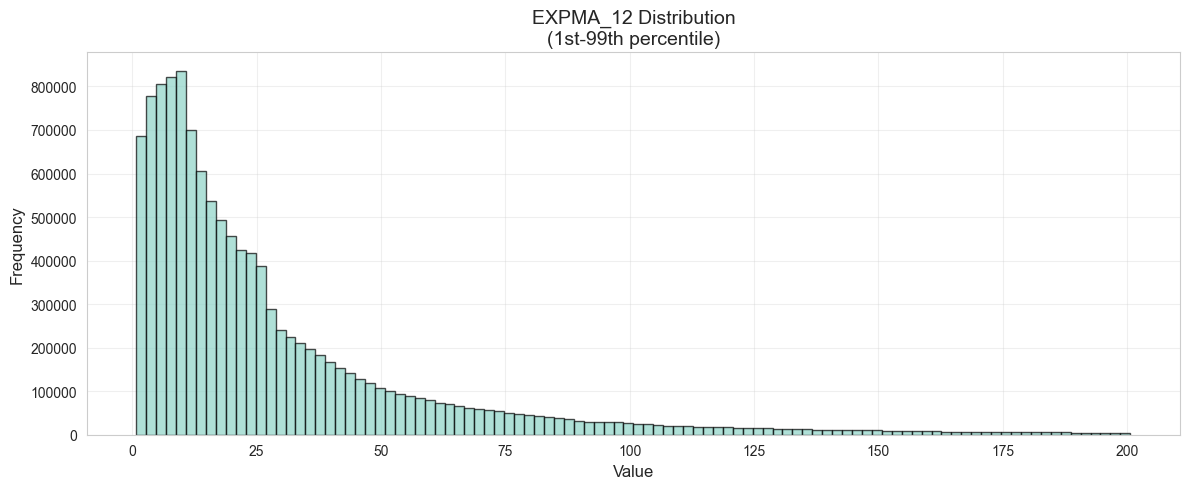

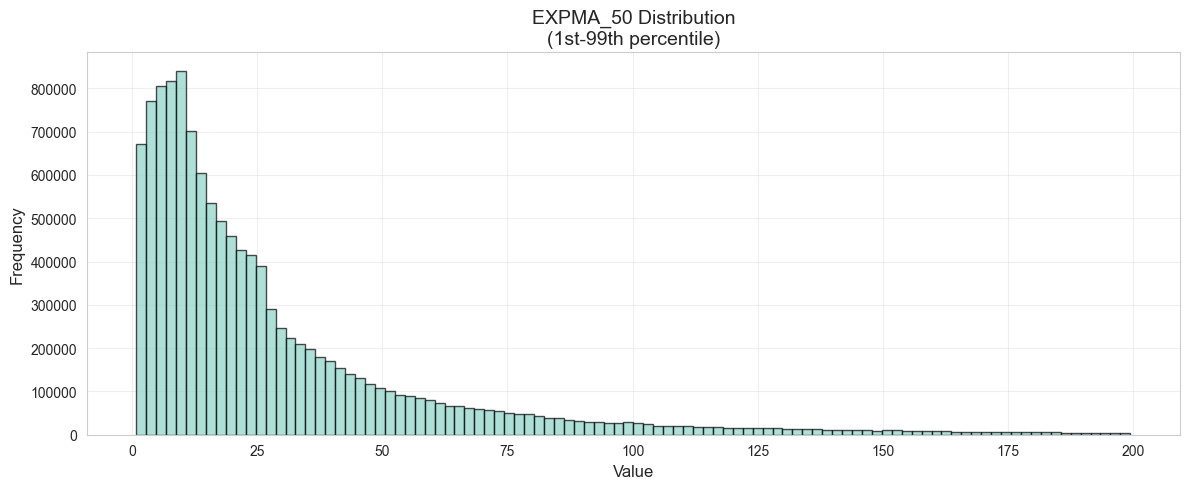

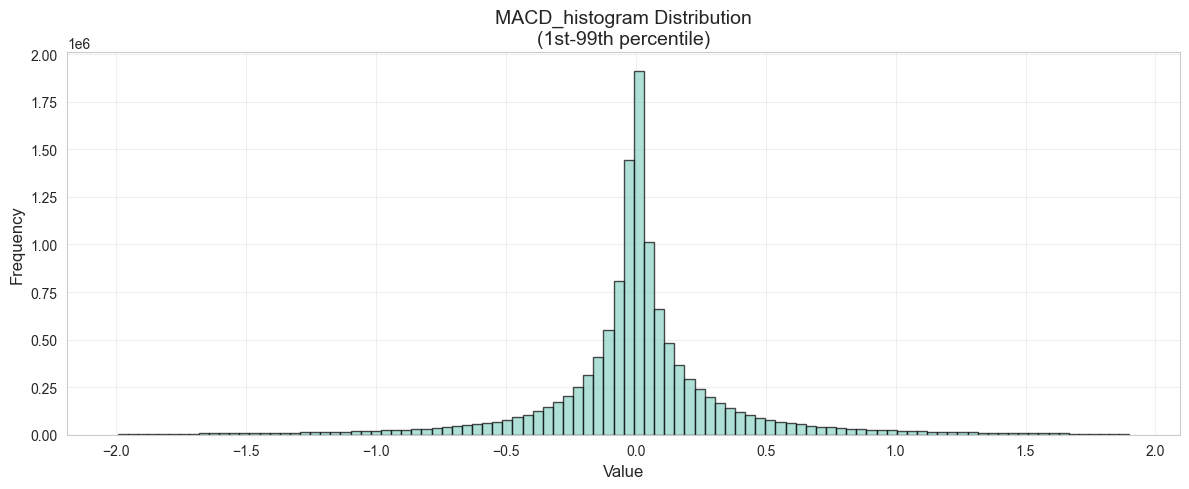

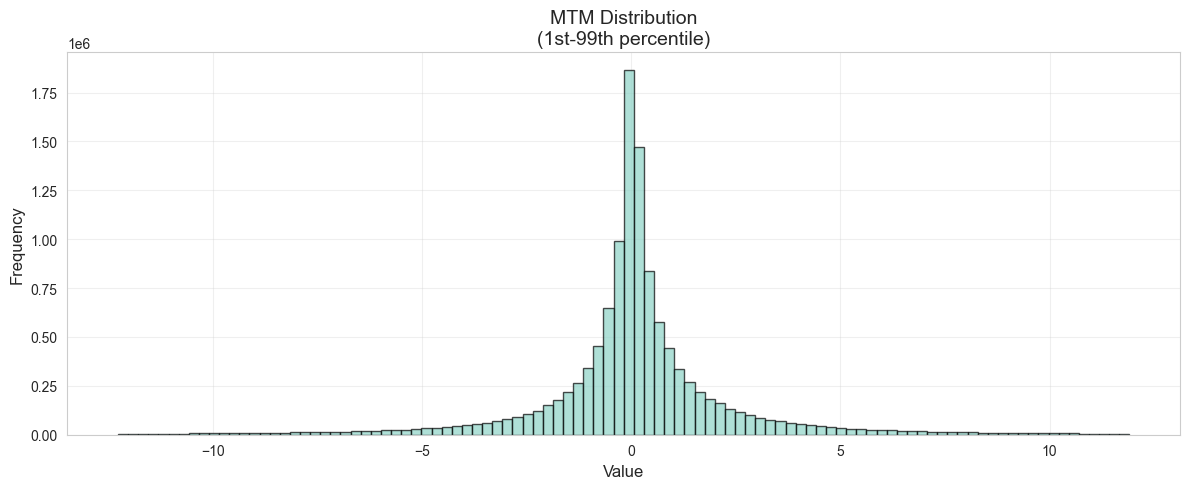

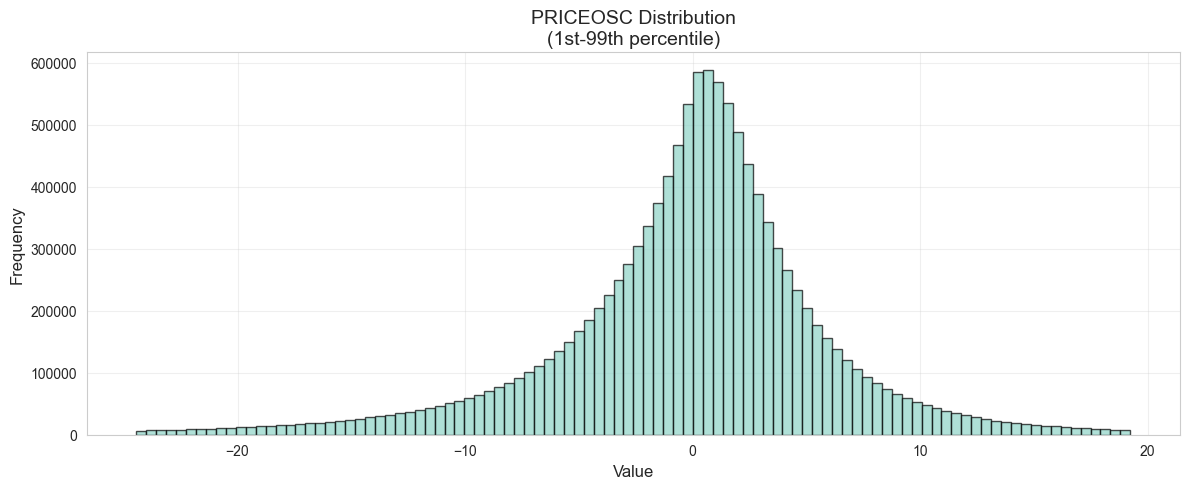

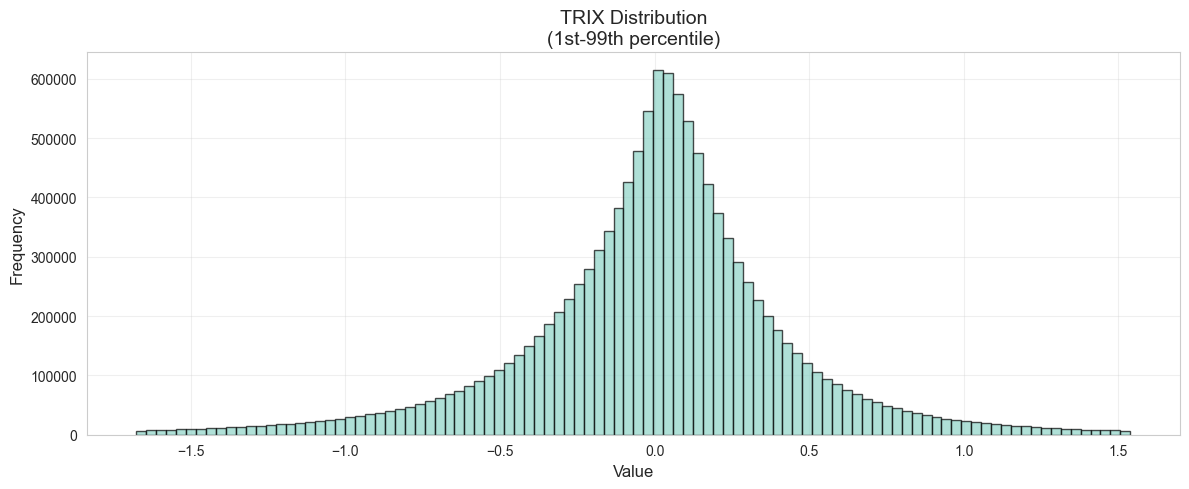

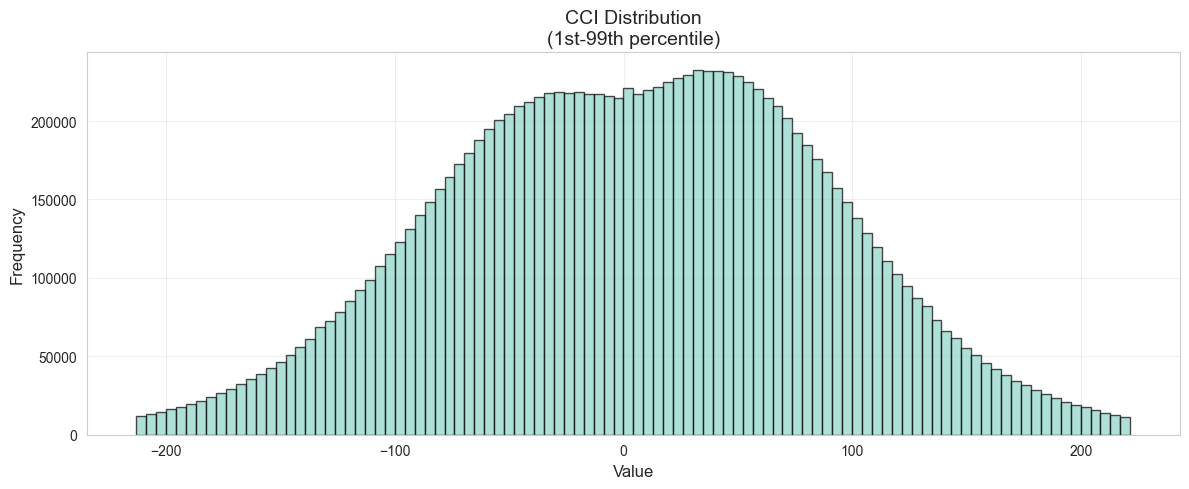

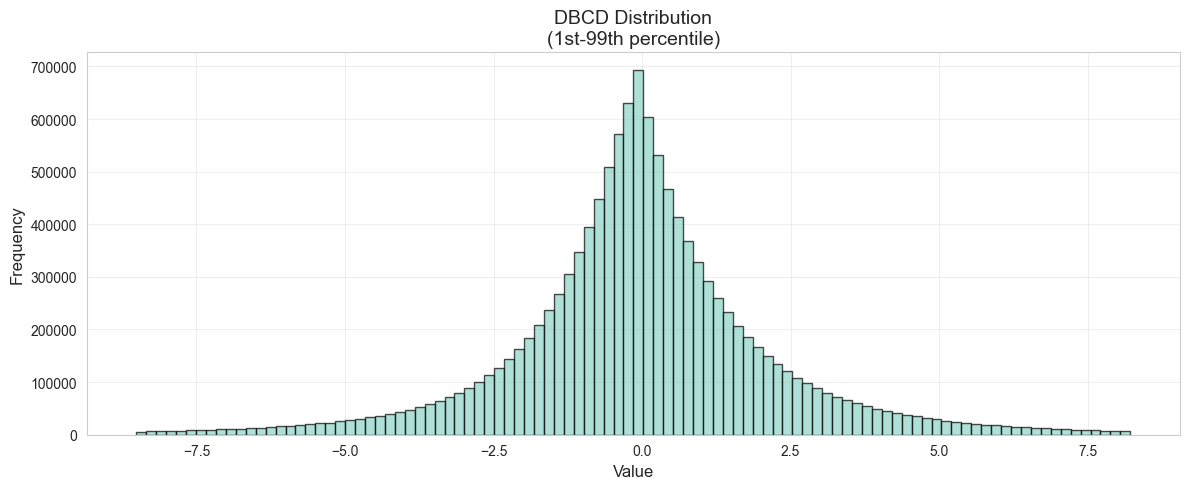

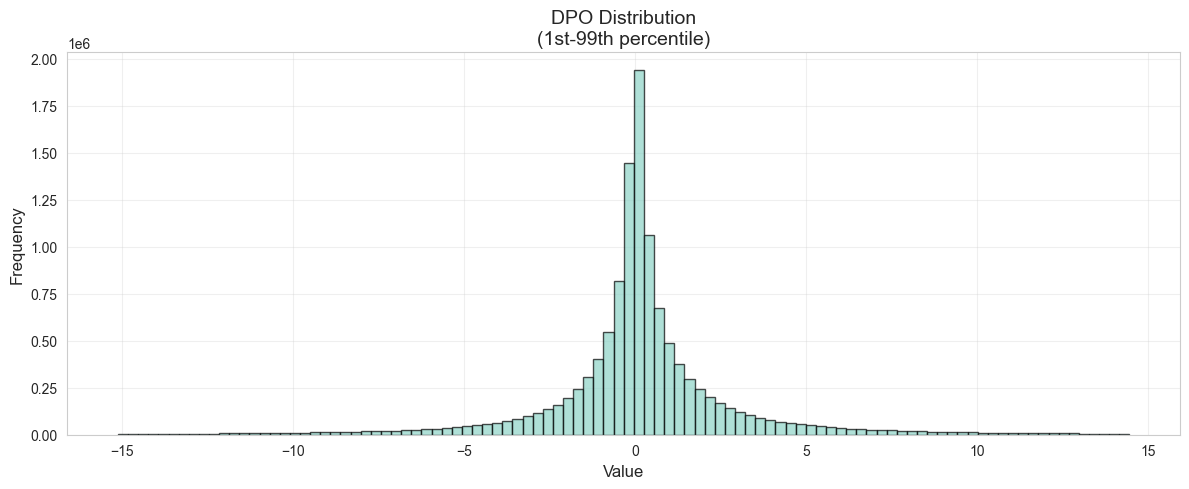

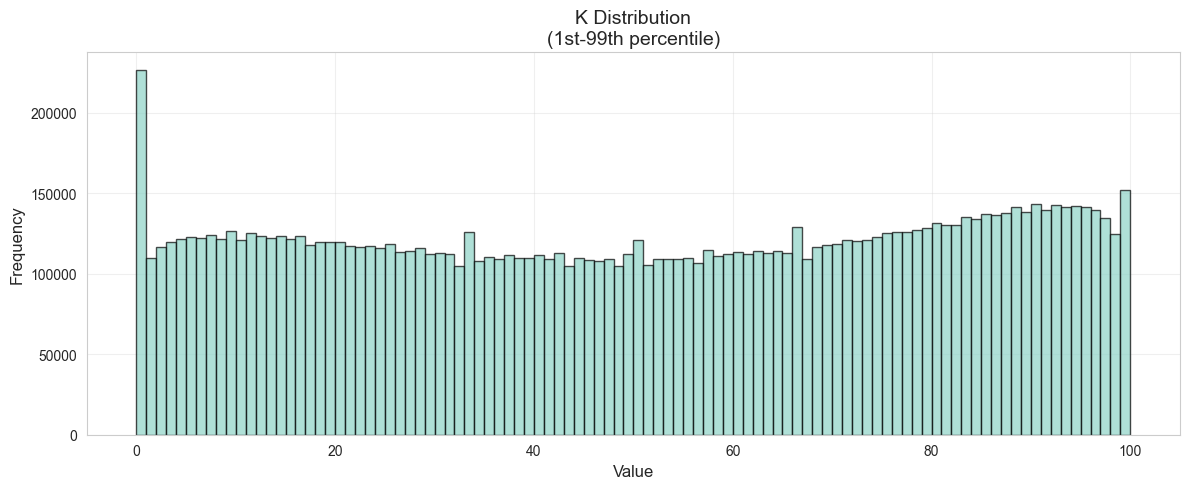

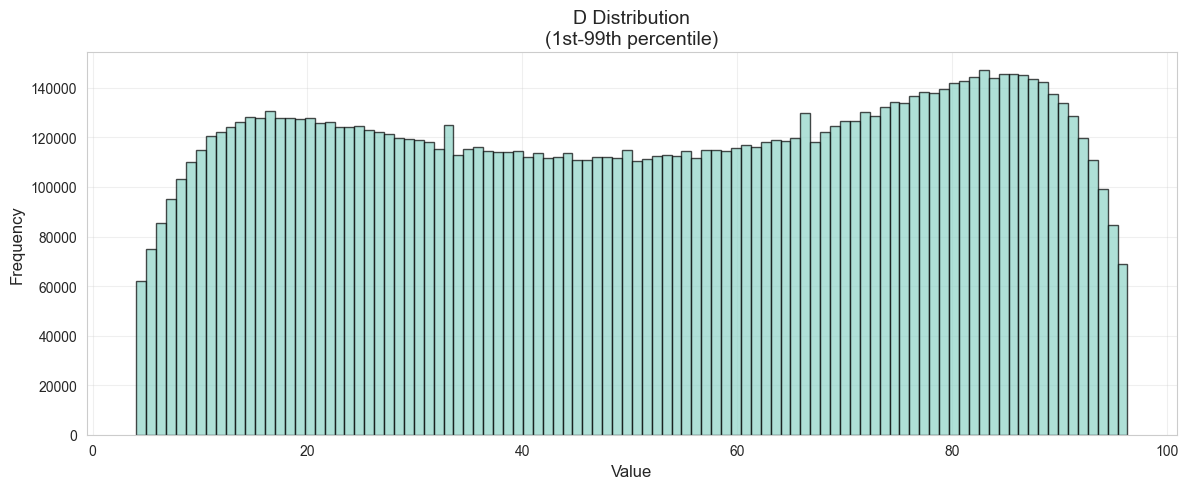

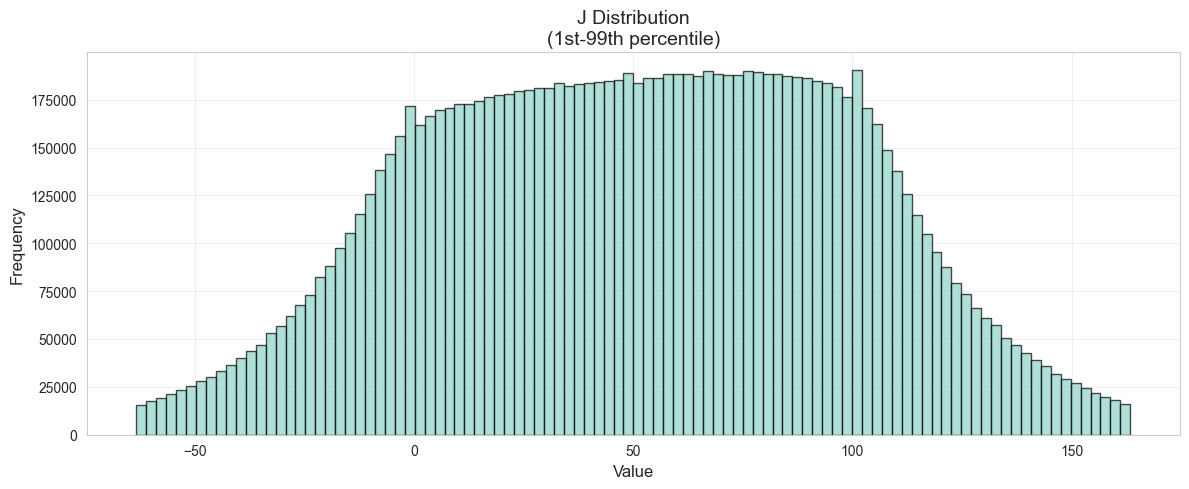

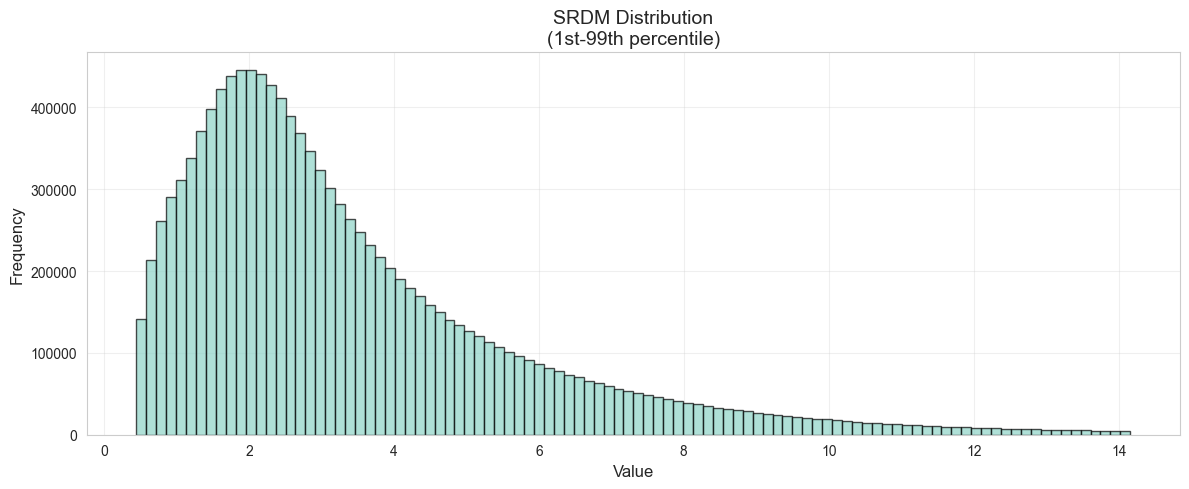

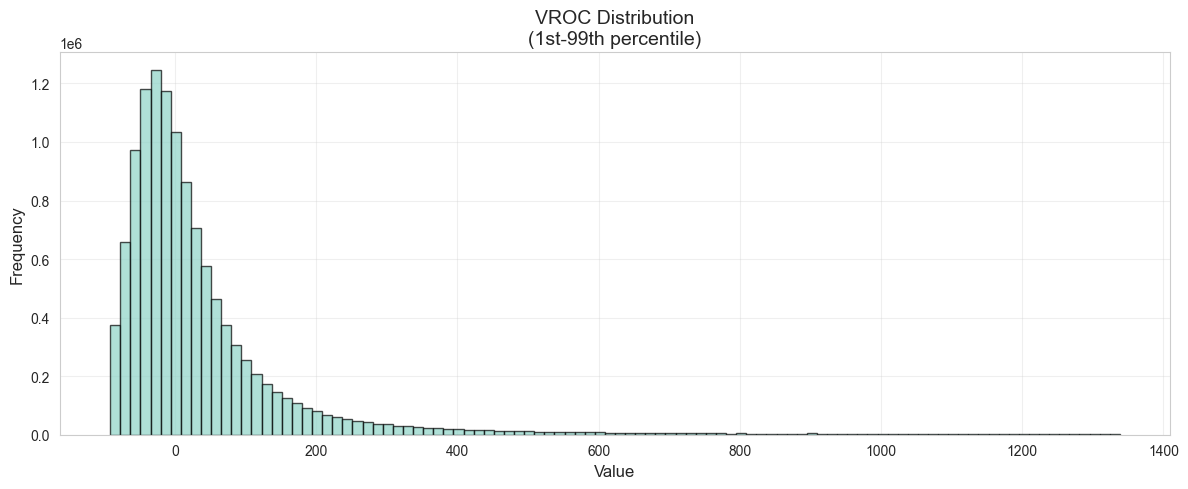

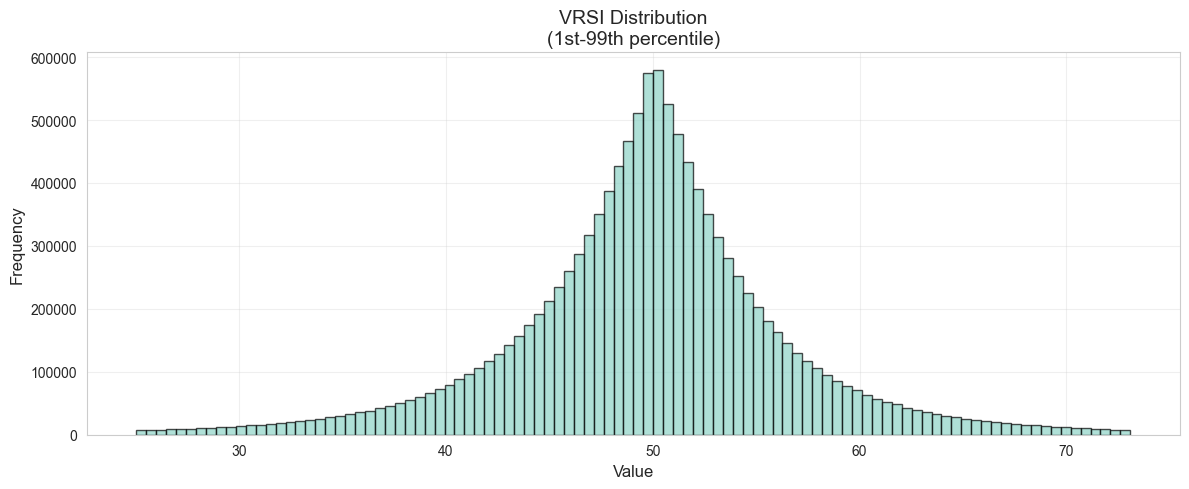

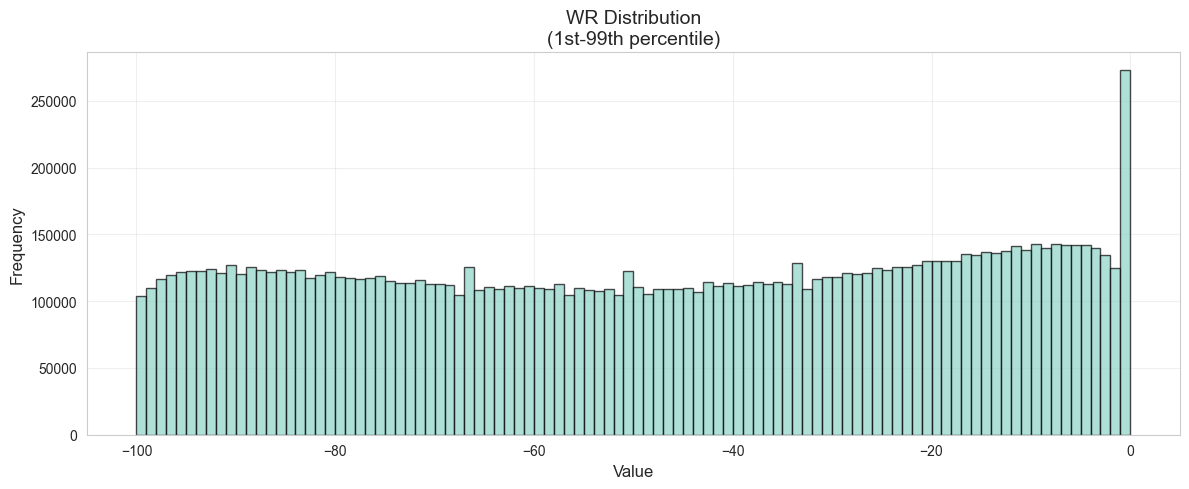

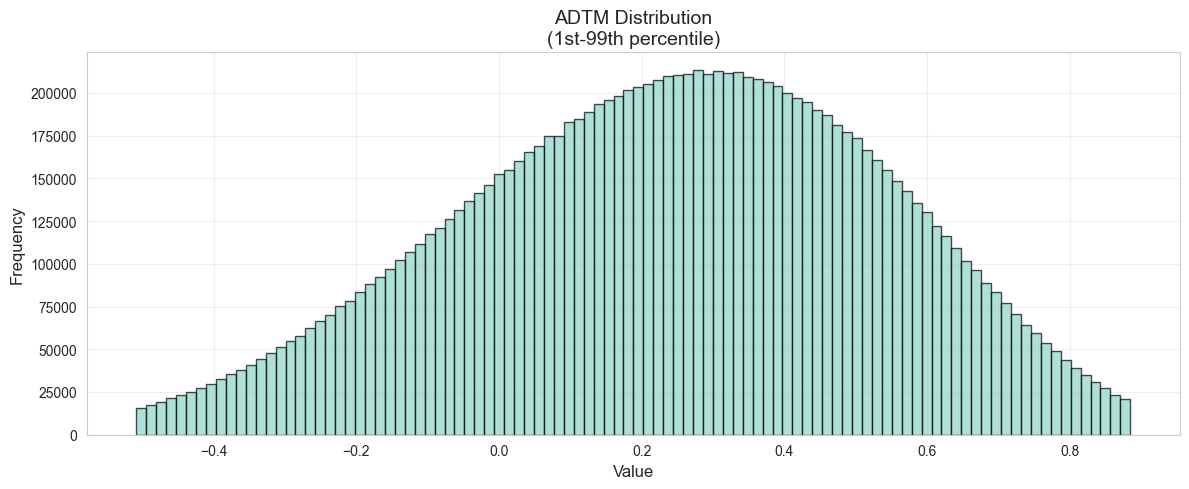

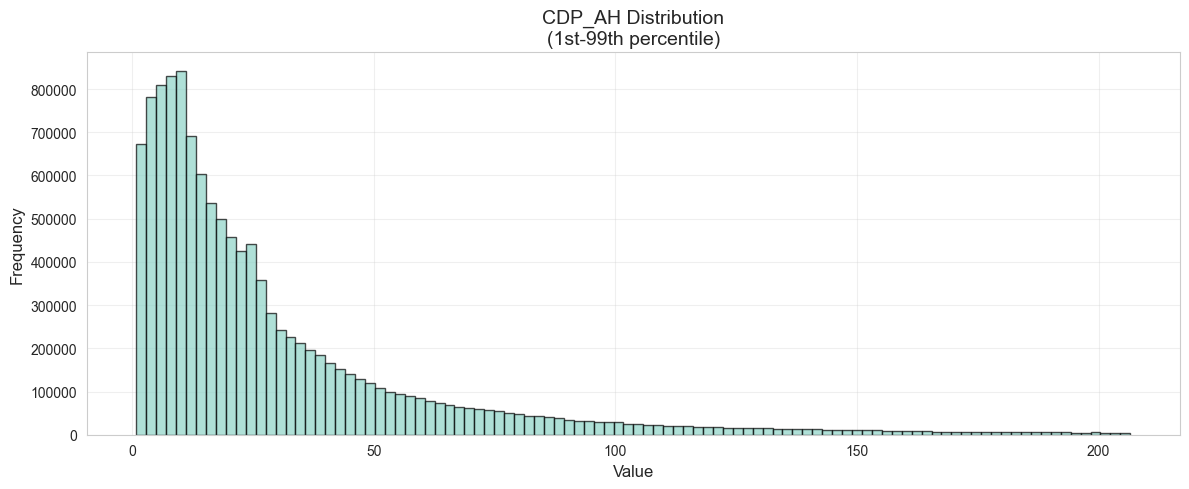

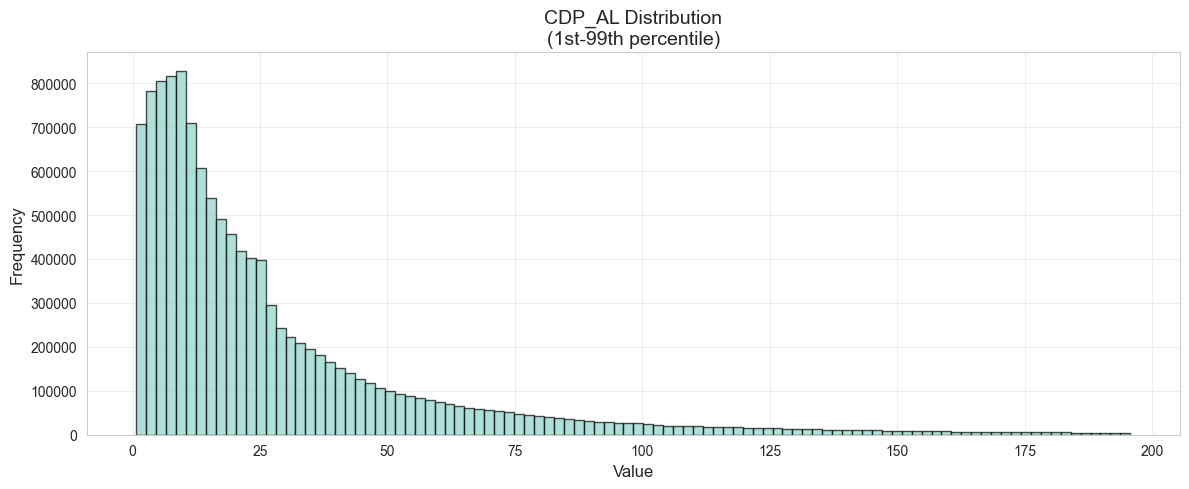

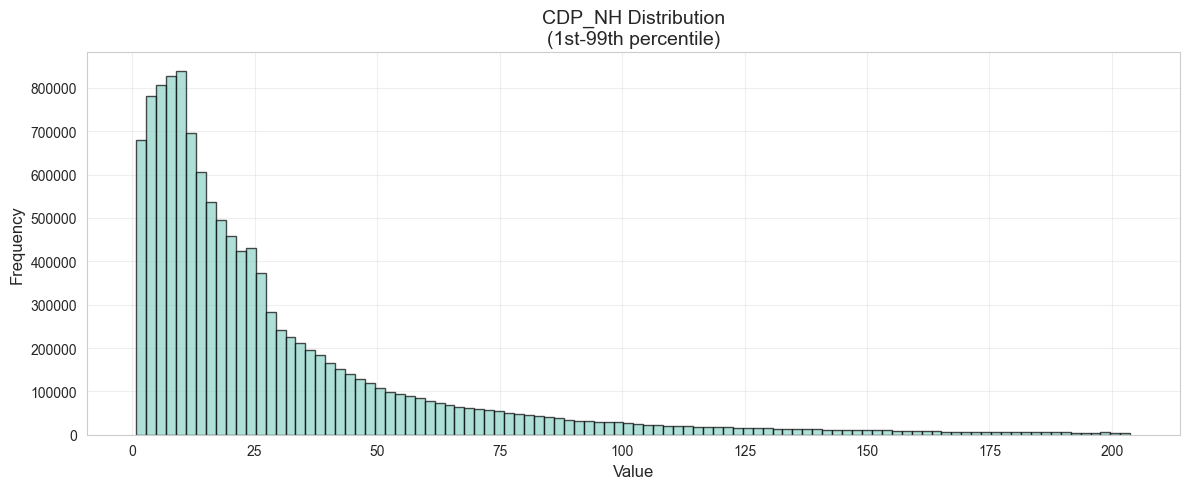

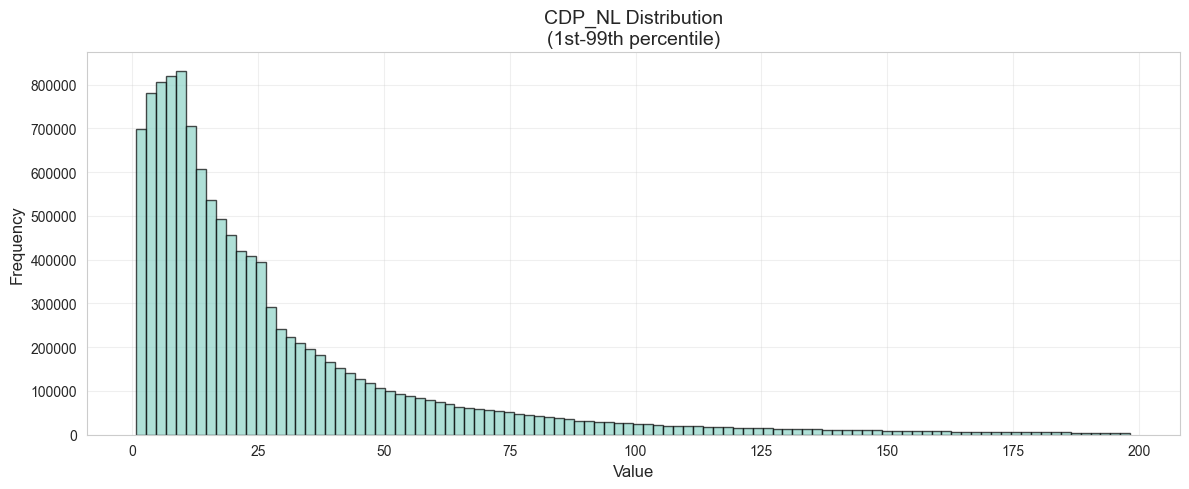

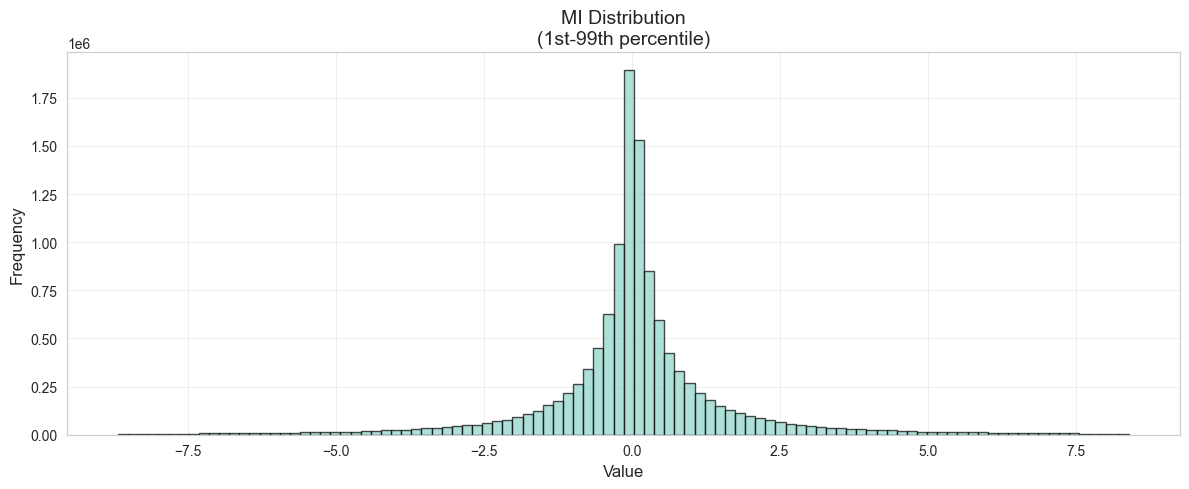

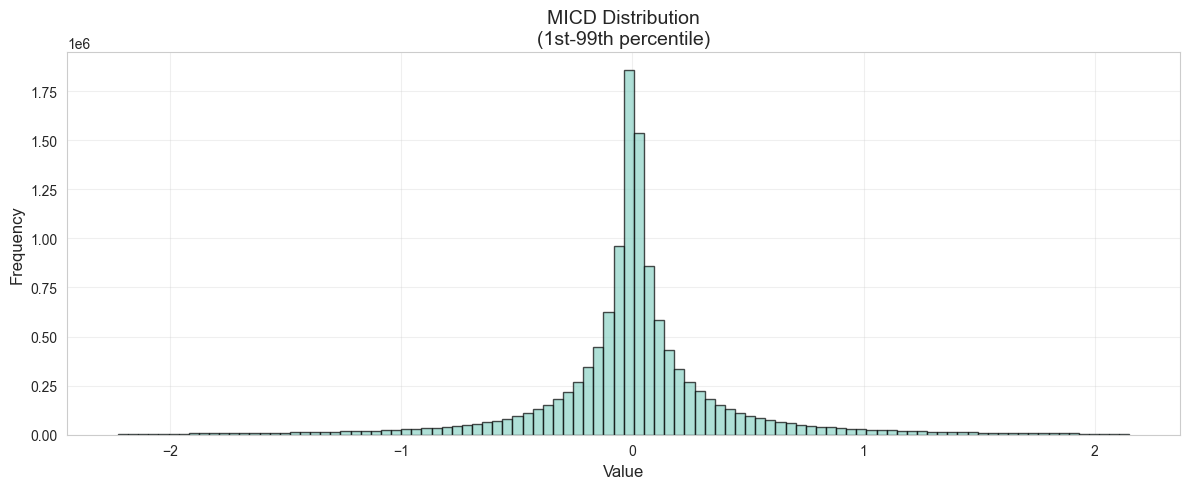

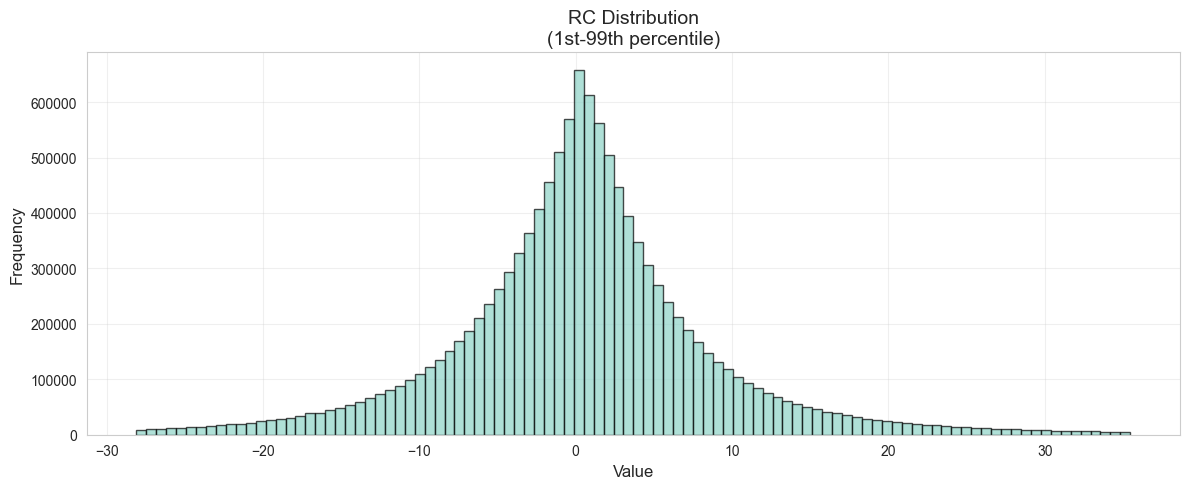

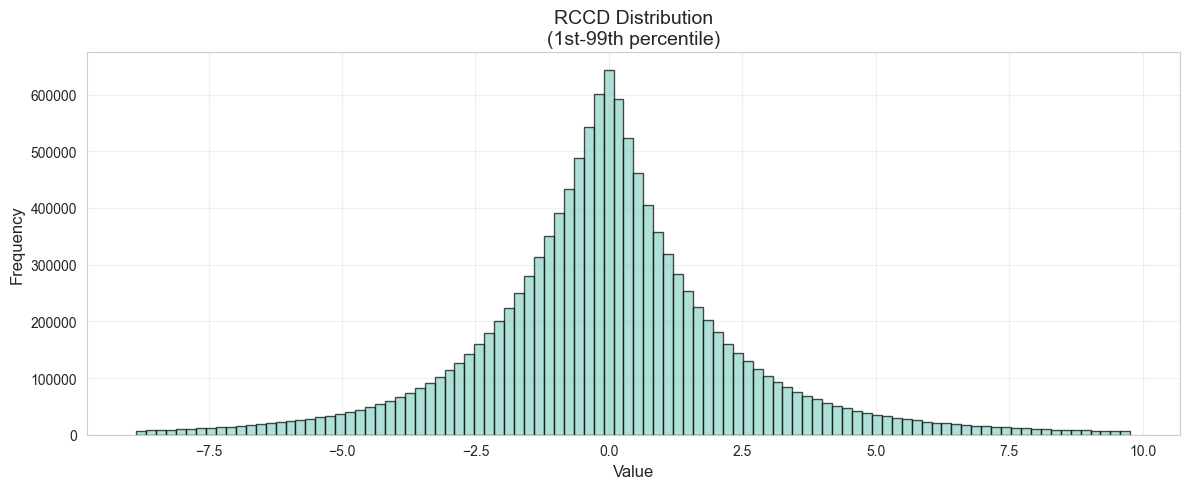

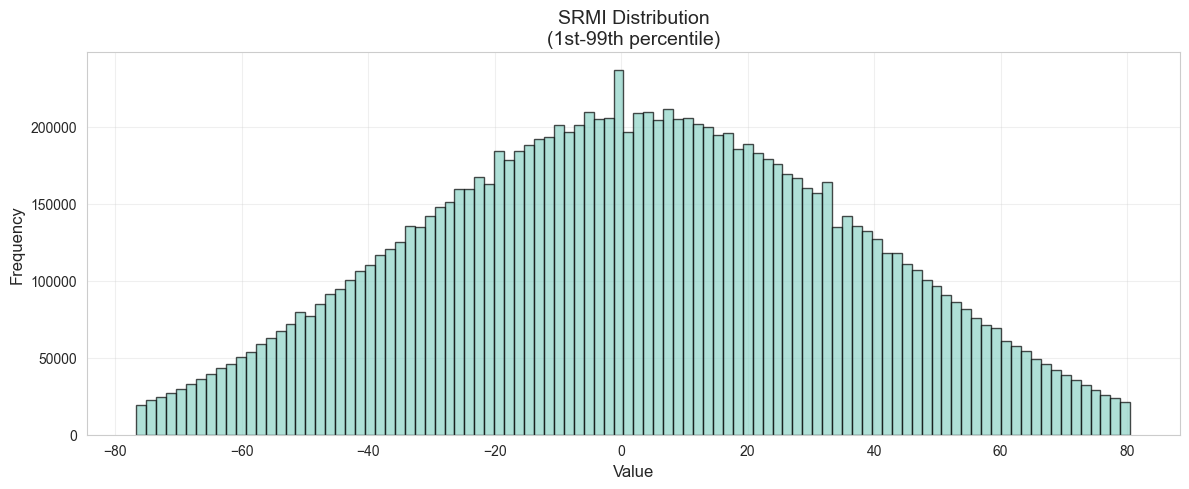

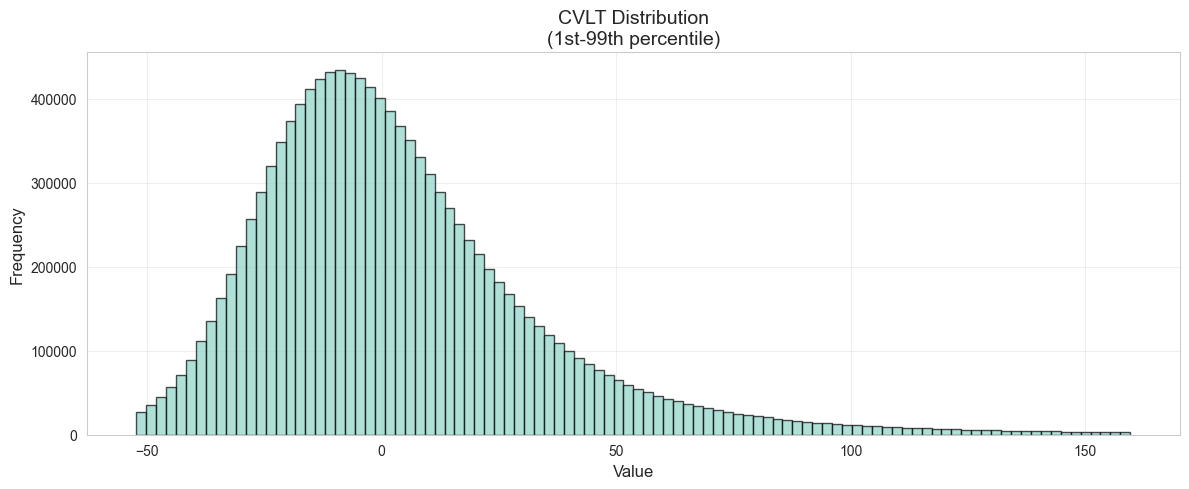

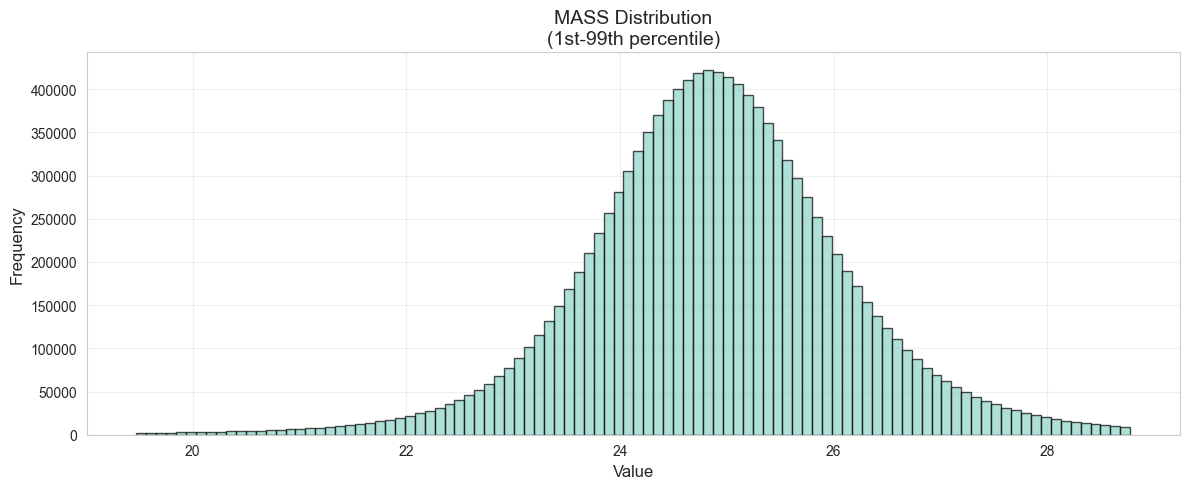

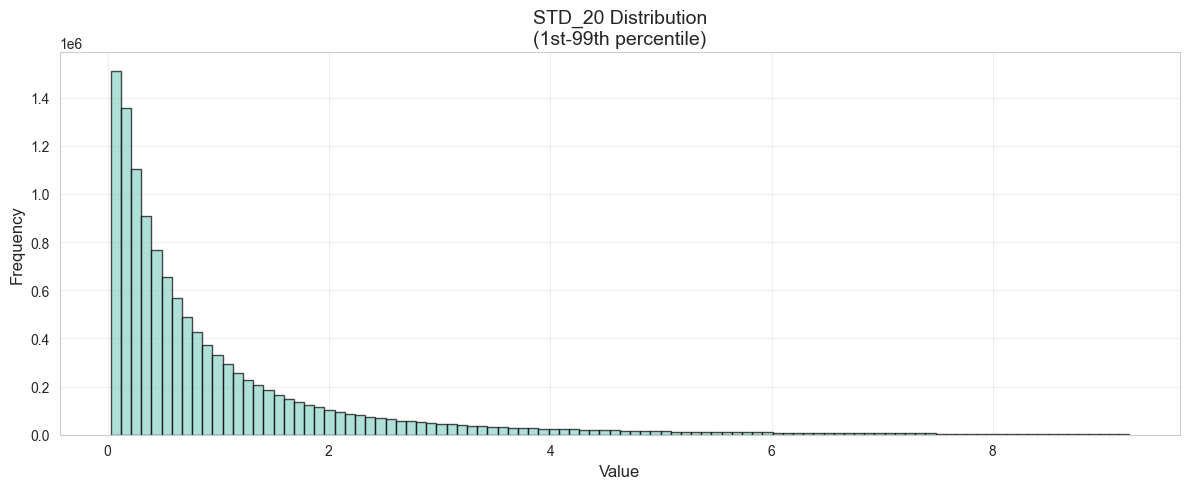

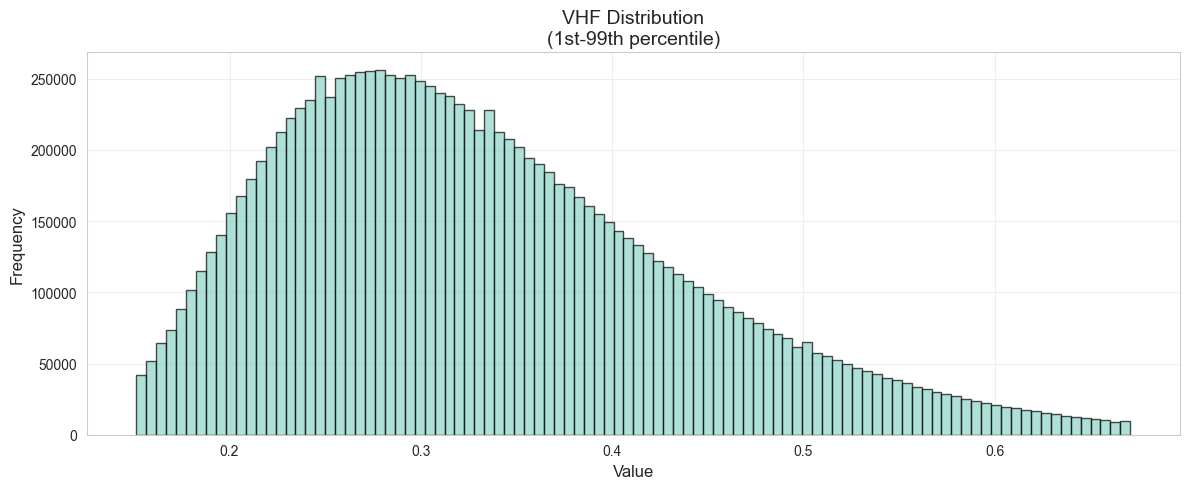

In [9]:

# ============================================================================
# SECTION 3: DATA QUALITY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[3] DATA QUALITY ANALYSIS")
print("="*80)

feature_columns = [
    # ════════════════════════════════════════════════════════════════════════
    # PREVIOUSLY VALIDATED FEATURES (28 features)
    # ════════════════════════════════════════════════════════════════════════

    # Critical Features (4)
    'max_drawdown_20',
    'recent_high_20',
    'recent_low_20',
    'downside_deviation_10',

    # Normalized Price (3)
    'high_to_close_ratio',
    'low_to_close_ratio',
    'price_position_20',

    # Price Position (3)
    'distance_from_high',
    'distance_from_low',
    'close_30d_ago',

    # Moving Averages (3)
    'MA_5',
    'MA_20',
    'MA_60',

    # MA-Based (4)
    'price_to_MA5',
    'price_to_MA20',
    'price_to_MA60',
    'MA_60_slope',

    # Volatility (3)
    'volatility_20',
    'RSI_14',
    'parkinson_volatility',

    # Price Features (3)
    'daily_return',
    'high_low_ratio',
    'return_30',

    # Bollinger Bands (2)
    'BB_upper',
    'BB_lower',

    # Temporal (3)
    'month_sin',
    'month_cos',
    'is_up_day',

    # ════════════════════════════════════════════════════════════════════════
    # NEW HIGH-PERFORMING FEATURES (15 features)
    # Sorted by Mutual Information score
    # ════════════════════════════════════════════════════════════════════════

    # Volume Price Index (3) - Highest MI!
    'PVT_cumsum',           # MI = 0.0426 ⭐⭐⭐
    'WAD_cumsum',           # MI = 0.0381 ⭐⭐⭐
    'MOBV',                 # MI = 0.0209 ⭐⭐

    # Directional Movement (4)
    'EXPMA_50',             # MI = 0.0132 ⭐
    'MTM',                  # MI = 0.0127 ⭐
    'BBI',                  # MI = 0.0095
    'EXPMA_12',             # MI = 0.0095

    # Pressure and Support (4)
    'CDP_NH',               # MI = 0.0116
    'CDP_NL',               # MI = 0.0115
    'CDP_AH',               # MI = 0.0109
    'CDP_AL',               # MI = 0.0107

    # OverBought & OverSold (1)
    'ADTM',                 # MI = 0.0104

    # Energy & Volatility (2)
    'PSY',                  # MI = 0.0085
    'VHF',                  # MI = 0.0088

    # Stochastic (1)
    'K',                    # MI = 0.0083
]

# Check missing values
print("\nMissing values in engineered features:")
missing_stats = df_features[feature_columns].isnull().sum()
missing_pct = (missing_stats / len(df_features) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing_stats,
    'Missing_Percentage': missing_pct
})
print(missing_df)

# Basic statistics
print("\n" + "="*80)
print("FEATURE STATISTICS")
print("="*80)
print(df_features[feature_columns].describe())

IMAGE_DIR = "Images2"
os.makedirs(IMAGE_DIR, exist_ok=True)

# Visualization: Distribution of features
for feature in feature_columns:
    data = df_features[feature].dropna()

    # Remove extreme outliers for better visualization (keep 1st-99th percentile)
    q1, q99 = data.quantile([0.01, 0.99])
    data_filtered = data[(data >= q1) & (data <= q99)]

    plt.figure(figsize=(12, 5))  # wider figure
    plt.hist(data_filtered, bins=100, edgecolor='black', alpha=0.7)
    plt.title(f'{feature} Distribution\n(1st-99th percentile)', fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(
        os.path.join(IMAGE_DIR, f'feature_{feature}.png'),
        dpi=300,
        bbox_inches='tight'
    )

    plt.show()


[4] AUTOCORRELATION ANALYSIS
Analyzing how each feature correlates with its past values
This helps determine optimal sequence length for RNN

Analyzing autocorrelation: QRR


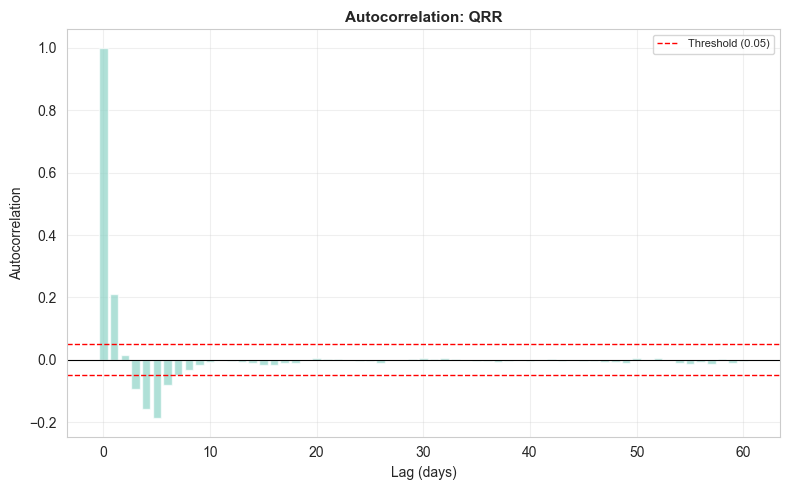

  Optimal lag: 6 days (autocorr = -0.0812)

Analyzing autocorrelation: TAPI


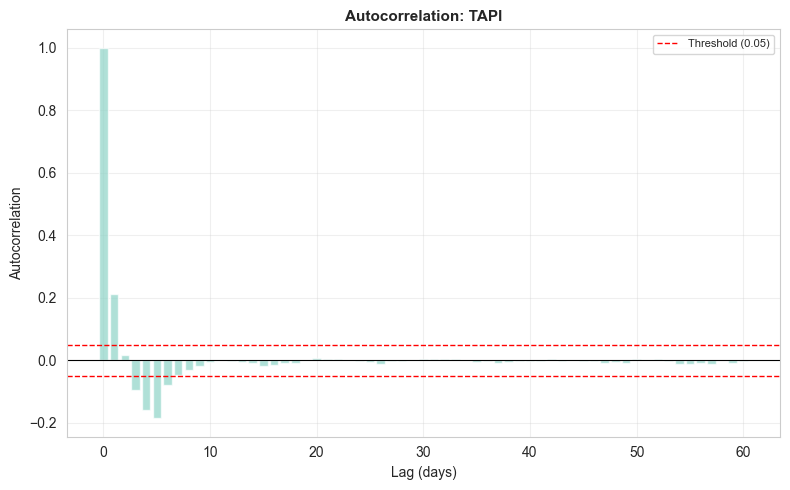

  Optimal lag: 6 days (autocorr = -0.0800)

Analyzing autocorrelation: VOSC


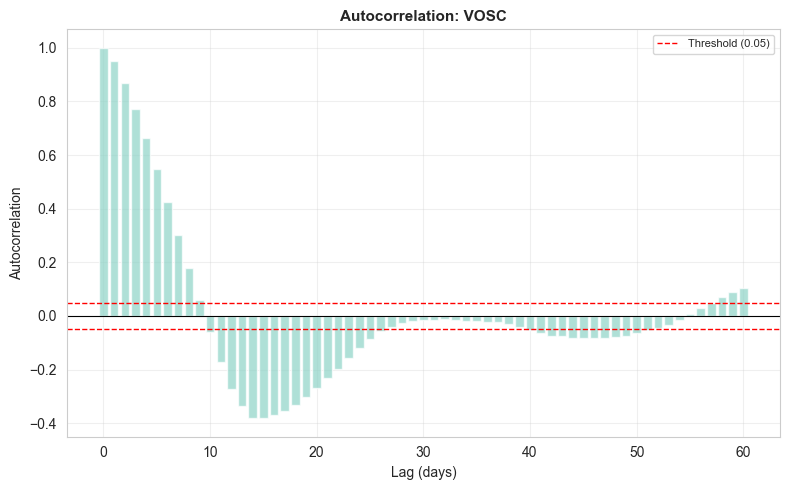

  Optimal lag: 60 days (autocorr = 0.1059)

Analyzing autocorrelation: VSTD


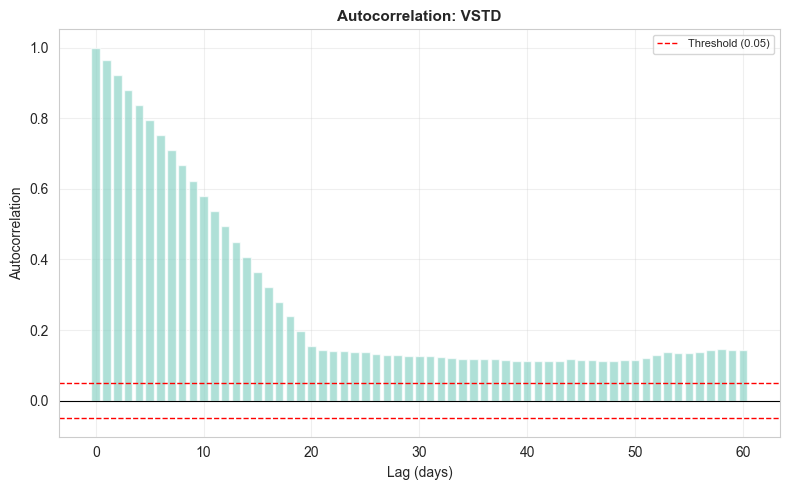

  Optimal lag: 60 days (autocorr = 0.1438)

Analyzing autocorrelation: VMACD_hist


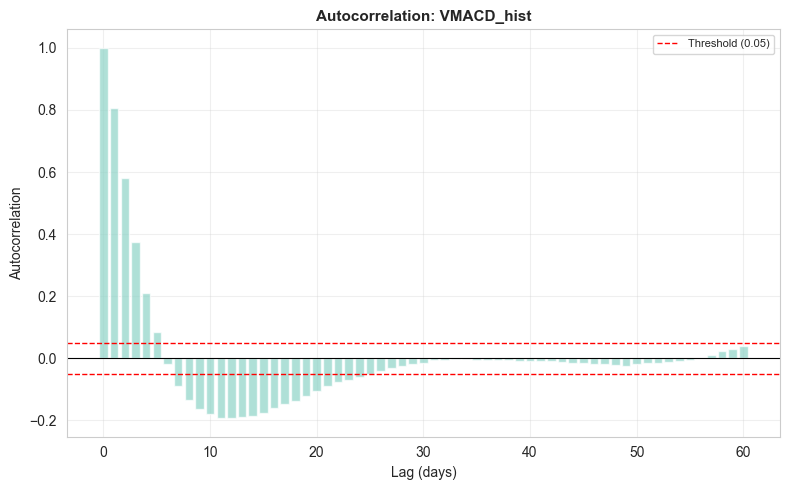

  Optimal lag: 24 days (autocorr = -0.0590)

Analyzing autocorrelation: CR


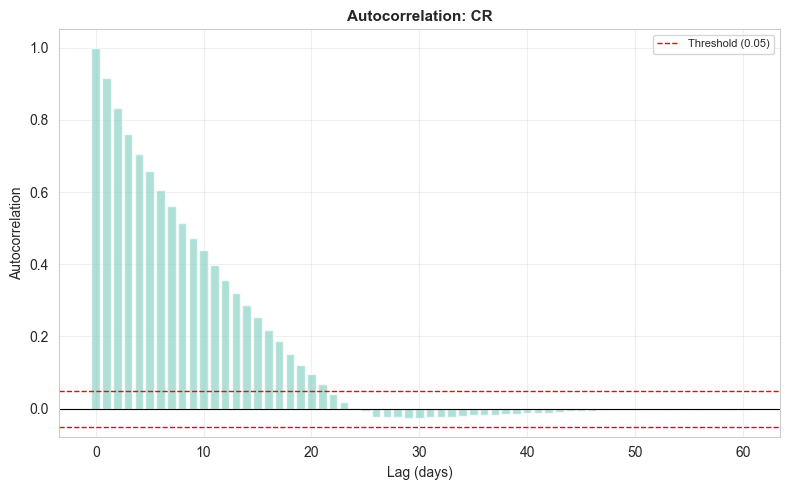

  Optimal lag: 21 days (autocorr = 0.0670)

Analyzing autocorrelation: PSY


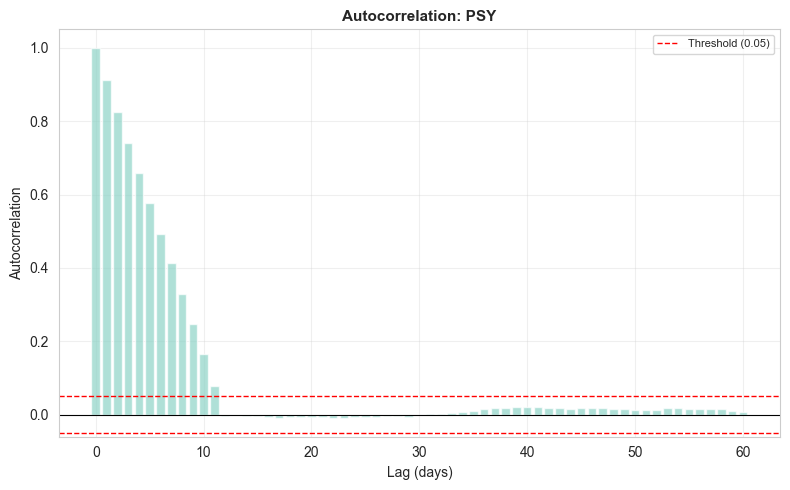

  Optimal lag: 11 days (autocorr = 0.0792)

Analyzing autocorrelation: VR


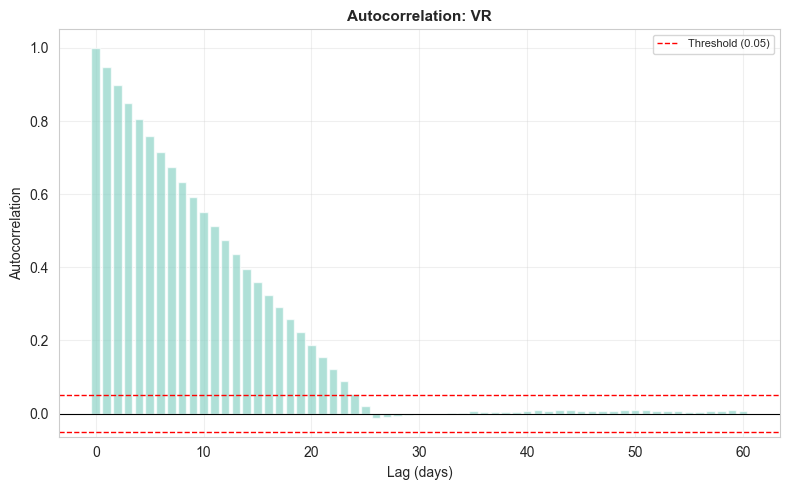

  Optimal lag: 24 days (autocorr = 0.0546)

Analyzing autocorrelation: AR


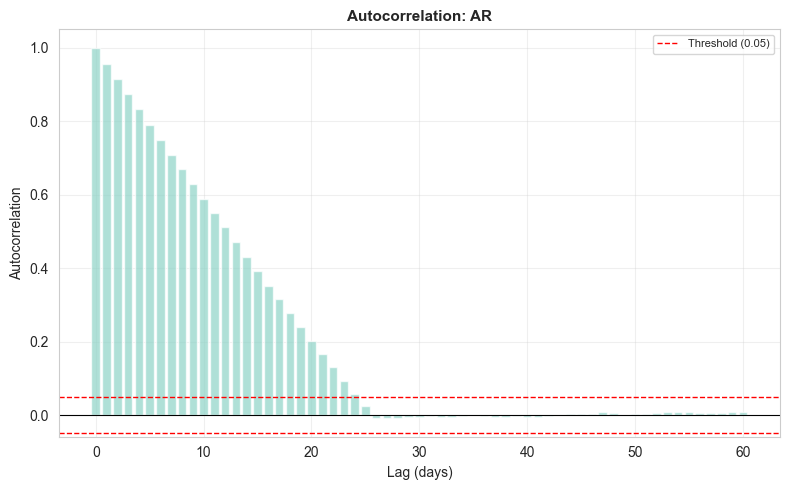

  Optimal lag: 24 days (autocorr = 0.0561)

Analyzing autocorrelation: BR


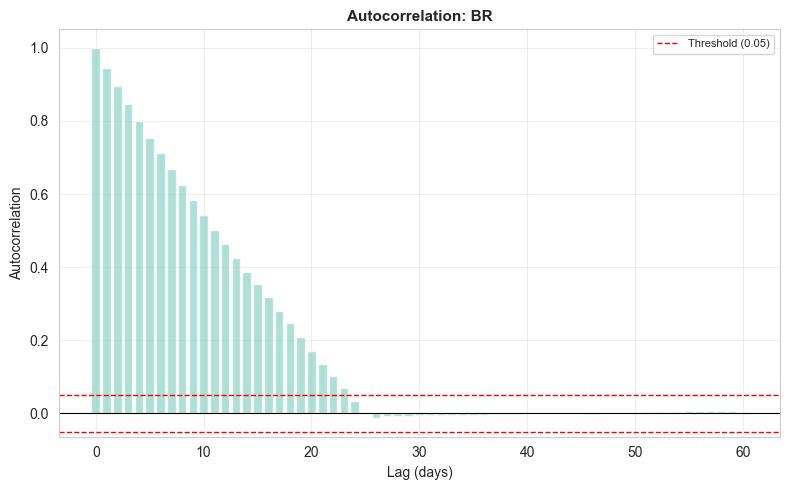

  Optimal lag: 23 days (autocorr = 0.0694)

Analyzing autocorrelation: WAD_cumsum


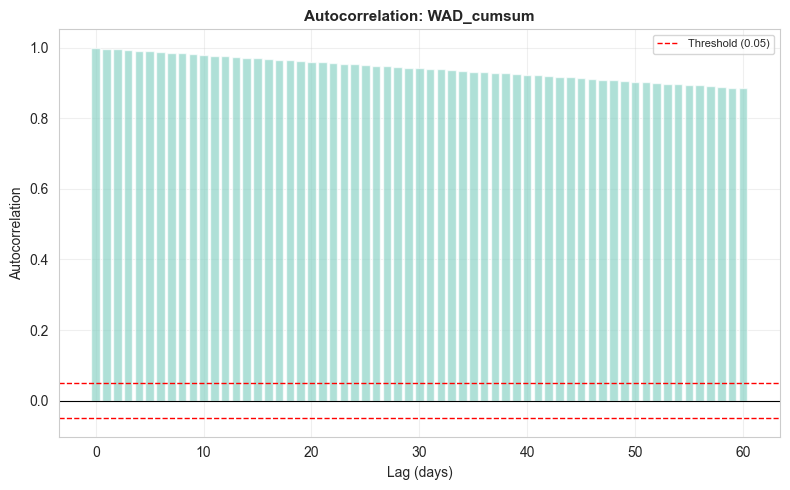

  Optimal lag: 60 days (autocorr = 0.8854)

Analyzing autocorrelation: MOBV


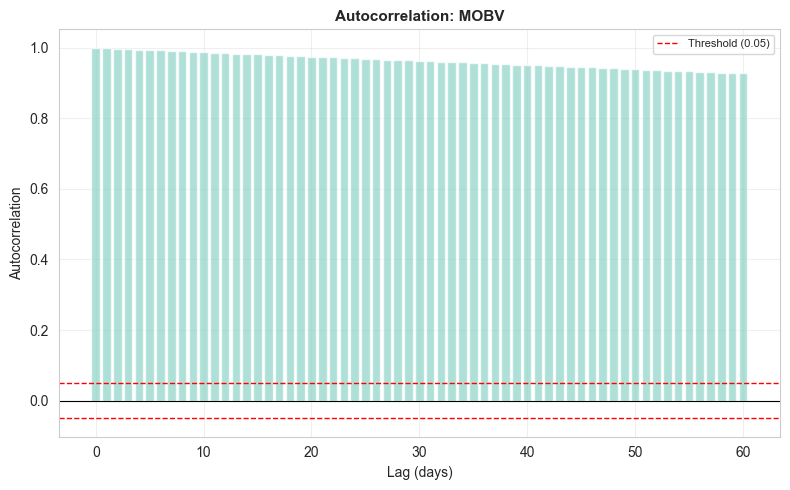

  Optimal lag: 60 days (autocorr = 0.9276)

Analyzing autocorrelation: PVT_cumsum


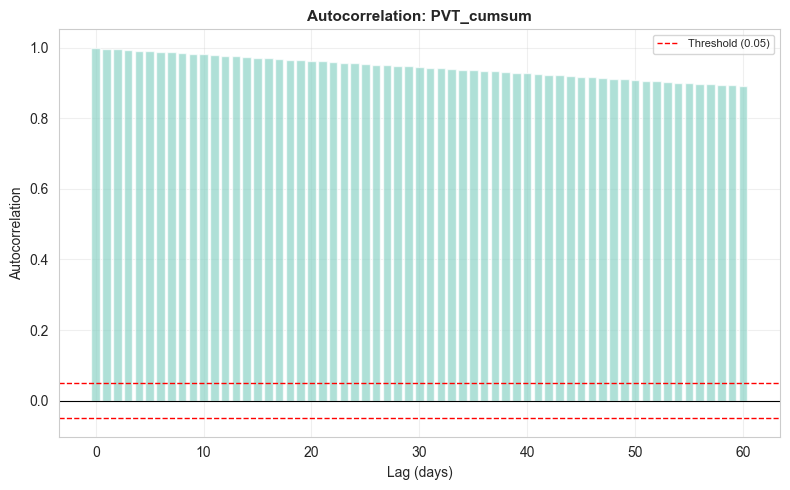

  Optimal lag: 60 days (autocorr = 0.8919)

Analyzing autocorrelation: WVAD


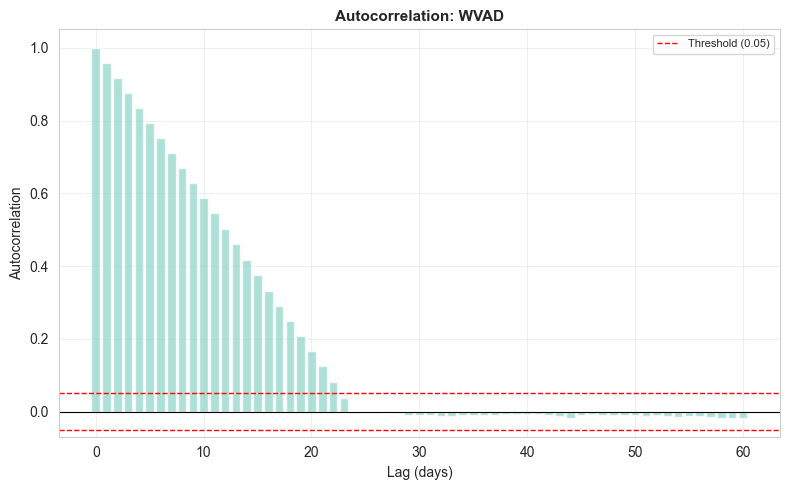

  Optimal lag: 22 days (autocorr = 0.0807)

Analyzing autocorrelation: BBI


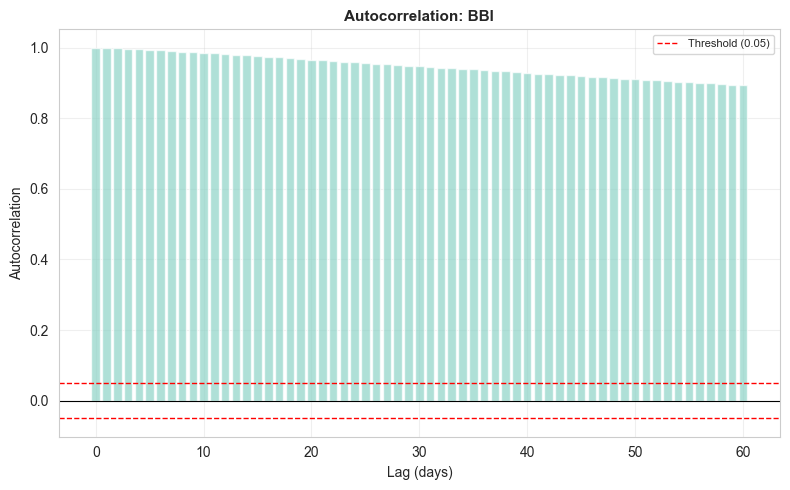

  Optimal lag: 60 days (autocorr = 0.8944)

Analyzing autocorrelation: EXPMA_12


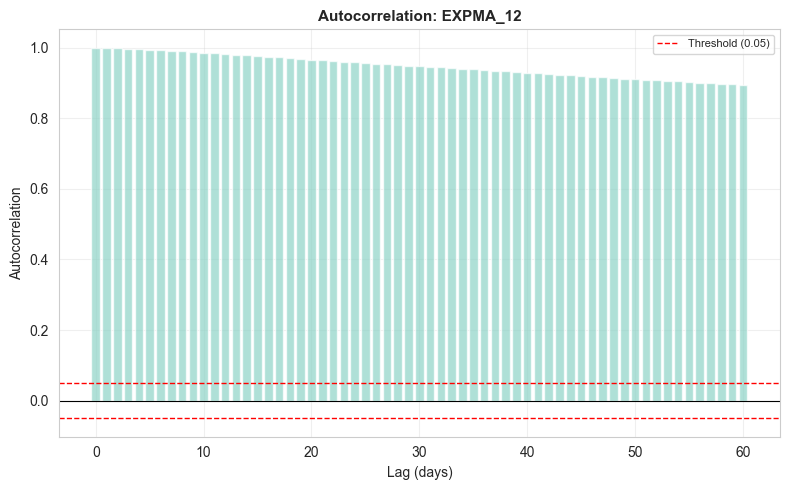

  Optimal lag: 60 days (autocorr = 0.8945)

Analyzing autocorrelation: EXPMA_50


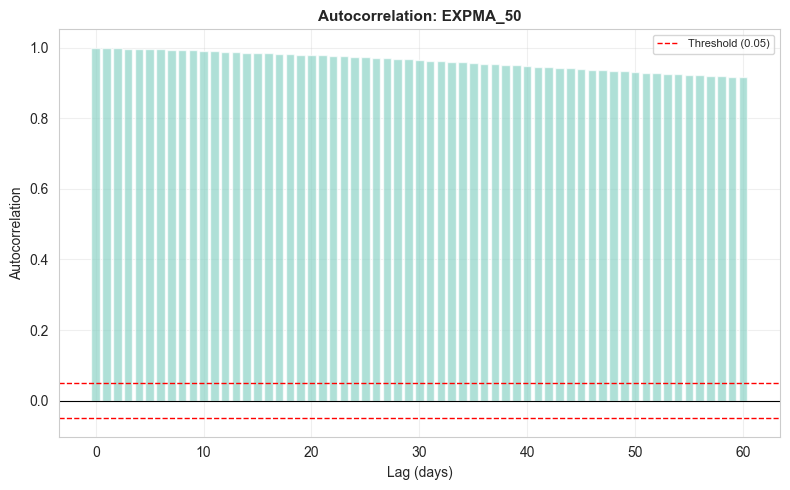

  Optimal lag: 60 days (autocorr = 0.9160)

Analyzing autocorrelation: MACD_histogram


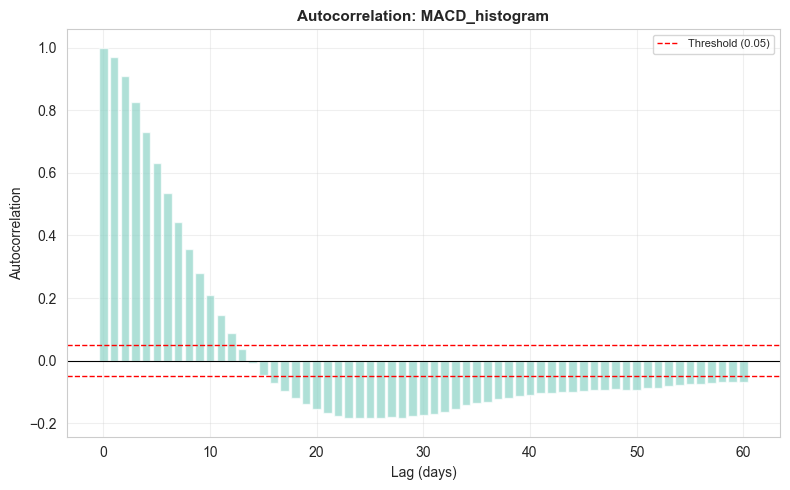

  Optimal lag: 60 days (autocorr = -0.0673)

Analyzing autocorrelation: MTM


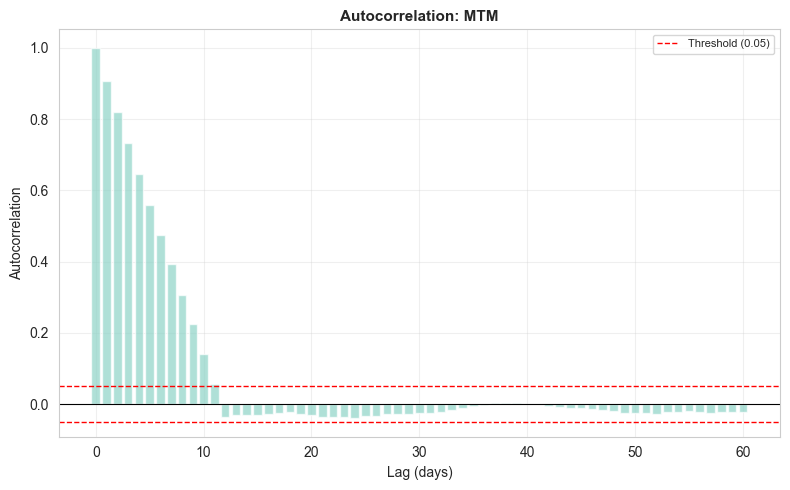

  Optimal lag: 11 days (autocorr = 0.0557)

Analyzing autocorrelation: PRICEOSC


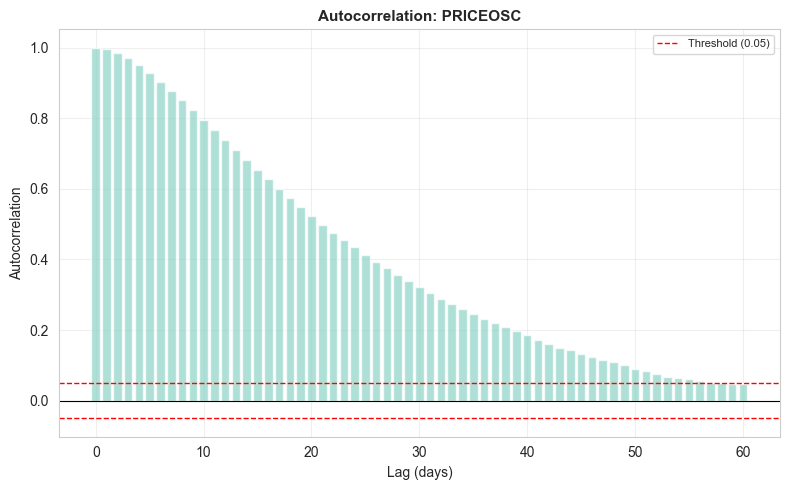

  Optimal lag: 56 days (autocorr = 0.0551)

Analyzing autocorrelation: TRIX


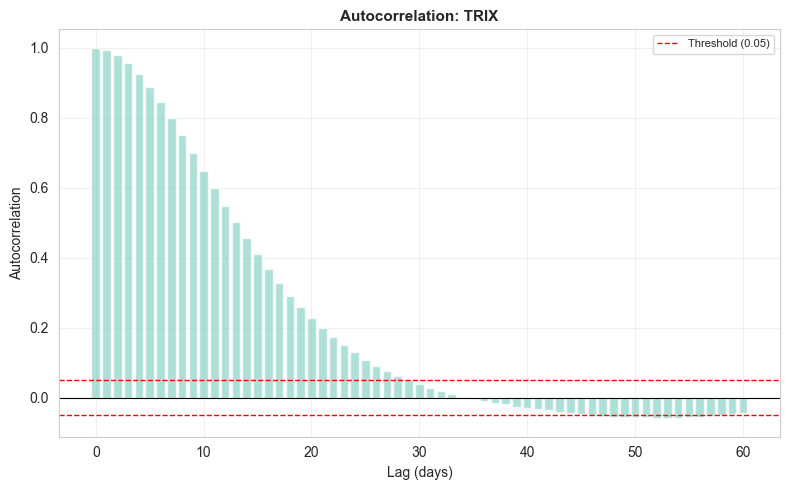

  Optimal lag: 57 days (autocorr = -0.0507)

Analyzing autocorrelation: CCI


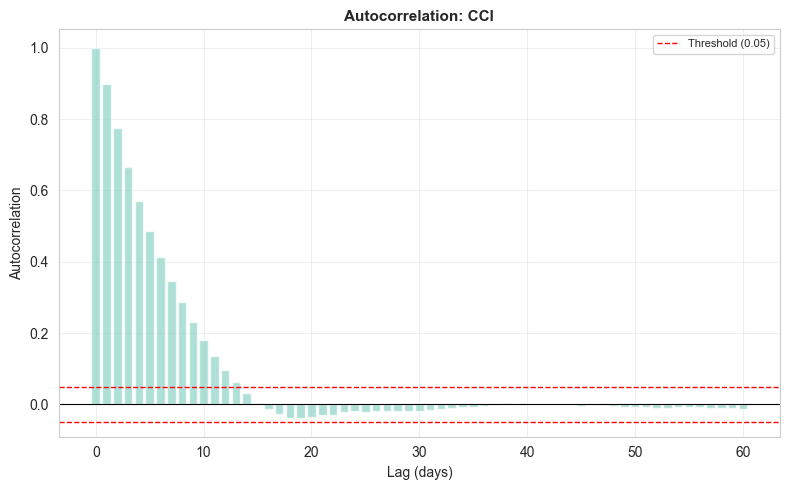

  Optimal lag: 13 days (autocorr = 0.0619)

Analyzing autocorrelation: DBCD


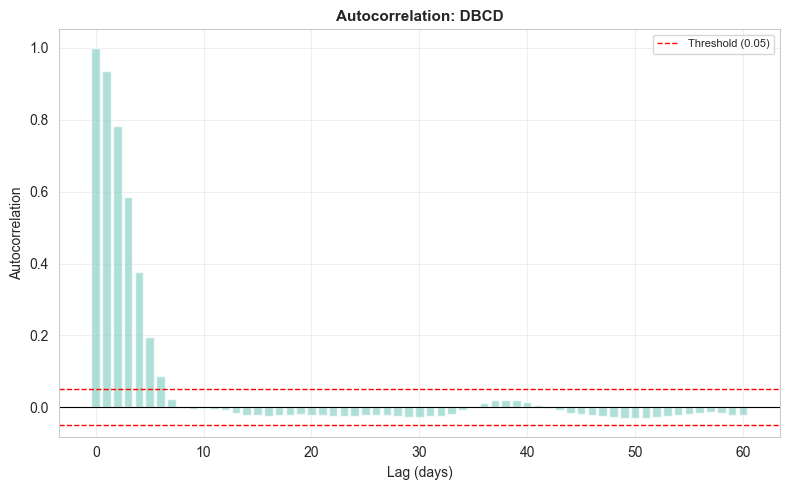

  Optimal lag: 6 days (autocorr = 0.0865)

Analyzing autocorrelation: DPO


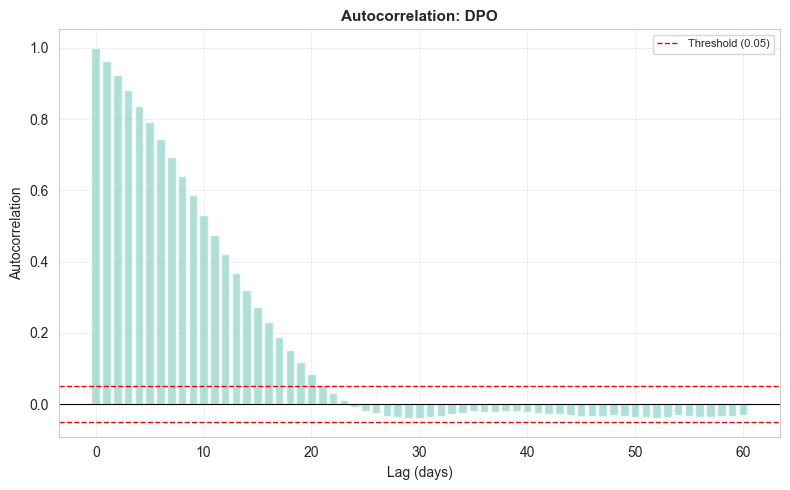

  Optimal lag: 21 days (autocorr = 0.0547)

Analyzing autocorrelation: K


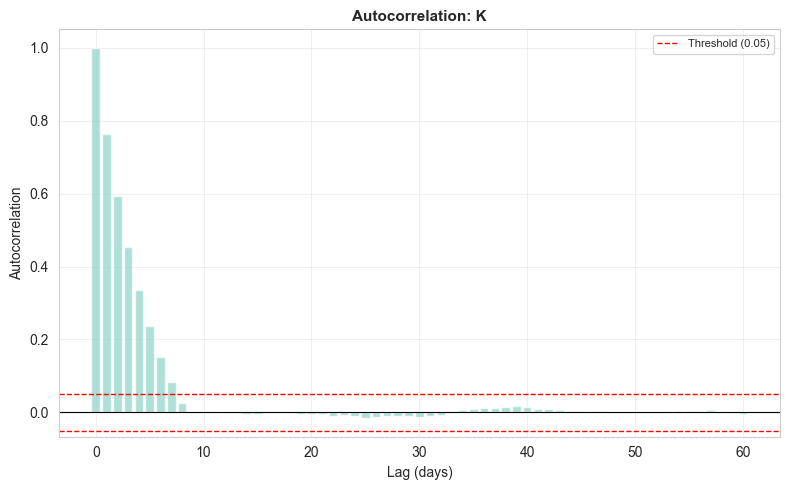

  Optimal lag: 7 days (autocorr = 0.0827)

Analyzing autocorrelation: D


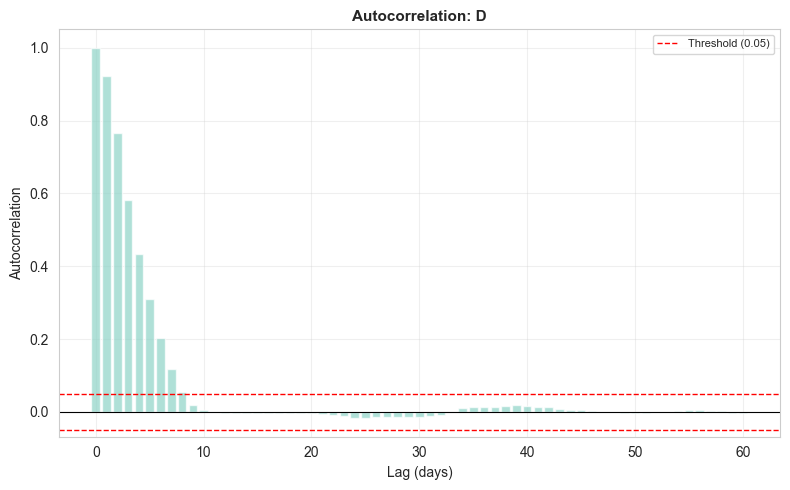

  Optimal lag: 8 days (autocorr = 0.0538)

Analyzing autocorrelation: J


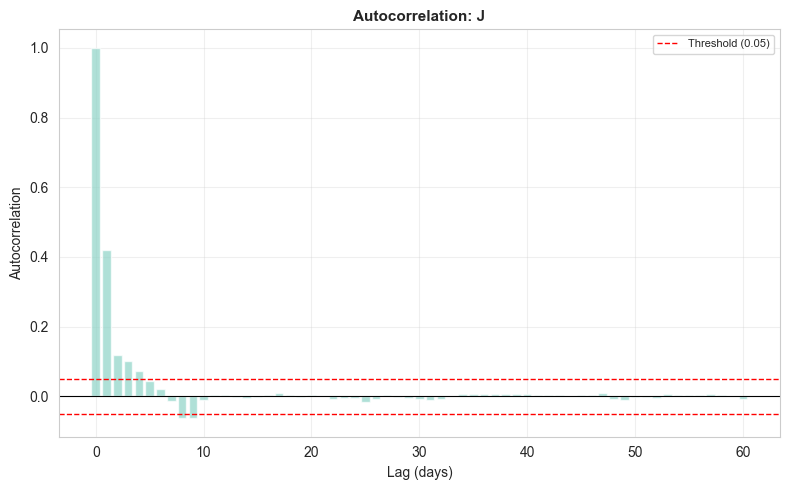

  Optimal lag: 9 days (autocorr = -0.0625)

Analyzing autocorrelation: SRDM


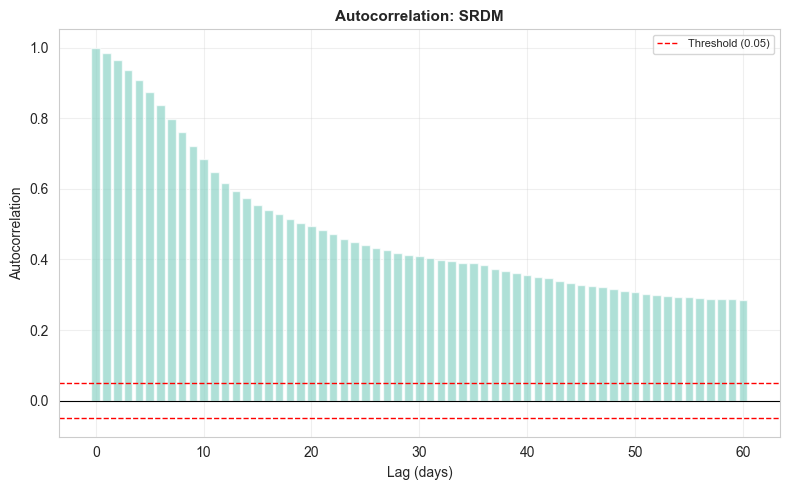

  Optimal lag: 60 days (autocorr = 0.2850)

Analyzing autocorrelation: VROC


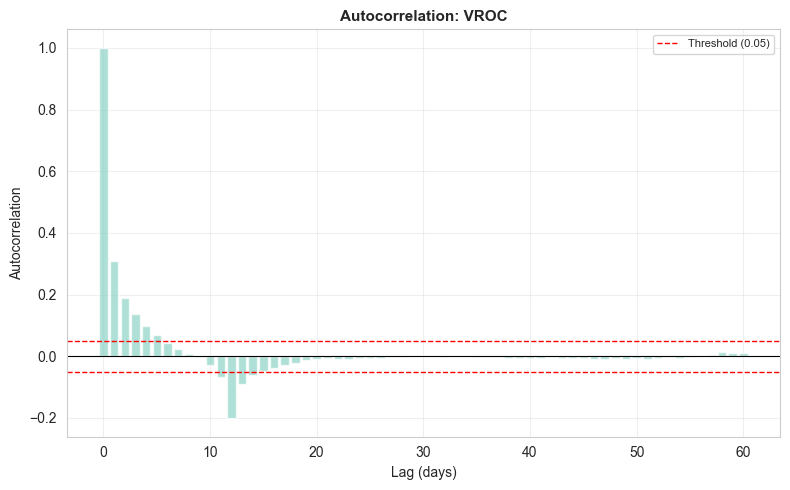

  Optimal lag: 14 days (autocorr = -0.0605)

Analyzing autocorrelation: VRSI


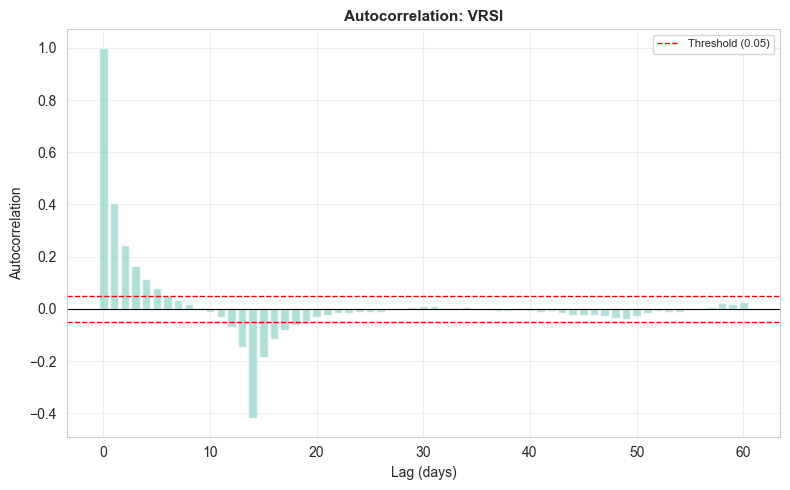

  Optimal lag: 18 days (autocorr = -0.0627)

Analyzing autocorrelation: WR


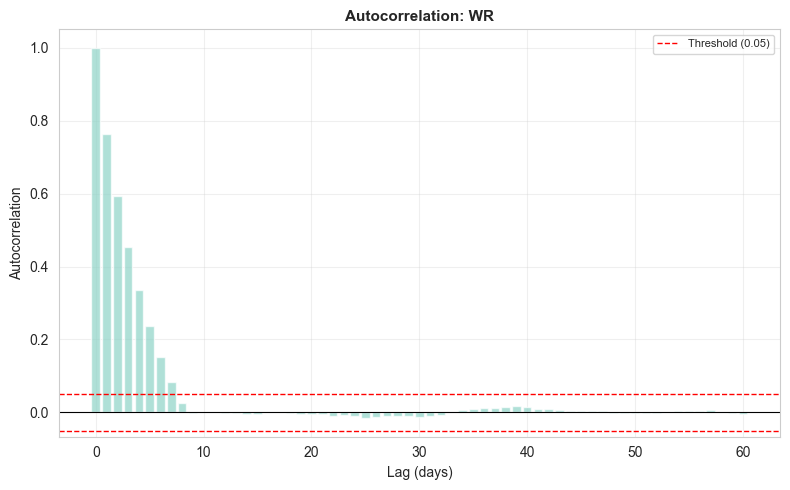

  Optimal lag: 7 days (autocorr = 0.0827)

Analyzing autocorrelation: ADTM


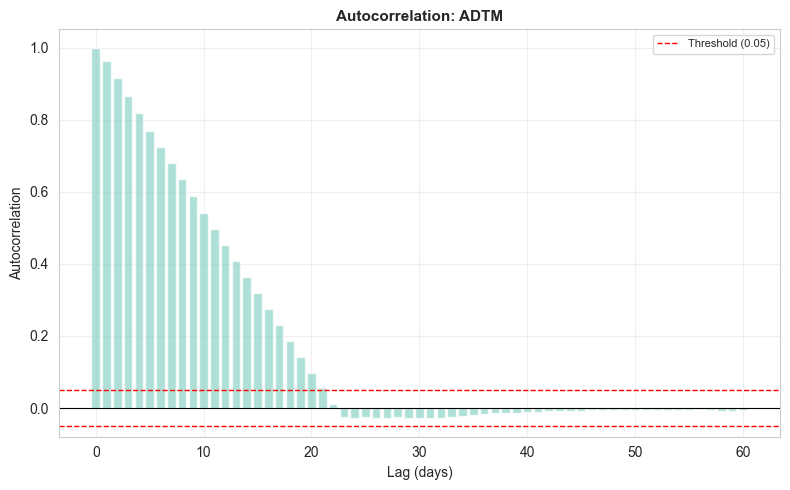

  Optimal lag: 21 days (autocorr = 0.0542)

Analyzing autocorrelation: CDP_AH


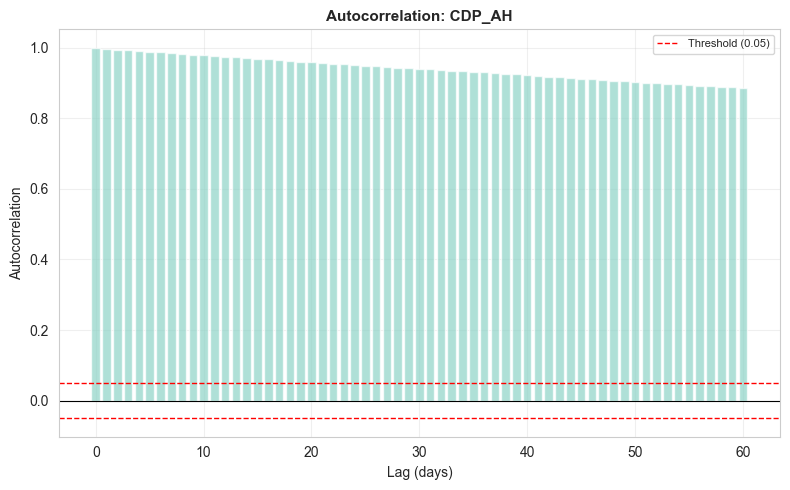

  Optimal lag: 60 days (autocorr = 0.8867)

Analyzing autocorrelation: CDP_AL


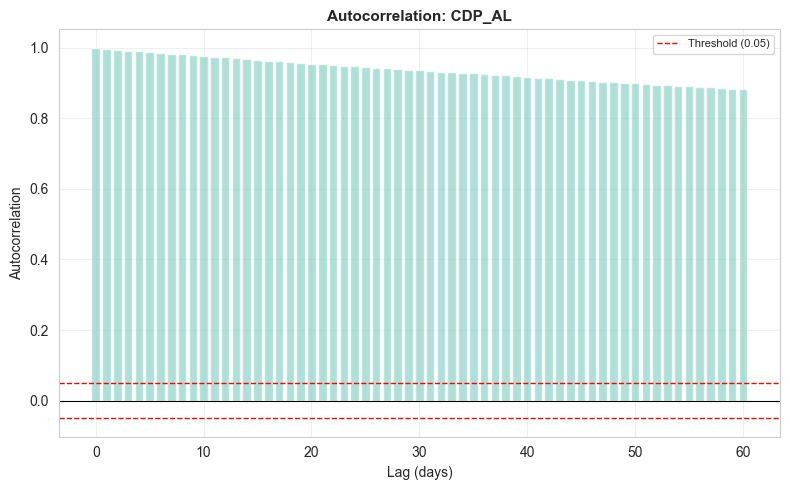

  Optimal lag: 60 days (autocorr = 0.8829)

Analyzing autocorrelation: CDP_NH


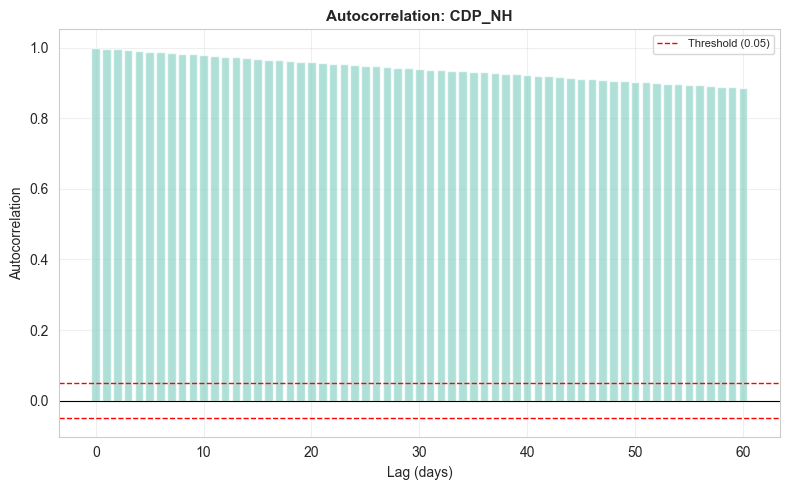

  Optimal lag: 60 days (autocorr = 0.8867)

Analyzing autocorrelation: CDP_NL


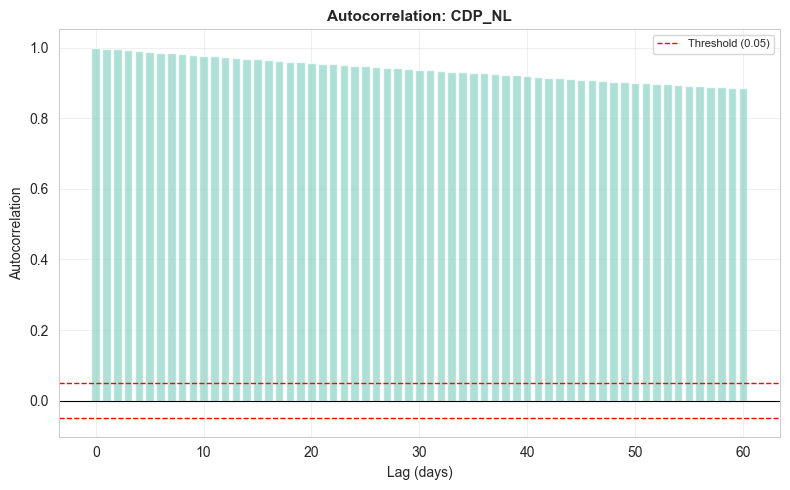

  Optimal lag: 60 days (autocorr = 0.8852)

Analyzing autocorrelation: MI


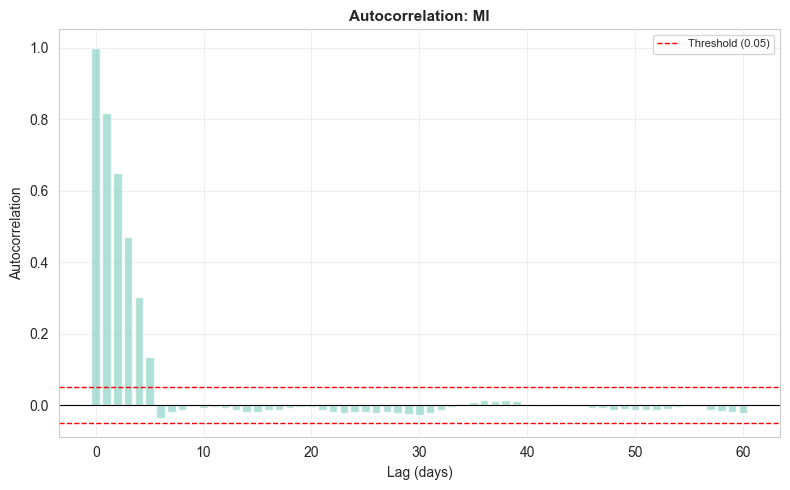

  Optimal lag: 5 days (autocorr = 0.1354)

Analyzing autocorrelation: MICD


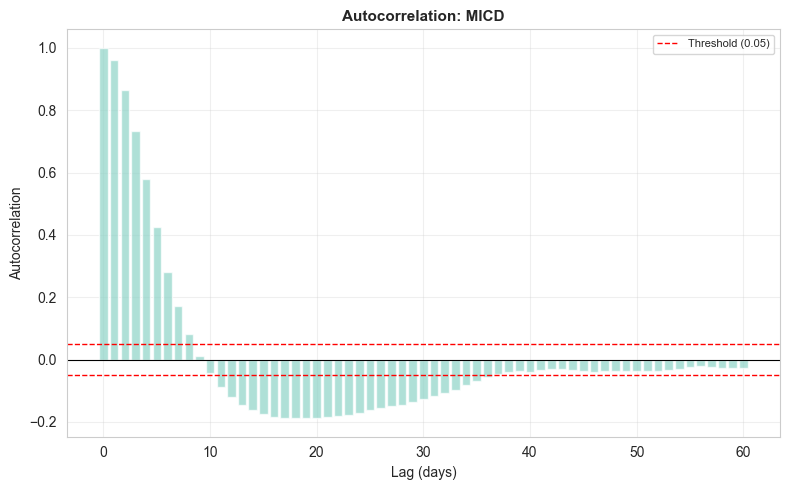

  Optimal lag: 36 days (autocorr = -0.0548)

Analyzing autocorrelation: RC


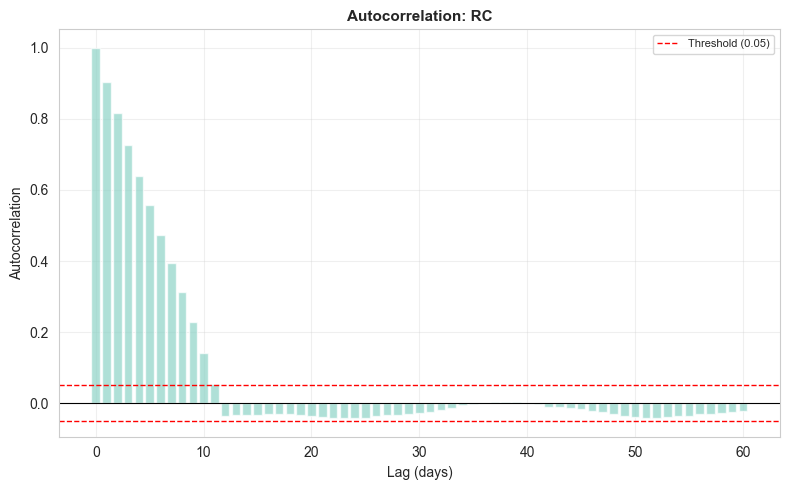

  Optimal lag: 11 days (autocorr = 0.0552)

Analyzing autocorrelation: RCCD


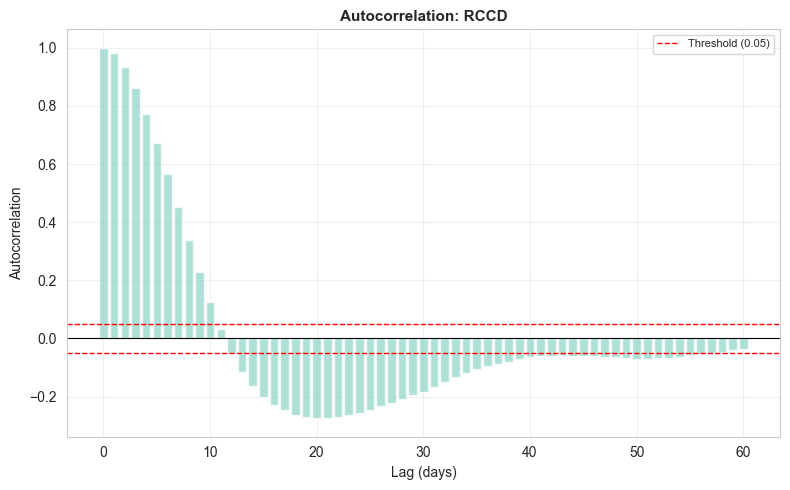

  Optimal lag: 57 days (autocorr = -0.0513)

Analyzing autocorrelation: SRMI


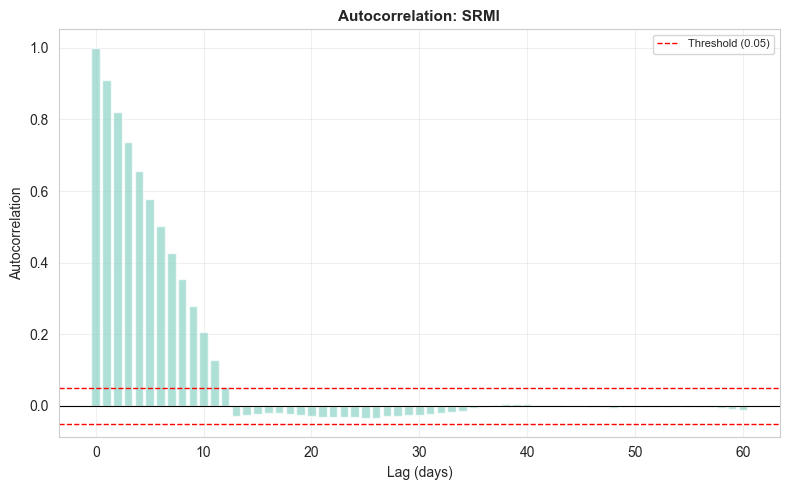

  Optimal lag: 12 days (autocorr = 0.0532)

Analyzing autocorrelation: CVLT


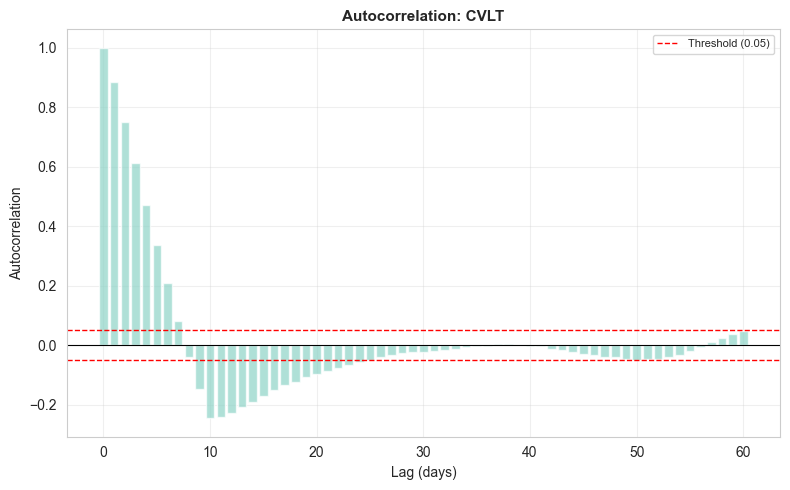

  Optimal lag: 24 days (autocorr = -0.0565)

Analyzing autocorrelation: MASS


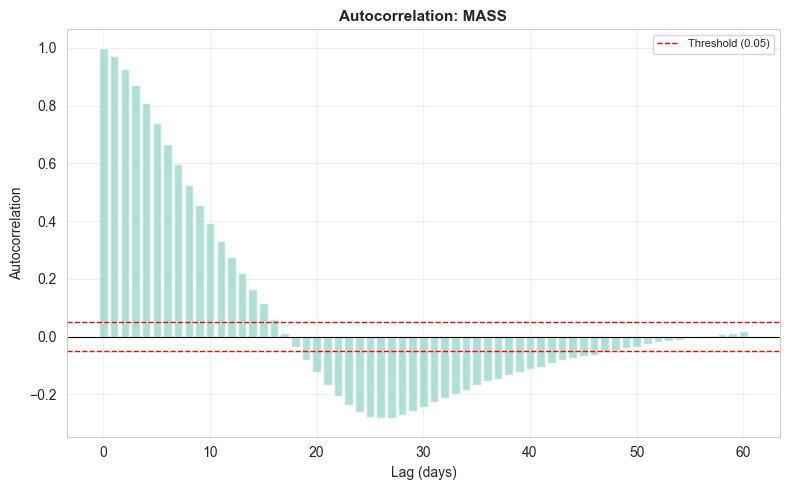

  Optimal lag: 47 days (autocorr = -0.0533)

Analyzing autocorrelation: STD_20


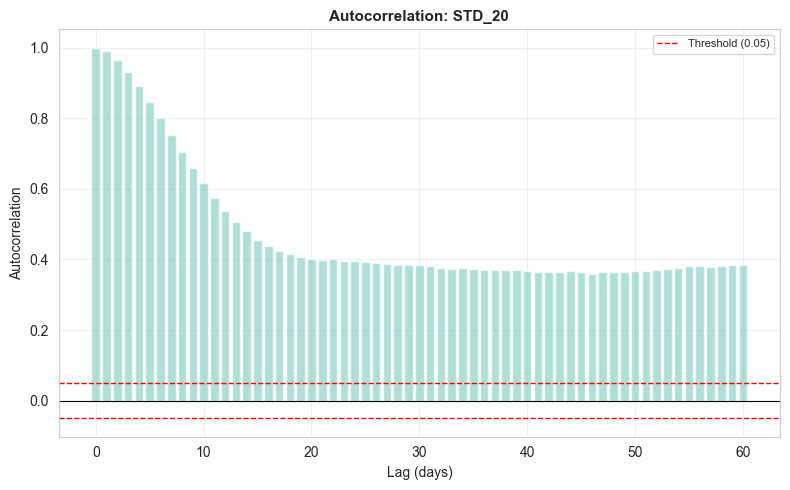

  Optimal lag: 60 days (autocorr = 0.3837)

Analyzing autocorrelation: VHF


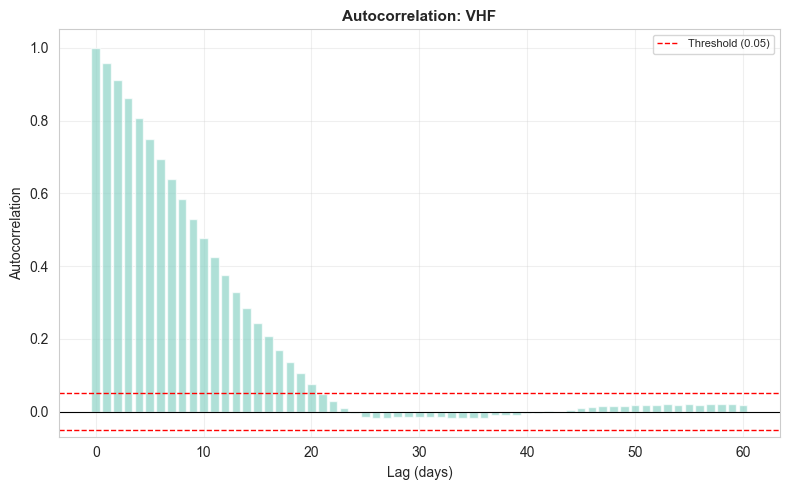

  Optimal lag: 20 days (autocorr = 0.0751)

AUTOCORRELATION DECAY SUMMARY
       Feature    Lag_10    Lag_20    Lag_30  Decay_Point
           QRR -0.005438  0.005358  0.005518            2
          TAPI -0.004442  0.006621  0.005552            2
          VOSC -0.058747 -0.269257 -0.015941           27
          VSTD  0.580197  0.154146  0.126936           60
    VMACD_hist -0.179401 -0.104521 -0.014261            6
            CR  0.438454  0.094864 -0.026668           22
           PSY  0.165234 -0.005995 -0.002346           12
            VR  0.552592  0.188783 -0.002014           25
            AR  0.588620  0.202565 -0.004329           25
            BR  0.542756  0.171777 -0.005684           24
    WAD_cumsum  0.980214  0.960516  0.942348           60
          MOBV  0.987532  0.975315  0.963563           60
    PVT_cumsum  0.981335  0.963274  0.945420           60
          WVAD  0.587407  0.166847 -0.010119           23
           BBI  0.985892  0.966808  0.947816           6

In [10]:

# ============================================================================
# SECTION 4: AUTOCORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[4] AUTOCORRELATION ANALYSIS")
print("="*80)
print("Analyzing how each feature correlates with its past values")
print("This helps determine optimal sequence length for RNN")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 200    # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60             # Analyze up to 60 days lag
threshold = 0.05

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = (
    df_features['ticker']
    .dropna()
    .unique()[:NUM_TICKERS_TO_USE]
)

df_sample = (
    df_features
    .loc[df_features['ticker'].isin(selected_tickers)]
    .dropna(subset=feature_columns)
)

# ----------------------------------------------------------------------------
# AUTOCORRELATION COMPUTATION
# ----------------------------------------------------------------------------
autocorr_results = {}
# feature_columns = [
#     'daily_return', 'high_low_ratio', 'return_30',
#     #'MA_5', 'MA_10', 'MA_30', 'STD_10',
#     'log_volume', 'volume_ratio'
#     #, 'dividend_yield'
# ]

for feature in feature_columns:
    print(f"\nAnalyzing autocorrelation: {feature}")

    per_ticker_acfs = []

    for ticker, g in df_sample.groupby('ticker'):
        data = g[feature].dropna()

        if len(data) <= max_lags:
            continue

        autocorr_values = acf(data, nlags=max_lags, fft=True)
        per_ticker_acfs.append(autocorr_values)

    if len(per_ticker_acfs) == 0:
        print("  Not enough data")
        continue

    # Aggregate across tickers (median preserves typical temporal behavior)
    autocorr_values = np.median(per_ticker_acfs, axis=0)
    autocorr_results[feature] = autocorr_values

    # ----------------------------------------------------------------------------
    # PLOT (single plot per feature)
    # ----------------------------------------------------------------------------
    plt.figure(figsize=(8, 5))
    lags = np.arange(len(autocorr_values))

    plt.bar(lags, autocorr_values, width=0.8, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1, label='Threshold (0.05)')
    plt.axhline(y=-threshold, color='red', linestyle='--', linewidth=1)

    plt.title(f'Autocorrelation: {feature}', fontsize=11, fontweight='bold')
    plt.xlabel('Lag (days)')
    plt.ylabel('Autocorrelation')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, f'autocorrelation_{feature}.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # ----------------------------------------------------------------------------
    # FIND OPTIMAL LAG
    # ----------------------------------------------------------------------------
    significant_lags = np.where(np.abs(autocorr_values) > threshold)[0]

    if len(significant_lags) > 1:
        optimal_lag = significant_lags[-1]
        print(f"  Optimal lag: {optimal_lag} days (autocorr = {autocorr_values[optimal_lag]:.4f})")
    else:
        print(f"  low autocorrelation (independent)")

# ----------------------------------------------------------------------------
# SUMMARY TABLE OF AUTOCORRELATION DECAY
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("AUTOCORRELATION DECAY SUMMARY")
print("="*80)

decay_summary = []

for feature, autocorr_vals in autocorr_results.items():
    below_threshold = np.where(np.abs(autocorr_vals[1:]) < threshold)[0]

    if len(below_threshold) > 0:
        decay_lag = below_threshold[0] + 1
    else:
        decay_lag = max_lags

    decay_summary.append({
        'Feature': feature,
        'Lag_10': autocorr_vals[10],
        'Lag_20': autocorr_vals[20],
        'Lag_30': autocorr_vals[30],
        'Decay_Point': decay_lag
    })

decay_df = pd.DataFrame(decay_summary)
print(decay_df.to_string(index=False))



[5] TARGET-LAG CORRELATION ANALYSIS
Analyzing correlation between lagged features and target variable

Total features: 45
Plots per figure: 12
Number of figures to create: 4

Analyzing target correlation: QRR (1/45)
  Peak correlation: 0.0081 at lag 3

Analyzing target correlation: TAPI (2/45)
  Peak correlation: 0.0074 at lag 2

Analyzing target correlation: VOSC (3/45)
  Peak correlation: -0.0285 at lag 50

Analyzing target correlation: VSTD (4/45)
  Peak correlation: 0.0289 at lag 1

Analyzing target correlation: VMACD_hist (5/45)
  Peak correlation: -0.0175 at lag 60

Analyzing target correlation: CR (6/45)
  Peak correlation: -0.0198 at lag 38

Analyzing target correlation: PSY (7/45)
  Peak correlation: -0.0317 at lag 15

Analyzing target correlation: VR (8/45)
  Peak correlation: -0.0206 at lag 24

Analyzing target correlation: AR (9/45)
  Peak correlation: -0.0200 at lag 9

Analyzing target correlation: BR (10/45)
  Peak correlation: -0.0173 at lag 60

Analyzing target correla

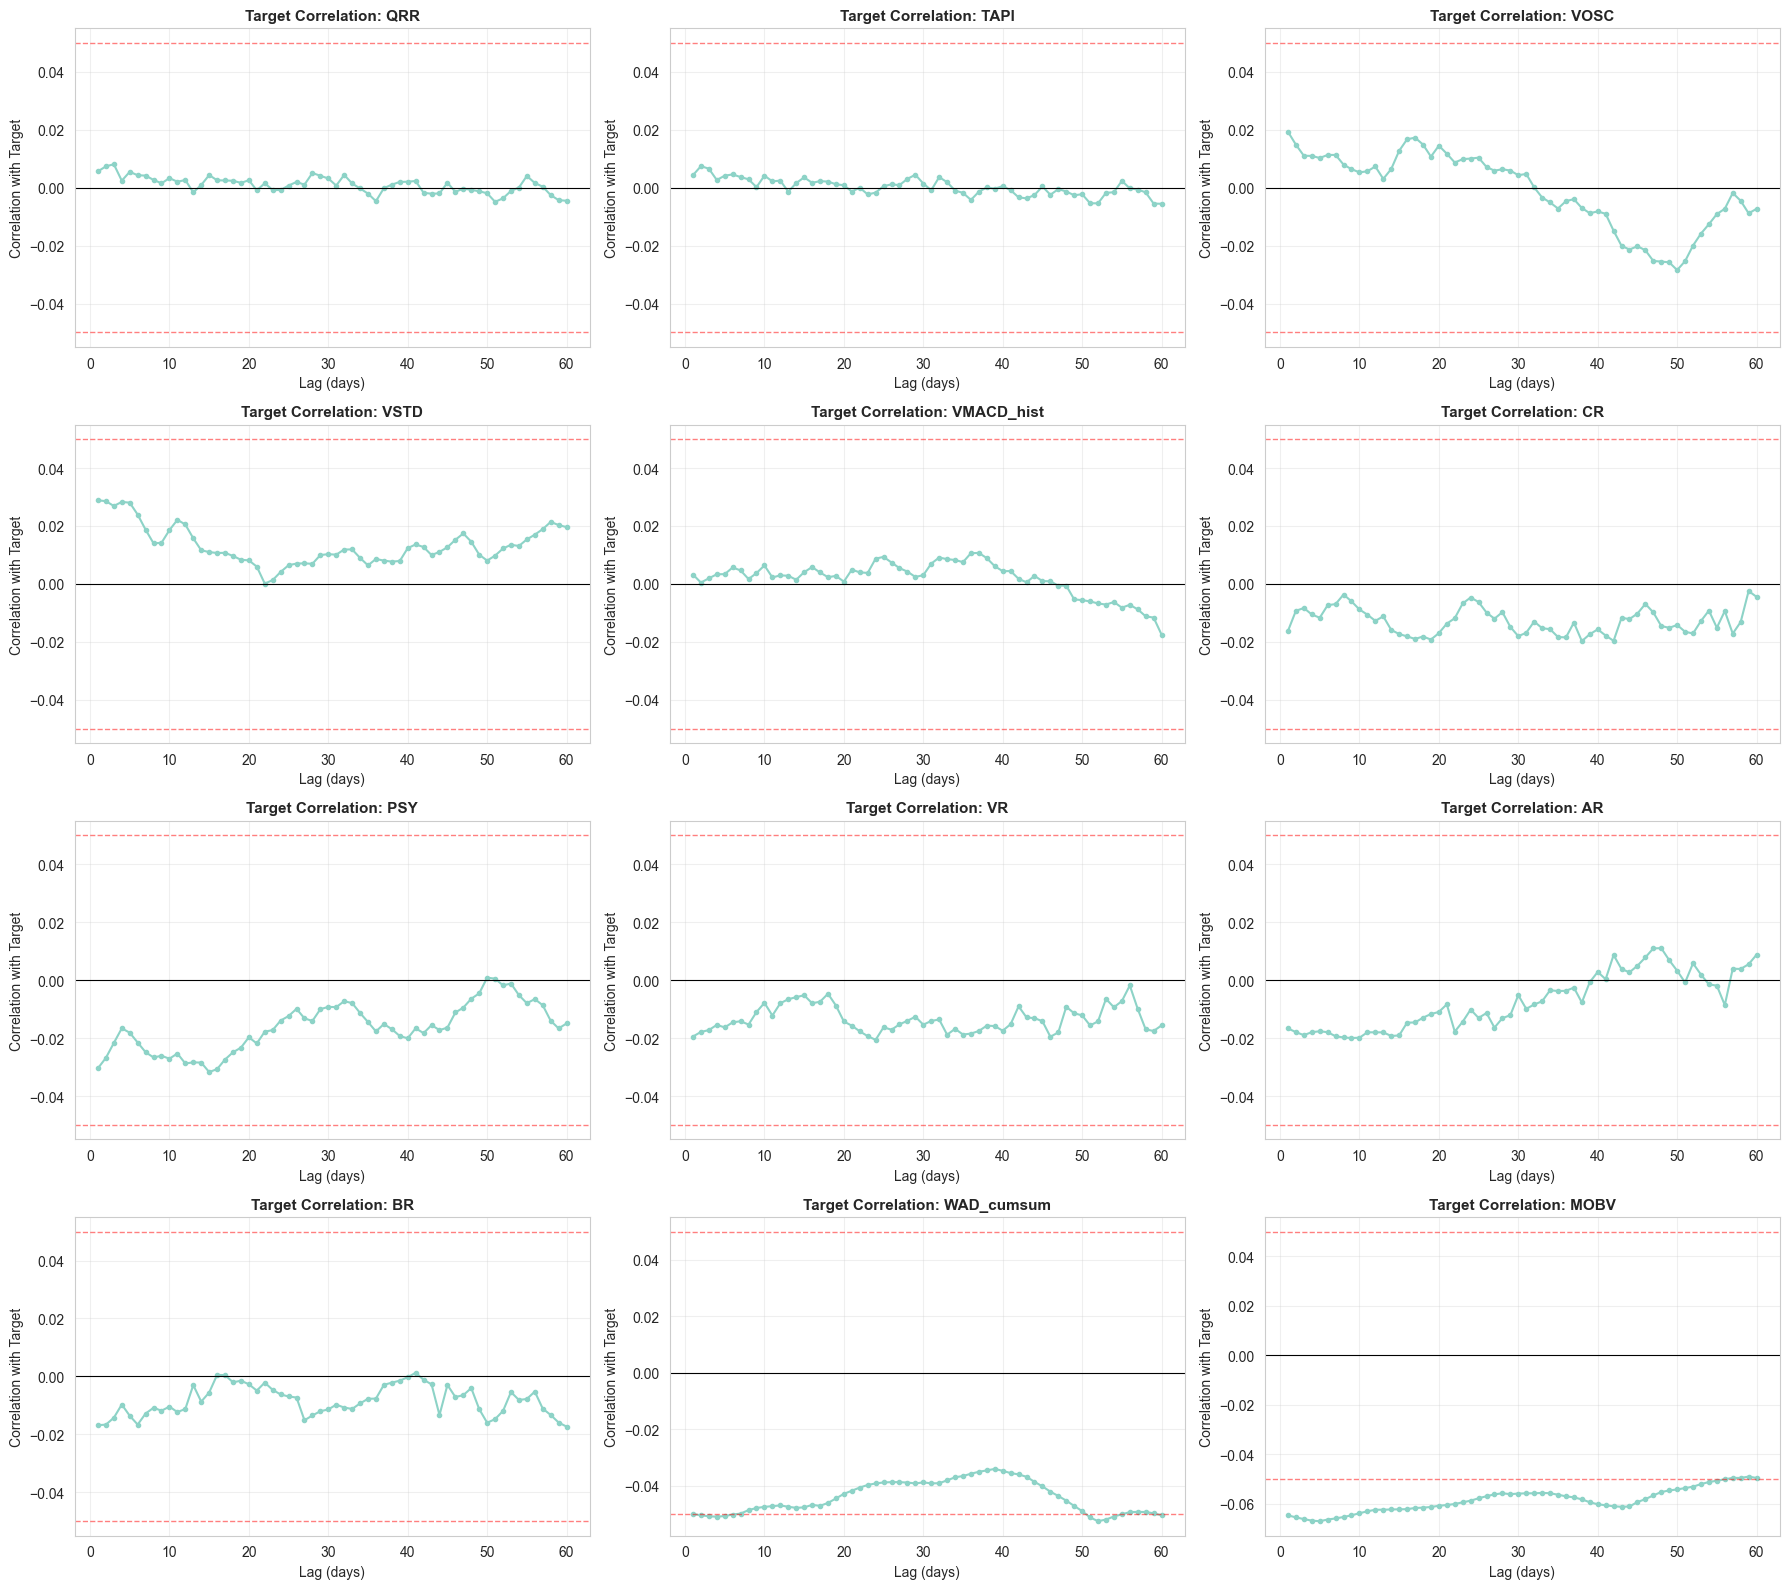


Analyzing target correlation: PVT_cumsum (13/45)
  Peak correlation: -0.0640 at lag 1

Analyzing target correlation: WVAD (14/45)
  Peak correlation: -0.0414 at lag 28

Analyzing target correlation: BBI (15/45)
  Peak correlation: -0.1253 at lag 5

Analyzing target correlation: EXPMA_12 (16/45)
  Peak correlation: -0.1254 at lag 5

Analyzing target correlation: EXPMA_50 (17/45)
  Peak correlation: -0.1228 at lag 4

Analyzing target correlation: MACD_histogram (18/45)
  Peak correlation: -0.0245 at lag 60

Analyzing target correlation: MTM (19/45)
  Peak correlation: -0.0333 at lag 38

Analyzing target correlation: PRICEOSC (20/45)
  Peak correlation: -0.0614 at lag 7

Analyzing target correlation: TRIX (21/45)
  Peak correlation: -0.0489 at lag 12

Analyzing target correlation: CCI (22/45)
  Peak correlation: -0.0284 at lag 27

Analyzing target correlation: DBCD (23/45)
  Peak correlation: 0.0287 at lag 38

Analyzing target correlation: DPO (24/45)
  Peak correlation: -0.0497 at lag 3

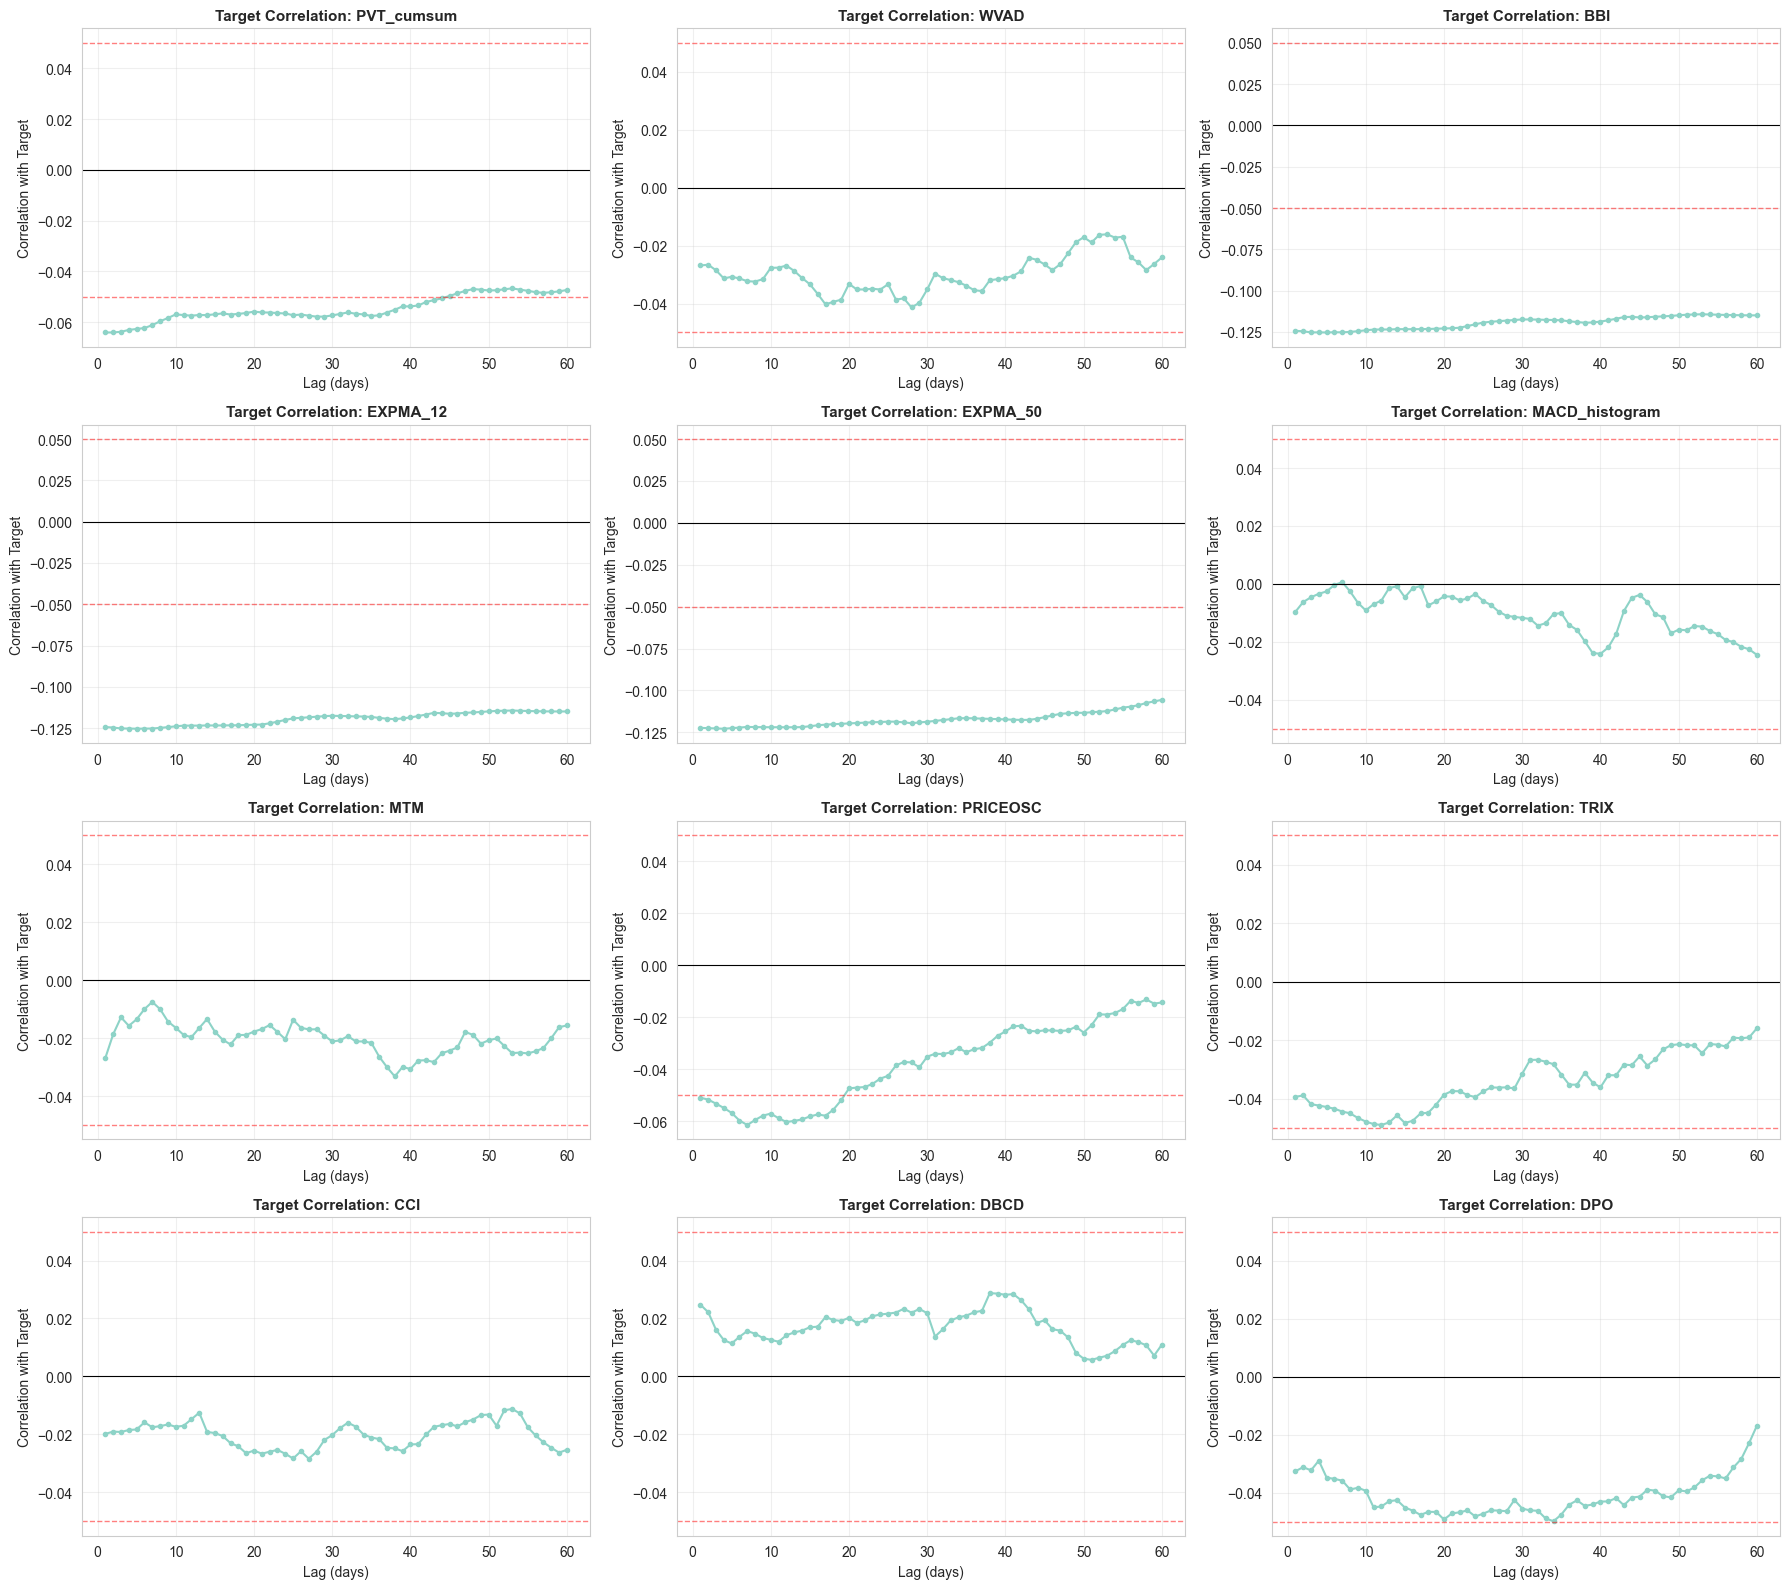


Analyzing target correlation: K (25/45)
  Peak correlation: -0.0247 at lag 1

Analyzing target correlation: D (26/45)
  Peak correlation: -0.0247 at lag 1

Analyzing target correlation: J (27/45)
  Peak correlation: -0.0179 at lag 3

Analyzing target correlation: SRDM (28/45)
  Peak correlation: 0.0334 at lag 24

Analyzing target correlation: VROC (29/45)
  Peak correlation: 0.0143 at lag 1

Analyzing target correlation: VRSI (30/45)
  Peak correlation: -0.0130 at lag 52

Analyzing target correlation: WR (31/45)
  Peak correlation: -0.0247 at lag 1

Analyzing target correlation: ADTM (32/45)
  Peak correlation: -0.0347 at lag 16

Analyzing target correlation: CDP_AH (33/45)
  Peak correlation: -0.1235 at lag 4

Analyzing target correlation: CDP_AL (34/45)
  Peak correlation: -0.1231 at lag 13

Analyzing target correlation: CDP_NH (35/45)
  Peak correlation: -0.1233 at lag 5

Analyzing target correlation: CDP_NL (36/45)
  Peak correlation: -0.1232 at lag 13

✓ Saved: 03_target_lag_corr

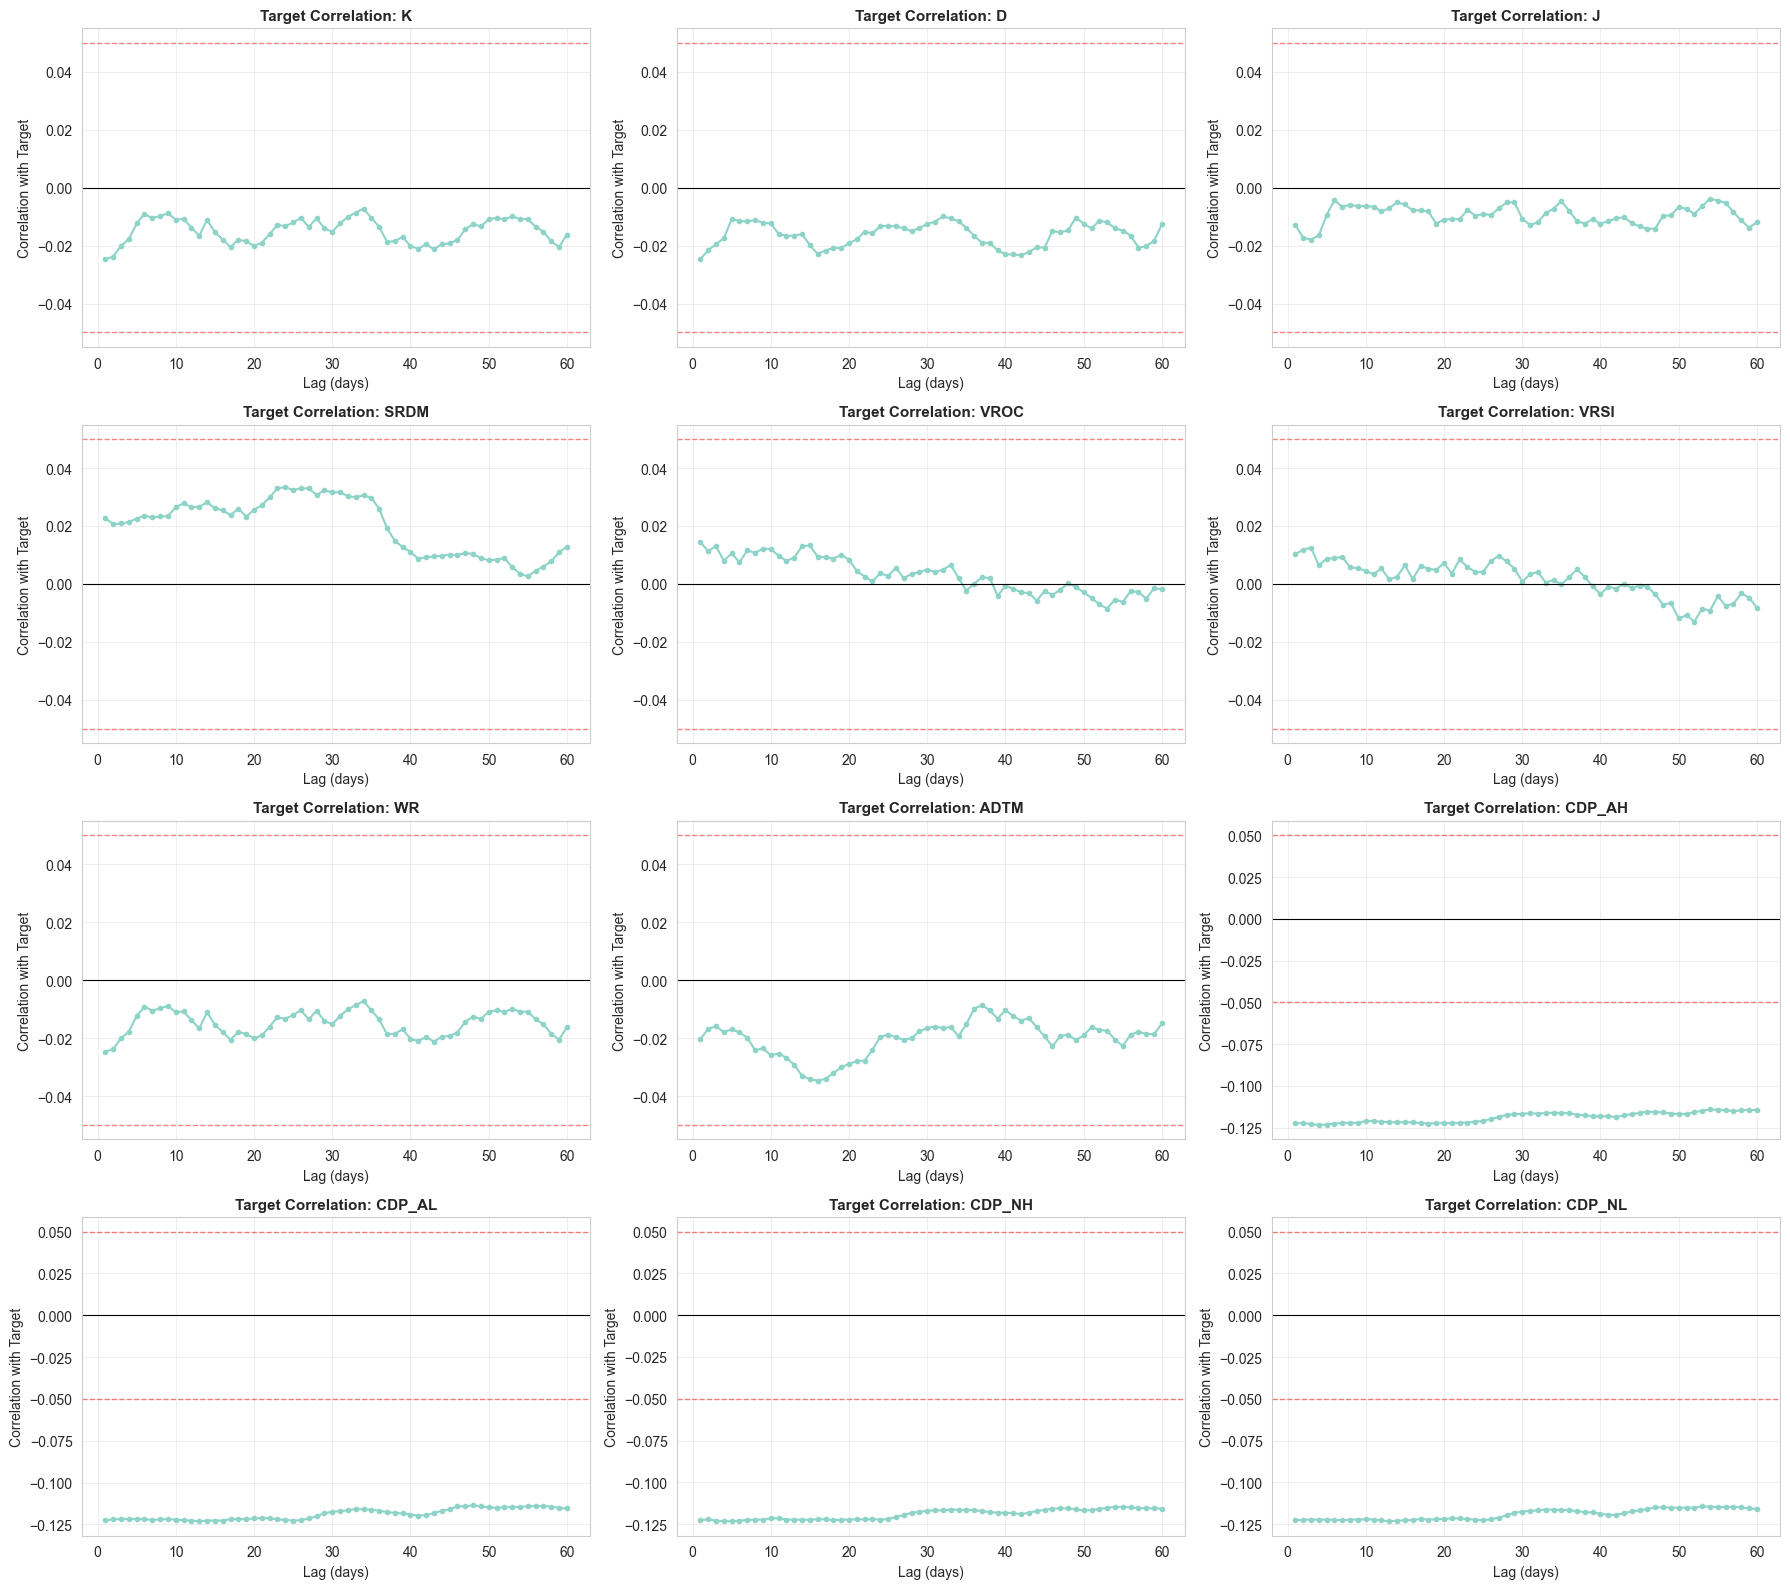


Analyzing target correlation: MI (37/45)
  Peak correlation: -0.0232 at lag 43

Analyzing target correlation: MICD (38/45)
  Peak correlation: -0.0239 at lag 42

Analyzing target correlation: RC (39/45)
  Peak correlation: -0.0292 at lag 19

Analyzing target correlation: RCCD (40/45)
  Peak correlation: -0.0247 at lag 38

Analyzing target correlation: SRMI (41/45)
  Peak correlation: -0.0249 at lag 36

Analyzing target correlation: CVLT (42/45)
  Peak correlation: -0.0157 at lag 44

Analyzing target correlation: MASS (43/45)
  Peak correlation: -0.0429 at lag 38

Analyzing target correlation: STD_20 (44/45)
  Peak correlation: -0.0551 at lag 15

Analyzing target correlation: VHF (45/45)
  Peak correlation: -0.0268 at lag 57

✓ Saved: 03_target_lag_correlation_part4.png


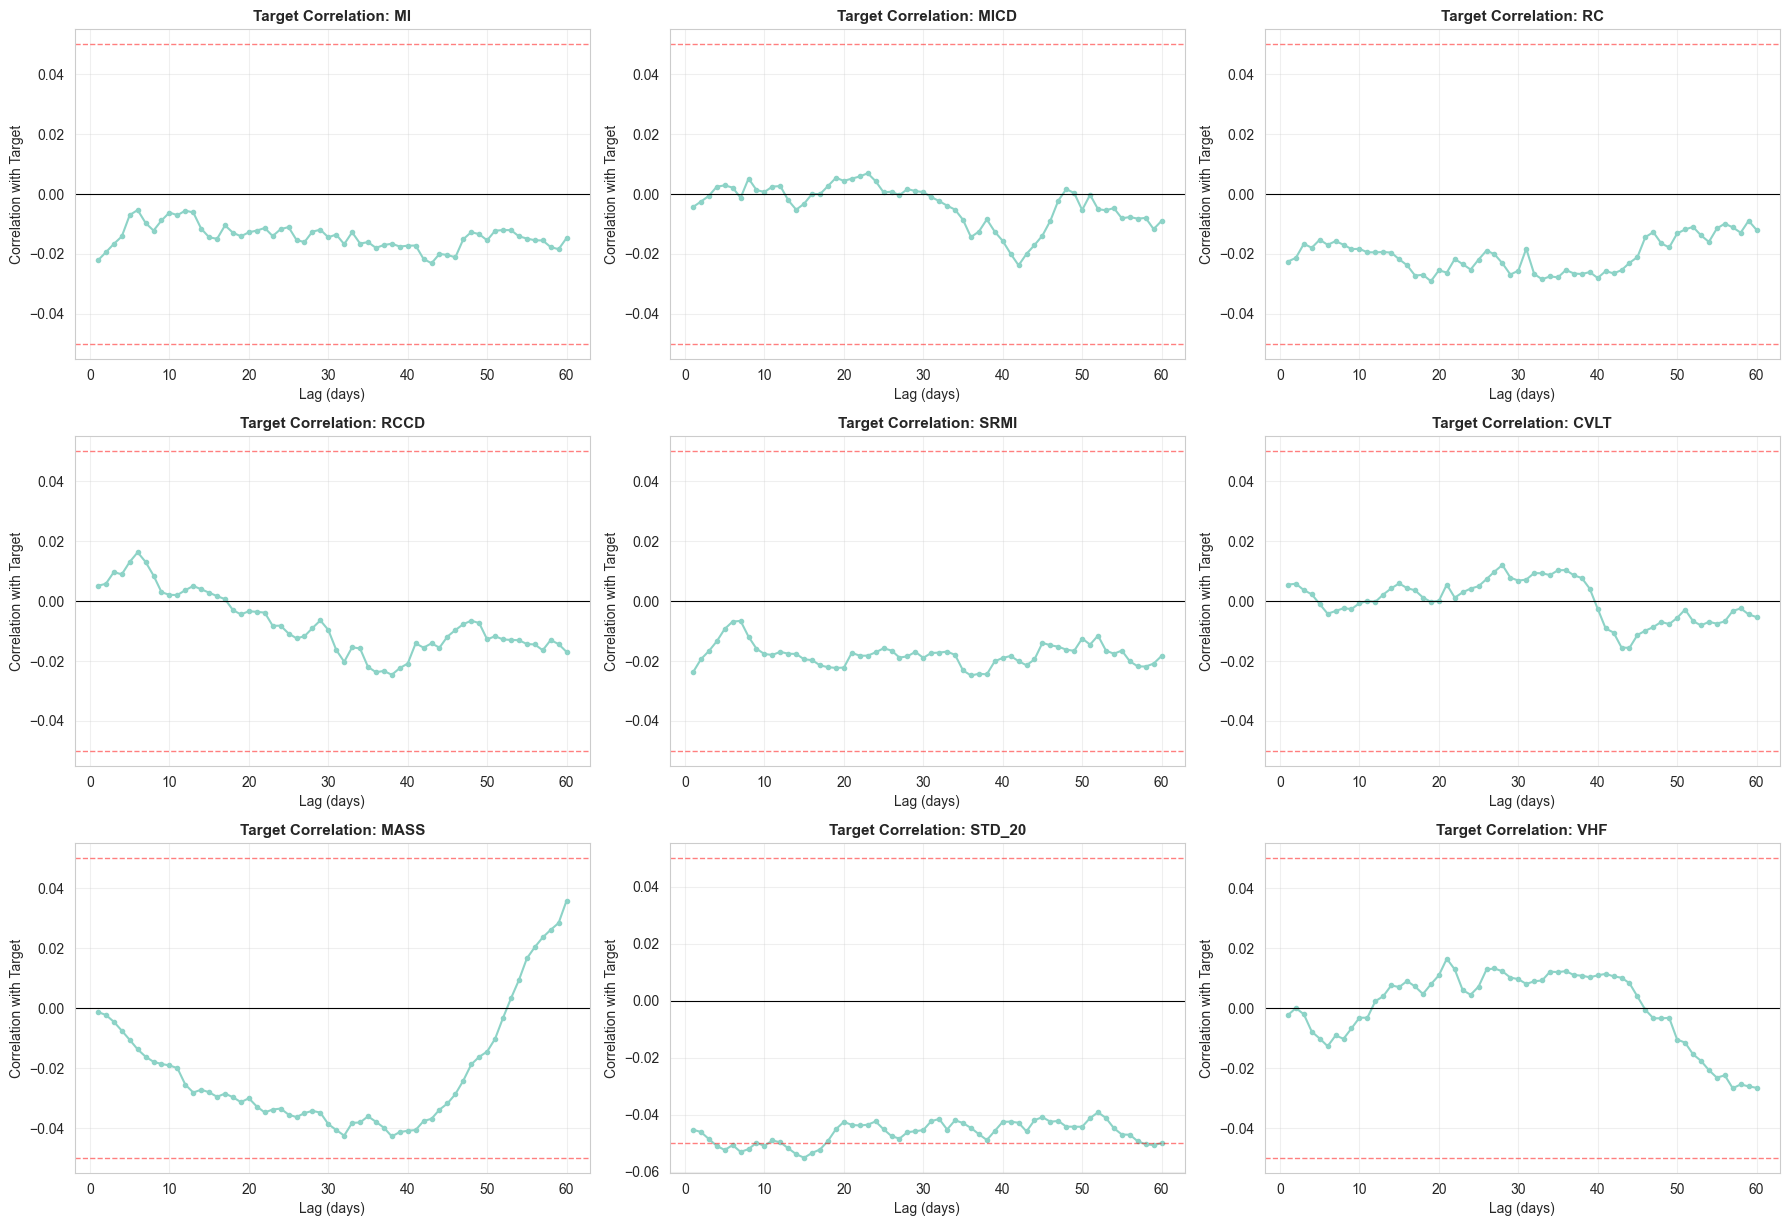


✓ Analysis complete! Created 4 figure(s)


In [11]:
# ============================================================================
# SECTION 5: TARGET-LAG CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[5] TARGET-LAG CORRELATION ANALYSIS")
print("="*80)
print("Analyzing correlation between lagged features and target variable")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50  # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60            # Should match SECTION 4 for consistency
PLOTS_PER_FIGURE = 12    # Number of subplots per figure (4x3 grid)

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# TARGET-LAG CORRELATION COMPUTATION
# ----------------------------------------------------------------------------
target_lag_results = {}

# Calculate how many figures we need
num_features = len(feature_columns)
num_figures = int(np.ceil(num_features / PLOTS_PER_FIGURE))

print(f"\nTotal features: {num_features}")
print(f"Plots per figure: {PLOTS_PER_FIGURE}")
print(f"Number of figures to create: {num_figures}")

# Initialize first figure
fig_idx = 0
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
plot_idx_in_figure = 0

for feature_idx, feature in enumerate(feature_columns):
    print(f"\nAnalyzing target correlation: {feature} ({feature_idx+1}/{num_features})")

    correlations_per_lag = []

    # For each lag
    for lag in range(1, max_lags + 1):

        # Compute correlation per ticker
        per_ticker_corrs = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            lagged_feature = ticker_data[feature].shift(lag)
            valid_mask = ticker_data['target'].notna() & lagged_feature.notna()

            if valid_mask.sum() > 30:  # Need at least 30 samples
                corr = ticker_data.loc[valid_mask, 'target'].corr(lagged_feature[valid_mask])
                per_ticker_corrs.append(corr)

        # Aggregate across tickers (median is robust)
        if len(per_ticker_corrs) > 0:
            correlations_per_lag.append(np.median(per_ticker_corrs))
        else:
            correlations_per_lag.append(0)

    target_lag_results[feature] = correlations_per_lag

    # ----------------------------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------------------------
    axes[plot_idx_in_figure].plot(range(1, max_lags + 1), correlations_per_lag,
                   marker='o', markersize=3, linewidth=1.5)
    axes[plot_idx_in_figure].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[plot_idx_in_figure].axhline(y=0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[plot_idx_in_figure].axhline(y=-0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[plot_idx_in_figure].set_title(f'Target Correlation: {feature}', fontsize=11, fontweight='bold')
    axes[plot_idx_in_figure].set_xlabel('Lag (days)')
    axes[plot_idx_in_figure].set_ylabel('Correlation with Target')
    axes[plot_idx_in_figure].grid(True, alpha=0.3)

    # ----------------------------------------------------------------------------
    # FIND PEAK CORRELATION
    # ----------------------------------------------------------------------------
    max_corr_idx = np.argmax(np.abs(correlations_per_lag))
    max_corr = correlations_per_lag[max_corr_idx]
    print(f"  Peak correlation: {max_corr:.4f} at lag {max_corr_idx + 1}")

    plot_idx_in_figure += 1

    # Check if we need to save current figure and start a new one
    if plot_idx_in_figure == PLOTS_PER_FIGURE or feature_idx == num_features - 1:
        # Hide any unused subplots in the current figure
        for unused_idx in range(plot_idx_in_figure, PLOTS_PER_FIGURE):
            axes[unused_idx].remove()

        plt.tight_layout()
        filename = f'03_target_lag_correlation_part{fig_idx+1}.png'
        plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: {filename}")
        plt.show()

        # Start new figure if there are more features to plot
        if feature_idx < num_features - 1:
            fig_idx += 1
            fig, axes = plt.subplots(4, 3, figsize=(18, 16))
            axes = axes.flatten()
            plot_idx_in_figure = 0

print("\n" + "="*80)
print(f"✓ Analysis complete! Created {fig_idx + 1} figure(s)")
print("="*80)


[6] TARGET-LAG MUTUAL INFORMATION ANALYSIS
Analyzing mutual information between lagged features and binary target

Total features: 45
Plots per figure: 12
Number of figures to create: 4

Analyzing MI with target: QRR (1/45)
  Peak MI: 0.0020 at lag 53

Analyzing MI with target: TAPI (2/45)
  Peak MI: 0.0015 at lag 43

Analyzing MI with target: VOSC (3/45)
  Peak MI: 0.0042 at lag 21

Analyzing MI with target: VSTD (4/45)
  Peak MI: 0.0087 at lag 4

Analyzing MI with target: VMACD_hist (5/45)
  Peak MI: 0.0022 at lag 30

Analyzing MI with target: CR (6/45)
  Peak MI: 0.0036 at lag 38

Analyzing MI with target: PSY (7/45)
  Peak MI: 0.0085 at lag 12

Analyzing MI with target: VR (8/45)
  Peak MI: 0.0030 at lag 17

Analyzing MI with target: AR (9/45)
  Peak MI: 0.0046 at lag 21

Analyzing MI with target: BR (10/45)
  Peak MI: 0.0030 at lag 10

Analyzing MI with target: WAD_cumsum (11/45)
  Peak MI: 0.0381 at lag 1

Analyzing MI with target: MOBV (12/45)
  Peak MI: 0.0209 at lag 14

✓ Sav

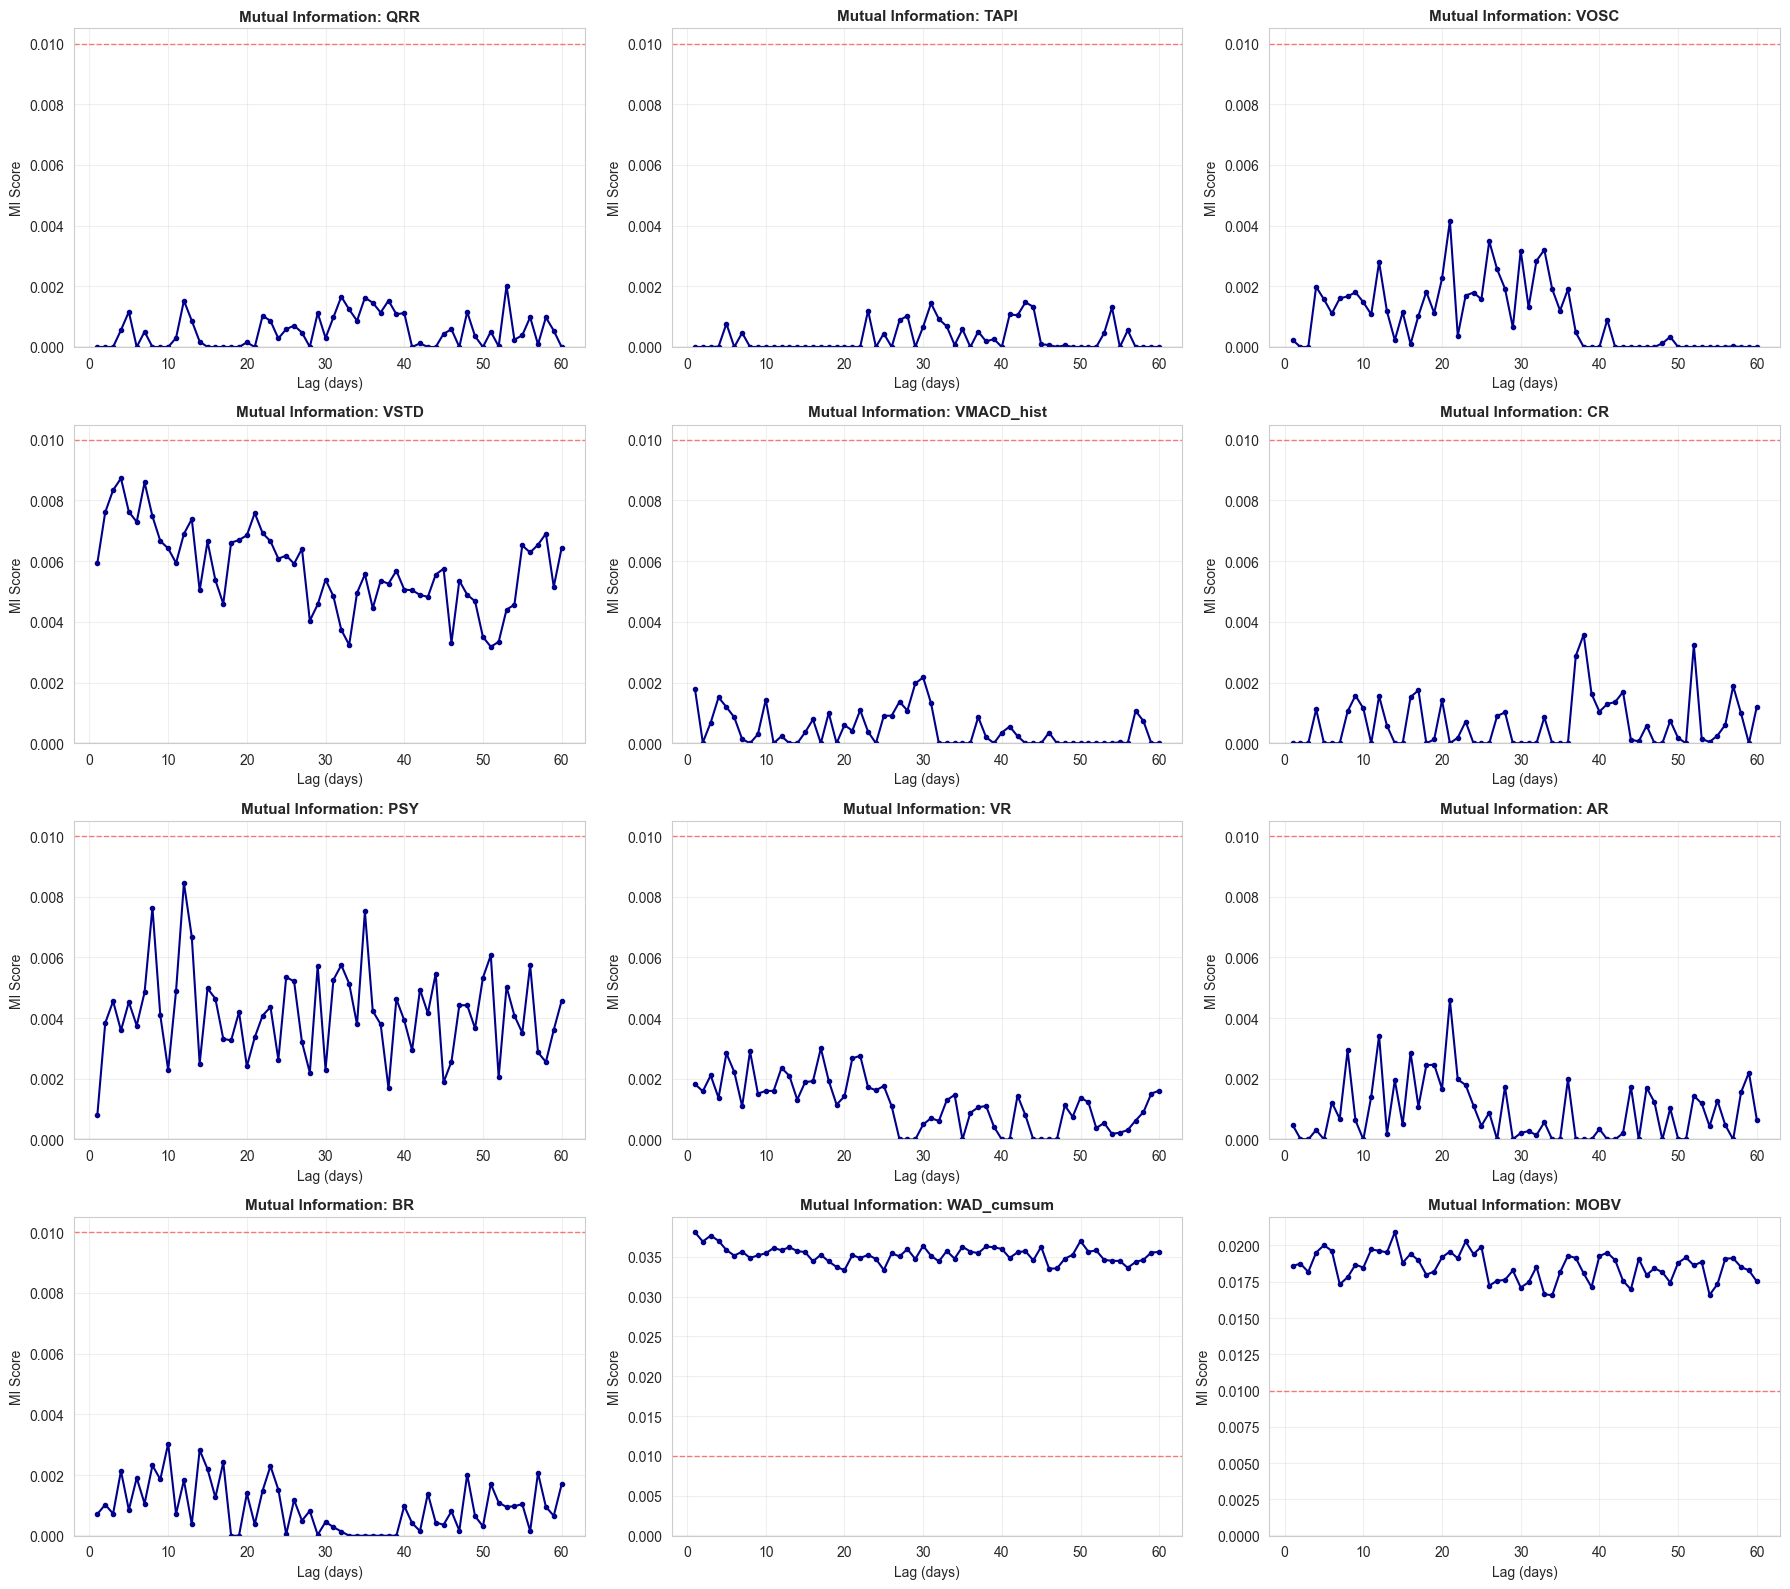


Analyzing MI with target: PVT_cumsum (13/45)
  Peak MI: 0.0426 at lag 1

Analyzing MI with target: WVAD (14/45)
  Peak MI: 0.0060 at lag 2

Analyzing MI with target: BBI (15/45)
  Peak MI: 0.0095 at lag 17

Analyzing MI with target: EXPMA_12 (16/45)
  Peak MI: 0.0095 at lag 11

Analyzing MI with target: EXPMA_50 (17/45)
  Peak MI: 0.0132 at lag 58

Analyzing MI with target: MACD_histogram (18/45)
  Peak MI: 0.0028 at lag 13

Analyzing MI with target: MTM (19/45)
  Peak MI: 0.0127 at lag 25

Analyzing MI with target: PRICEOSC (20/45)
  Peak MI: 0.0025 at lag 46

Analyzing MI with target: TRIX (21/45)
  Peak MI: 0.0036 at lag 19

Analyzing MI with target: CCI (22/45)
  Peak MI: 0.0032 at lag 49

Analyzing MI with target: DBCD (23/45)
  Peak MI: 0.0027 at lag 2

Analyzing MI with target: DPO (24/45)
  Peak MI: 0.0049 at lag 24

✓ Saved: 04_target_lag_mutual_information_part2.png


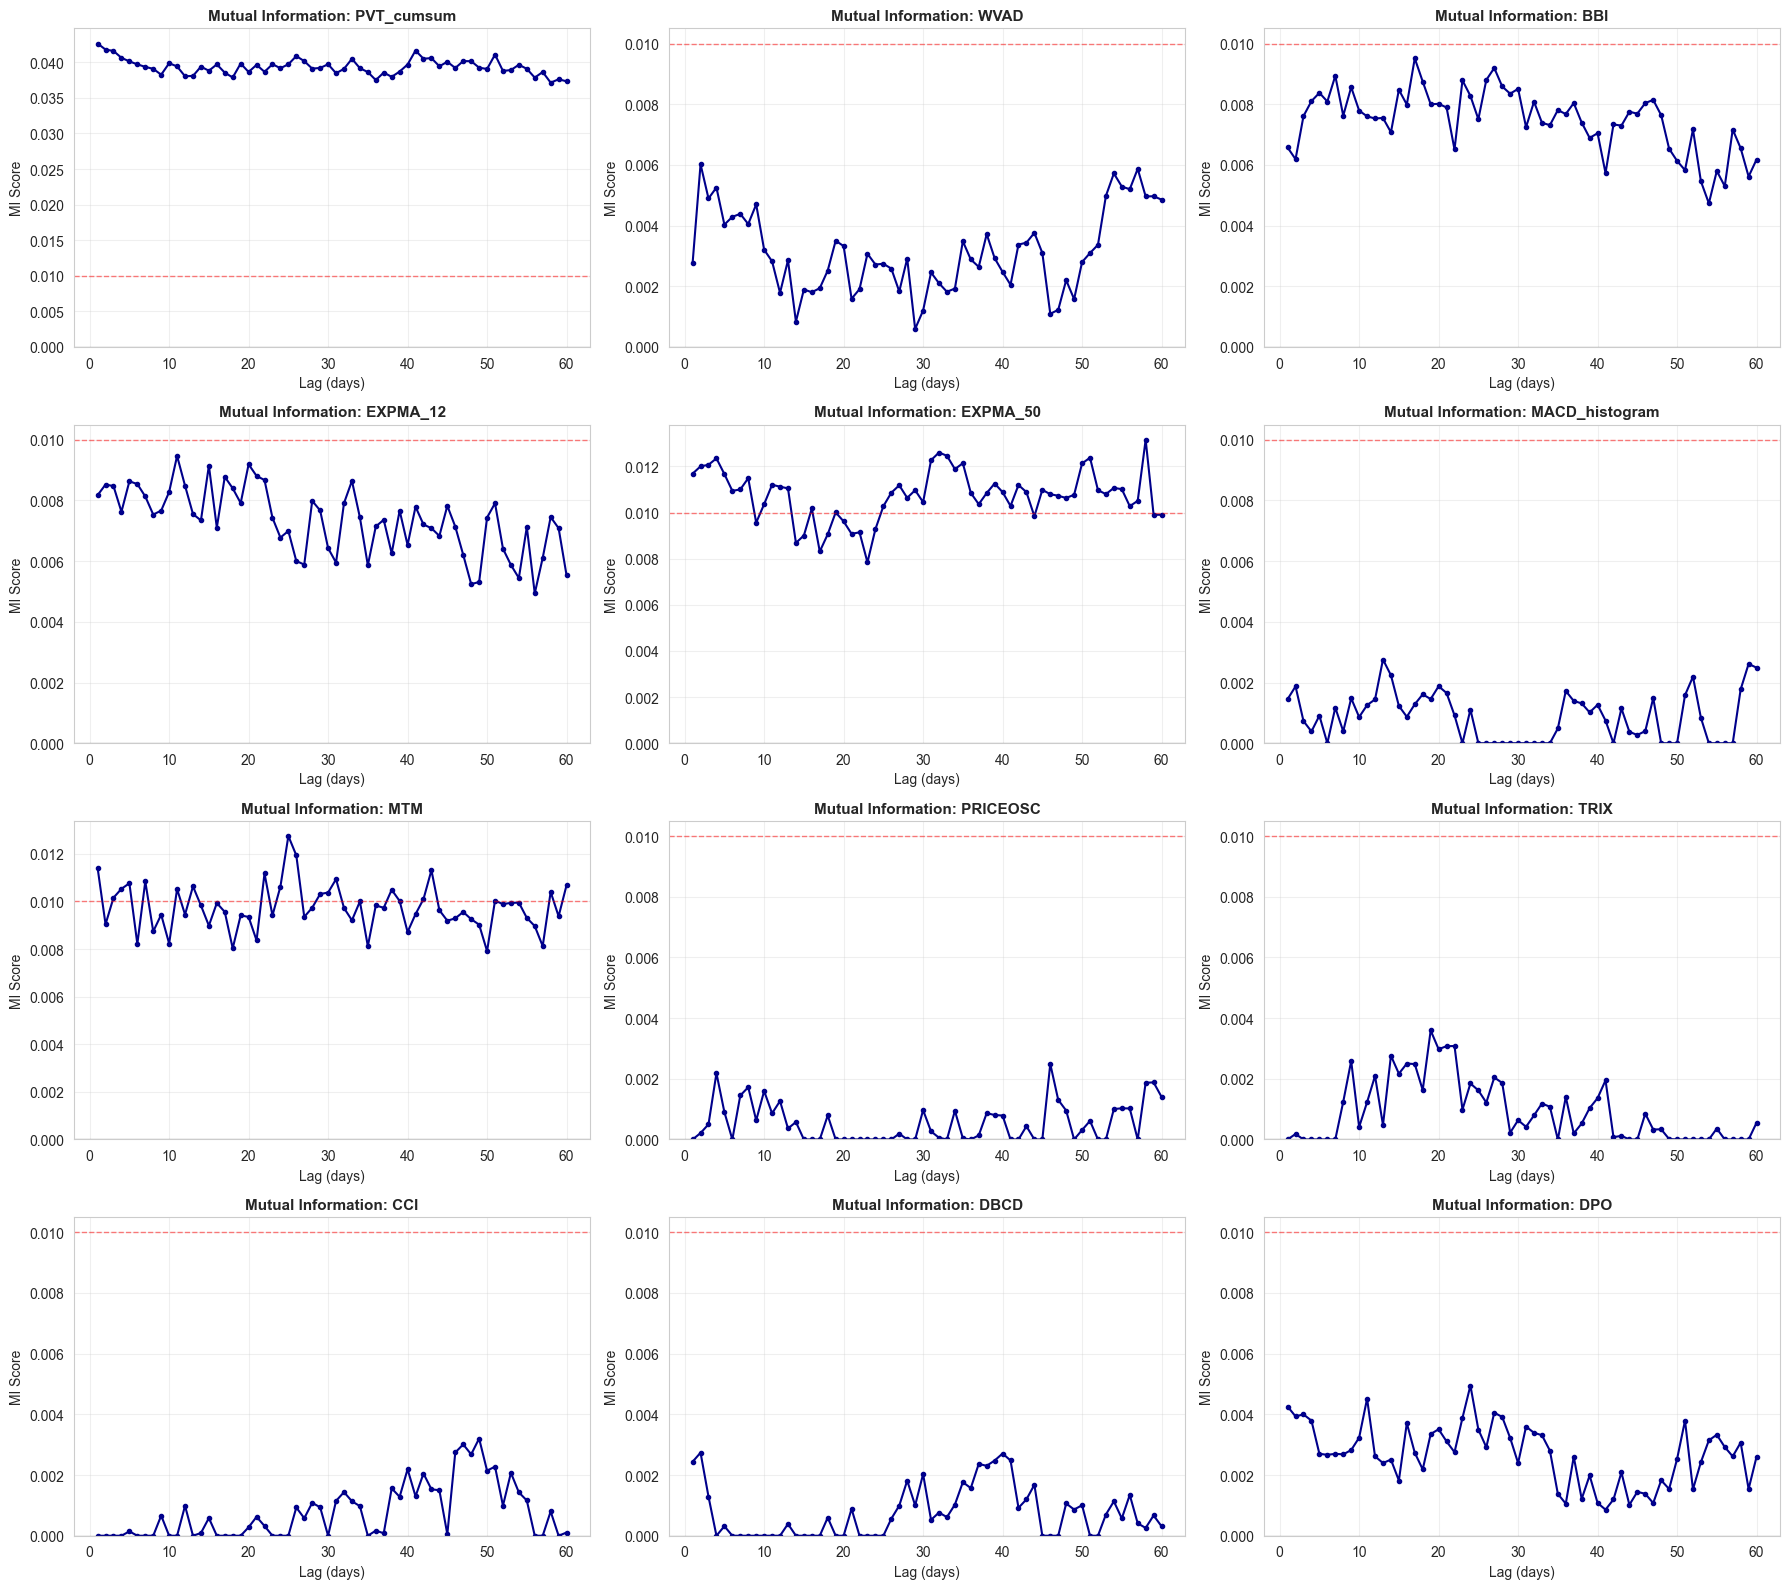


Analyzing MI with target: K (25/45)
  Peak MI: 0.0083 at lag 20

Analyzing MI with target: D (26/45)
  Peak MI: 0.0039 at lag 17

Analyzing MI with target: J (27/45)
  Peak MI: 0.0033 at lag 52

Analyzing MI with target: SRDM (28/45)
  Peak MI: 0.0044 at lag 44

Analyzing MI with target: VROC (29/45)
  Peak MI: 0.0019 at lag 37

Analyzing MI with target: VRSI (30/45)
  Peak MI: 0.0027 at lag 42

Analyzing MI with target: WR (31/45)
  Peak MI: 0.0081 at lag 14

Analyzing MI with target: ADTM (32/45)
  Peak MI: 0.0104 at lag 43

Analyzing MI with target: CDP_AH (33/45)
  Peak MI: 0.0109 at lag 5

Analyzing MI with target: CDP_AL (34/45)
  Peak MI: 0.0107 at lag 1

Analyzing MI with target: CDP_NH (35/45)
  Peak MI: 0.0116 at lag 9

Analyzing MI with target: CDP_NL (36/45)
  Peak MI: 0.0115 at lag 58

✓ Saved: 04_target_lag_mutual_information_part3.png


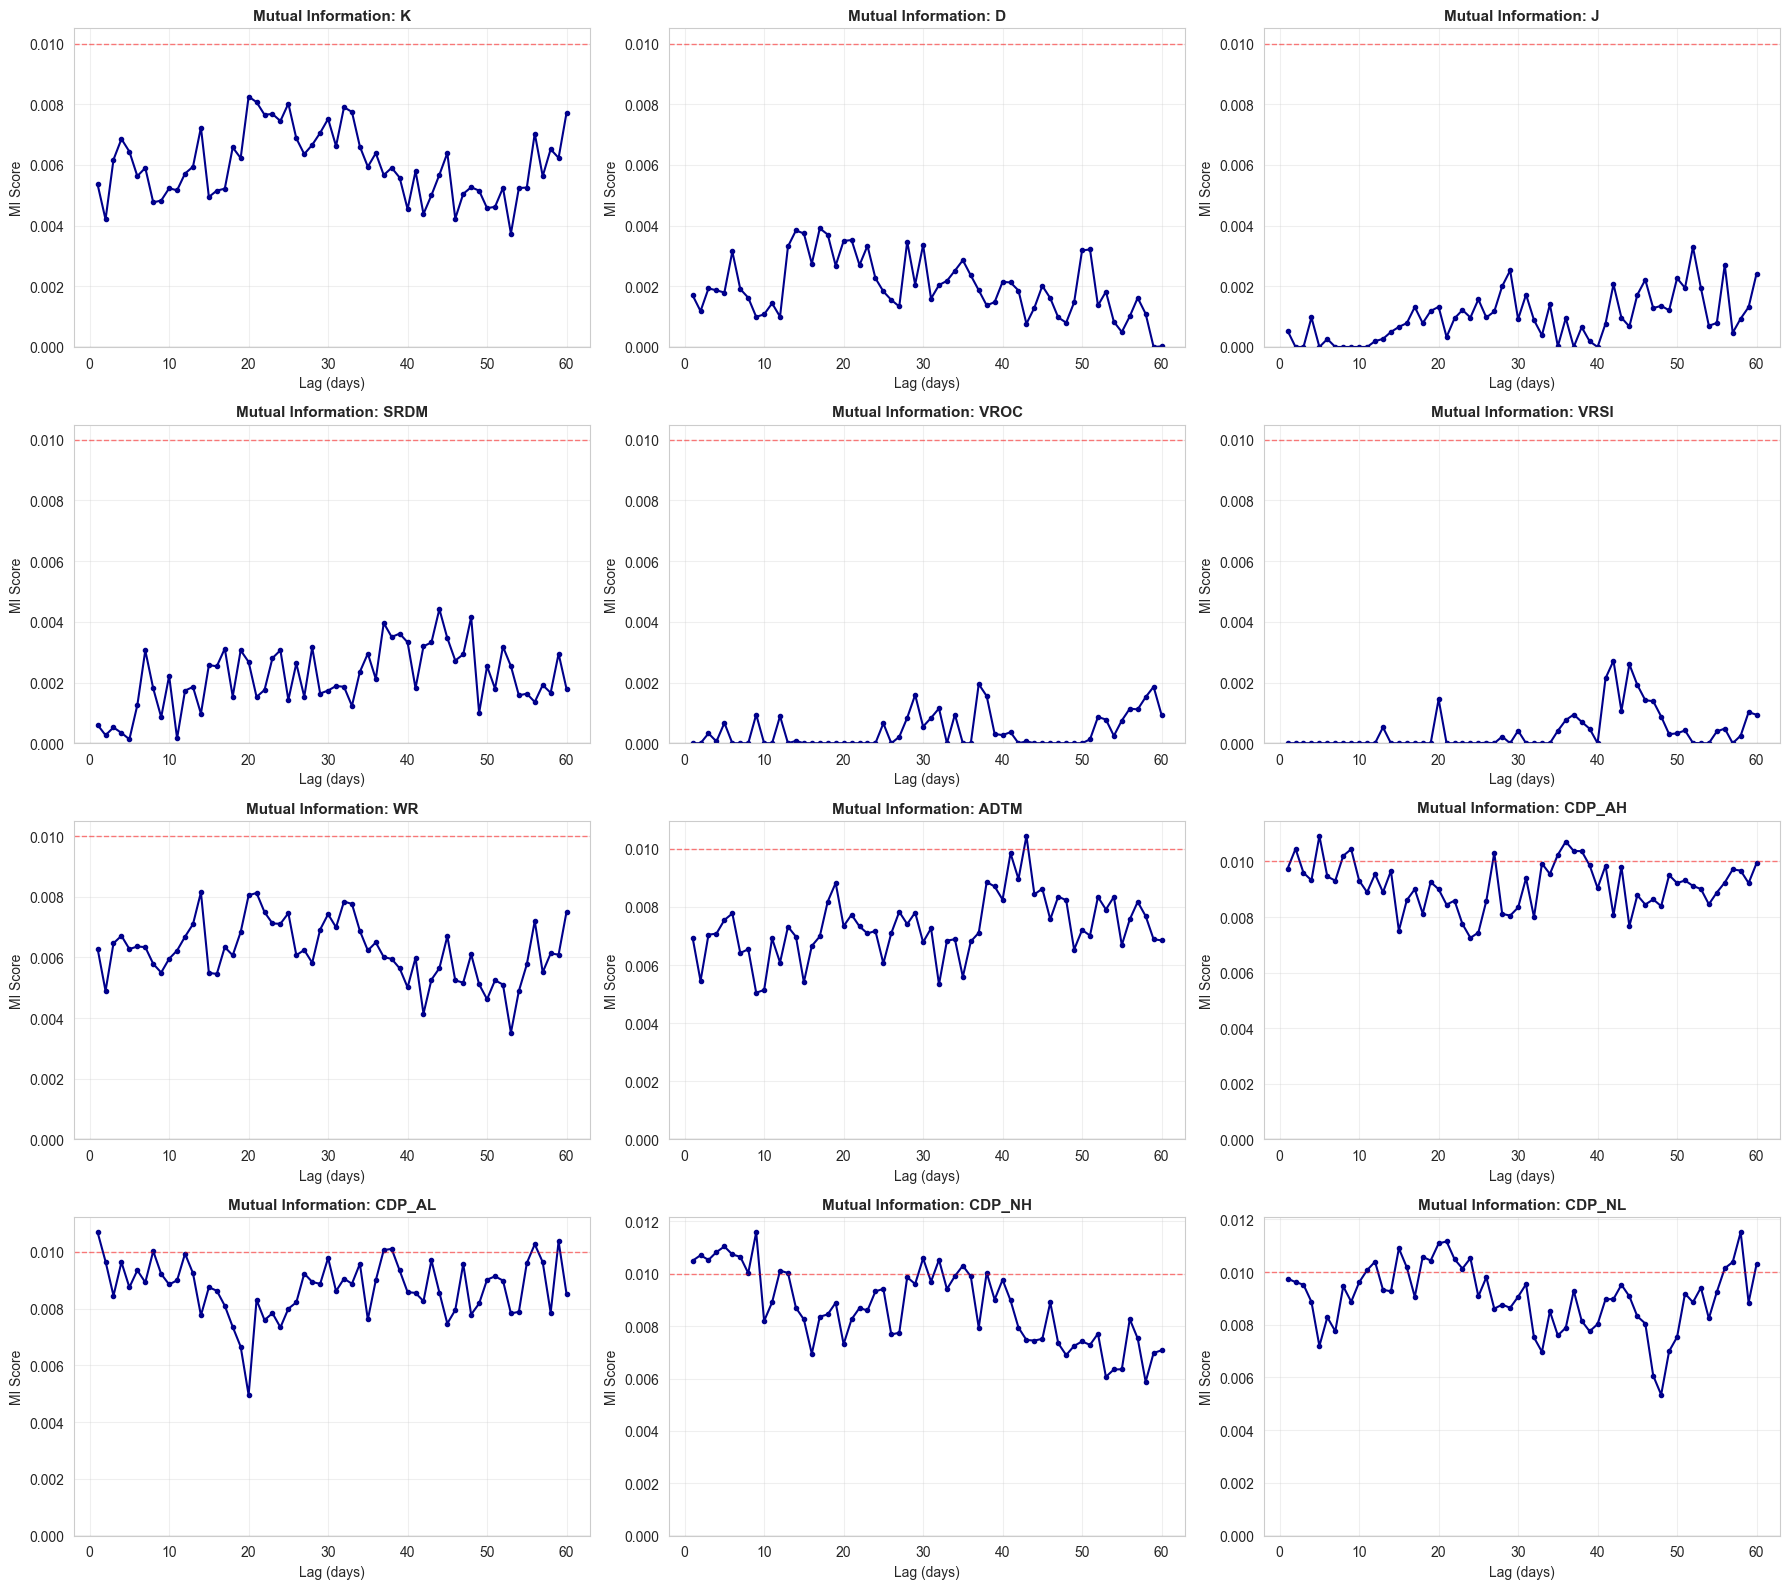


Analyzing MI with target: MI (37/45)
  Peak MI: 0.0121 at lag 57

Analyzing MI with target: MICD (38/45)
  Peak MI: 0.0027 at lag 26

Analyzing MI with target: RC (39/45)
  Peak MI: 0.0036 at lag 39

Analyzing MI with target: RCCD (40/45)
  Peak MI: 0.0019 at lag 55

Analyzing MI with target: SRMI (41/45)
  Peak MI: 0.0064 at lag 22

Analyzing MI with target: CVLT (42/45)
  Peak MI: 0.0033 at lag 60

Analyzing MI with target: MASS (43/45)
  Peak MI: 0.0026 at lag 28

Analyzing MI with target: STD_20 (44/45)
  Peak MI: 0.0044 at lag 57

Analyzing MI with target: VHF (45/45)
  Peak MI: 0.0088 at lag 10

✓ Saved: 04_target_lag_mutual_information_part4.png


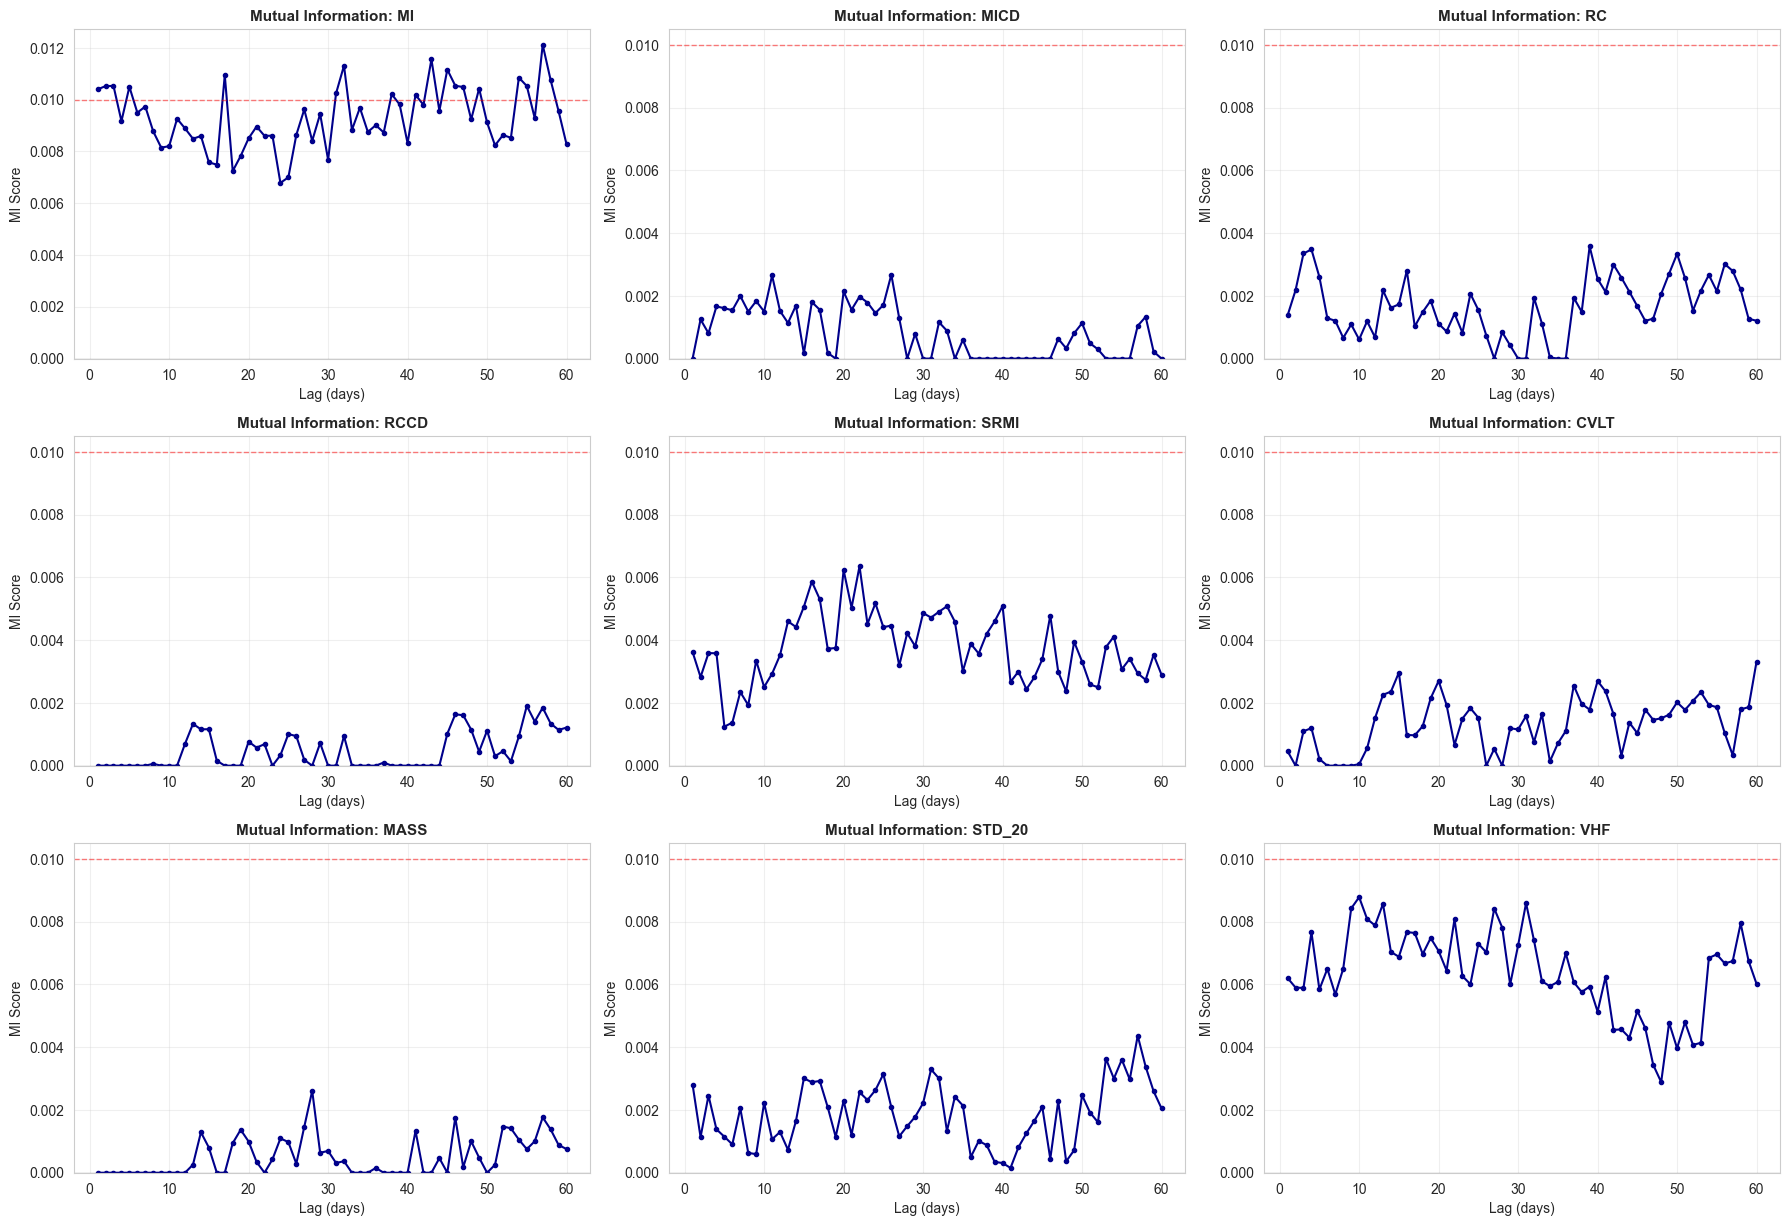


✓ Mutual Information analysis complete! Created 4 figure(s)

BONUS: CORRELATION vs MUTUAL INFORMATION COMPARISON

✓ Saved: 05_correlation_vs_MI_comparison_part1.png


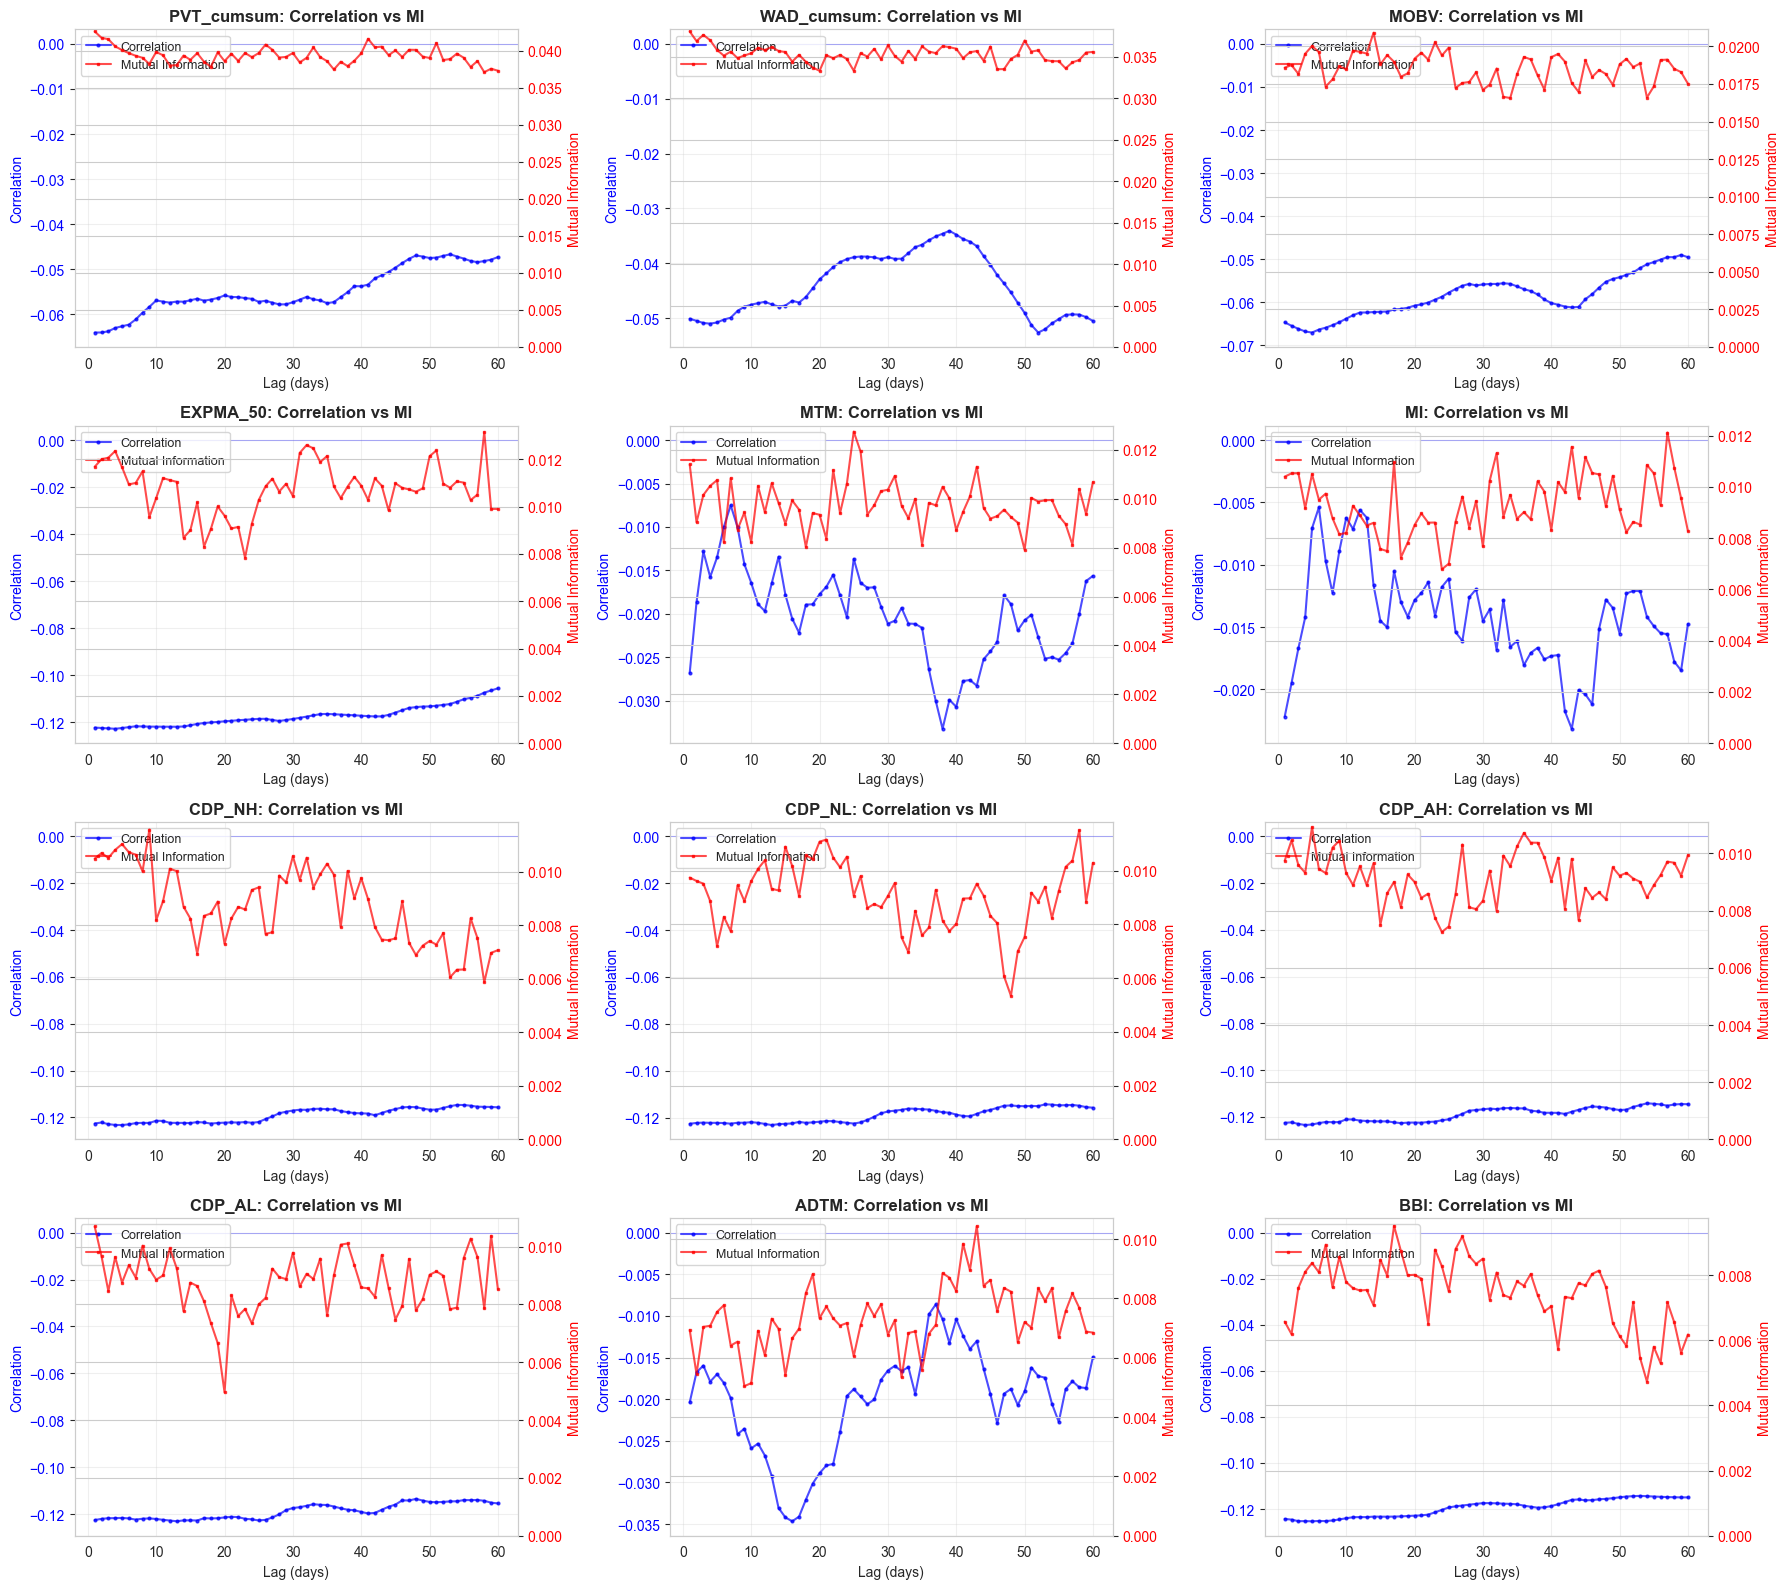


SUMMARY: TOP PREDICTIVE LAGS

Top Features by Mutual Information:
   Feature  Best_Corr  Best_Corr_Lag  Best_MI  Best_MI_Lag
PVT_cumsum  -0.064043              1 0.042629            1
WAD_cumsum  -0.052638             52 0.038059            1
      MOBV  -0.067026              5 0.020907           14
  EXPMA_50  -0.122828              4 0.013153           58
       MTM  -0.033255             38 0.012749           25
        MI  -0.023161             43 0.012116           57
    CDP_NH  -0.123251              5 0.011584            9
    CDP_NL  -0.123166             13 0.011507           58
    CDP_AH  -0.123472              4 0.010916            5
    CDP_AL  -0.123073             13 0.010695            1
      ADTM  -0.034659             16 0.010438           43
       BBI  -0.125332              5 0.009510           17
  EXPMA_12  -0.125383              5 0.009467           11
       VHF  -0.026809             57 0.008783           10
      VSTD   0.028853              1 0.008728   

In [12]:
# ============================================================================
# SECTION 6: TARGET-LAG MUTUAL INFORMATION ANALYSIS
# ============================================================================

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

print("\n" + "="*80)
print("[6] TARGET-LAG MUTUAL INFORMATION ANALYSIS")
print("="*80)
print("Analyzing mutual information between lagged features and binary target")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50  # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60            # Should match previous sections for consistency
PLOTS_PER_FIGURE = 12    # Number of subplots per figure (4x3 grid)

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# TARGET-LAG MUTUAL INFORMATION COMPUTATION
# ----------------------------------------------------------------------------
target_mi_results = {}

# Calculate how many figures we need
num_features = len(feature_columns)
num_figures = int(np.ceil(num_features / PLOTS_PER_FIGURE))

print(f"\nTotal features: {num_features}")
print(f"Plots per figure: {PLOTS_PER_FIGURE}")
print(f"Number of figures to create: {num_figures}")

# Initialize first figure
fig_idx = 0
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
plot_idx_in_figure = 0

for feature_idx, feature in enumerate(feature_columns):
    print(f"\nAnalyzing MI with target: {feature} ({feature_idx+1}/{num_features})")

    mi_scores_per_lag = []

    # For each lag
    for lag in range(1, max_lags + 1):

        # Collect all valid samples across tickers
        X_lag = []
        y_lag = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            lagged_feature = ticker_data[feature].shift(lag)
            valid_mask = ticker_data['target'].notna() & lagged_feature.notna()

            if valid_mask.sum() > 0:
                X_lag.extend(lagged_feature[valid_mask].values)
                y_lag.extend(ticker_data.loc[valid_mask, 'target'].values)

        # Compute mutual information if we have enough samples
        if len(X_lag) > 30:
            X_lag = np.array(X_lag).reshape(-1, 1)
            y_lag = np.array(y_lag)

            # Mutual information estimation
            # random_state for reproducibility
            mi = mutual_info_classif(X_lag, y_lag,
                                    discrete_features=False,
                                    n_neighbors=3,
                                    random_state=42)[0]
            mi_scores_per_lag.append(mi)
        else:
            mi_scores_per_lag.append(0)

    target_mi_results[feature] = mi_scores_per_lag

    # ----------------------------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------------------------
    axes[plot_idx_in_figure].plot(range(1, max_lags + 1), mi_scores_per_lag,
                   marker='o', markersize=3, linewidth=1.5, color='darkblue')
    axes[plot_idx_in_figure].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    # Add threshold line (optional - 0.01 is a reasonable baseline)
    axes[plot_idx_in_figure].axhline(y=0.01, color='red', linestyle='--',
                     linewidth=1, alpha=0.5, label='Threshold')

    axes[plot_idx_in_figure].set_title(f'Mutual Information: {feature}',
                       fontsize=11, fontweight='bold')
    axes[plot_idx_in_figure].set_xlabel('Lag (days)')
    axes[plot_idx_in_figure].set_ylabel('MI Score')
    axes[plot_idx_in_figure].grid(True, alpha=0.3)
    axes[plot_idx_in_figure].set_ylim(bottom=0)  # MI is always non-negative

    # ----------------------------------------------------------------------------
    # FIND PEAK MI
    # ----------------------------------------------------------------------------
    max_mi_idx = np.argmax(mi_scores_per_lag)
    max_mi = mi_scores_per_lag[max_mi_idx]
    print(f"  Peak MI: {max_mi:.4f} at lag {max_mi_idx + 1}")

    plot_idx_in_figure += 1

    # Check if we need to save current figure and start a new one
    if plot_idx_in_figure == PLOTS_PER_FIGURE or feature_idx == num_features - 1:
        # Hide any unused subplots in the current figure
        for unused_idx in range(plot_idx_in_figure, PLOTS_PER_FIGURE):
            axes[unused_idx].remove()

        plt.tight_layout()
        filename = f'04_target_lag_mutual_information_part{fig_idx+1}.png'
        plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: {filename}")
        plt.show()

        # Start new figure if there are more features to plot
        if feature_idx < num_features - 1:
            fig_idx += 1
            fig, axes = plt.subplots(4, 3, figsize=(18, 16))
            axes = axes.flatten()
            plot_idx_in_figure = 0

print("\n" + "="*80)
print(f"✓ Mutual Information analysis complete! Created {fig_idx + 1} figure(s)")
print("="*80)

# ============================================================================
# OPTIONAL: COMPARISON PLOT - CORRELATION vs MUTUAL INFORMATION
# ============================================================================

print("\n" + "="*80)
print("BONUS: CORRELATION vs MUTUAL INFORMATION COMPARISON")
print("="*80)

# Create comparison plot for top features by MI (select top 12)
# Sort features by max MI score
feature_max_mi = {feat: max(target_mi_results[feat])
                  for feat in feature_columns if feat in target_mi_results}
top_features = sorted(feature_max_mi.items(), key=lambda x: x[1], reverse=True)[:12]
comparison_features = [feat for feat, _ in top_features]

# Calculate number of comparison figures needed
num_comp_plots = len(comparison_features)
num_comp_figures = int(np.ceil(num_comp_plots / PLOTS_PER_FIGURE))

for comp_fig_idx in range(num_comp_figures):
    start_idx = comp_fig_idx * PLOTS_PER_FIGURE
    end_idx = min(start_idx + PLOTS_PER_FIGURE, num_comp_plots)
    features_in_figure = comparison_features[start_idx:end_idx]

    fig, axes = plt.subplots(4, 3, figsize=(18, 16))
    axes = axes.flatten()

    for idx, feature in enumerate(features_in_figure):
        if feature in target_lag_results and feature in target_mi_results:

            # Create twin axis
            ax1 = axes[idx]
            ax2 = ax1.twinx()

            # Plot correlation
            lags = range(1, max_lags + 1)
            line1 = ax1.plot(lags, target_lag_results[feature],
                            color='blue', marker='o', markersize=2,
                            linewidth=1.5, label='Correlation', alpha=0.7)
            ax1.axhline(y=0, color='blue', linestyle='-', linewidth=0.8, alpha=0.3)
            ax1.set_xlabel('Lag (days)', fontsize=10)
            ax1.set_ylabel('Correlation', color='blue', fontsize=10)
            ax1.tick_params(axis='y', labelcolor='blue')

            # Plot MI
            line2 = ax2.plot(lags, target_mi_results[feature],
                            color='red', marker='s', markersize=2,
                            linewidth=1.5, label='Mutual Information', alpha=0.7)
            ax2.set_ylabel('Mutual Information', color='red', fontsize=10)
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.set_ylim(bottom=0)

            # Title and legend
            ax1.set_title(f'{feature}: Correlation vs MI',
                         fontsize=12, fontweight='bold')
            ax1.grid(True, alpha=0.3)

            # Combined legend
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper left', fontsize=9)

    # Hide unused subplots
    for unused_idx in range(len(features_in_figure), PLOTS_PER_FIGURE):
        axes[unused_idx].remove()

    plt.tight_layout()
    filename = f'05_correlation_vs_MI_comparison_part{comp_fig_idx+1}.png'
    plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {filename}")
    plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: TOP PREDICTIVE LAGS")
print("="*80)

summary_data = []

for feature in feature_columns:
    if feature in target_lag_results and feature in target_mi_results:

        # Best correlation
        corr_values = target_lag_results[feature]
        best_corr_idx = np.argmax(np.abs(corr_values))
        best_corr = corr_values[best_corr_idx]

        # Best MI
        mi_values = target_mi_results[feature]
        best_mi_idx = np.argmax(mi_values)
        best_mi = mi_values[best_mi_idx]

        summary_data.append({
            'Feature': feature,
            'Best_Corr': best_corr,
            'Best_Corr_Lag': best_corr_idx + 1,
            'Best_MI': best_mi,
            'Best_MI_Lag': best_mi_idx + 1
        })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Best_MI', ascending=False)

print("\nTop Features by Mutual Information:")
print(summary_df.head(20).to_string(index=False))  # Show top 20
print(f"\n... and {len(summary_df) - 20} more features")

# Save summary
summary_df.to_csv('target_lag_analysis_summary.csv', index=False)
print("\n✓ Saved: target_lag_analysis_summary.csv")


[7] ROLLING STATISTICS ANALYSIS
Analyzing stability of features across different window sizes

Total features: 45
Plots per figure: 12
Number of figures to create: 4
Analyzing rolling stats: QRR (1/45)
Analyzing rolling stats: TAPI (2/45)
Analyzing rolling stats: VOSC (3/45)
Analyzing rolling stats: VSTD (4/45)
Analyzing rolling stats: VMACD_hist (5/45)
Analyzing rolling stats: CR (6/45)
Analyzing rolling stats: PSY (7/45)
Analyzing rolling stats: VR (8/45)
Analyzing rolling stats: AR (9/45)
Analyzing rolling stats: BR (10/45)
Analyzing rolling stats: WAD_cumsum (11/45)
Analyzing rolling stats: MOBV (12/45)
Analyzing rolling stats: PVT_cumsum (13/45)
Analyzing rolling stats: WVAD (14/45)
Analyzing rolling stats: BBI (15/45)
Analyzing rolling stats: EXPMA_12 (16/45)
Analyzing rolling stats: EXPMA_50 (17/45)
Analyzing rolling stats: MACD_histogram (18/45)
Analyzing rolling stats: MTM (19/45)
Analyzing rolling stats: PRICEOSC (20/45)
Analyzing rolling stats: TRIX (21/45)
Analyzing rollin

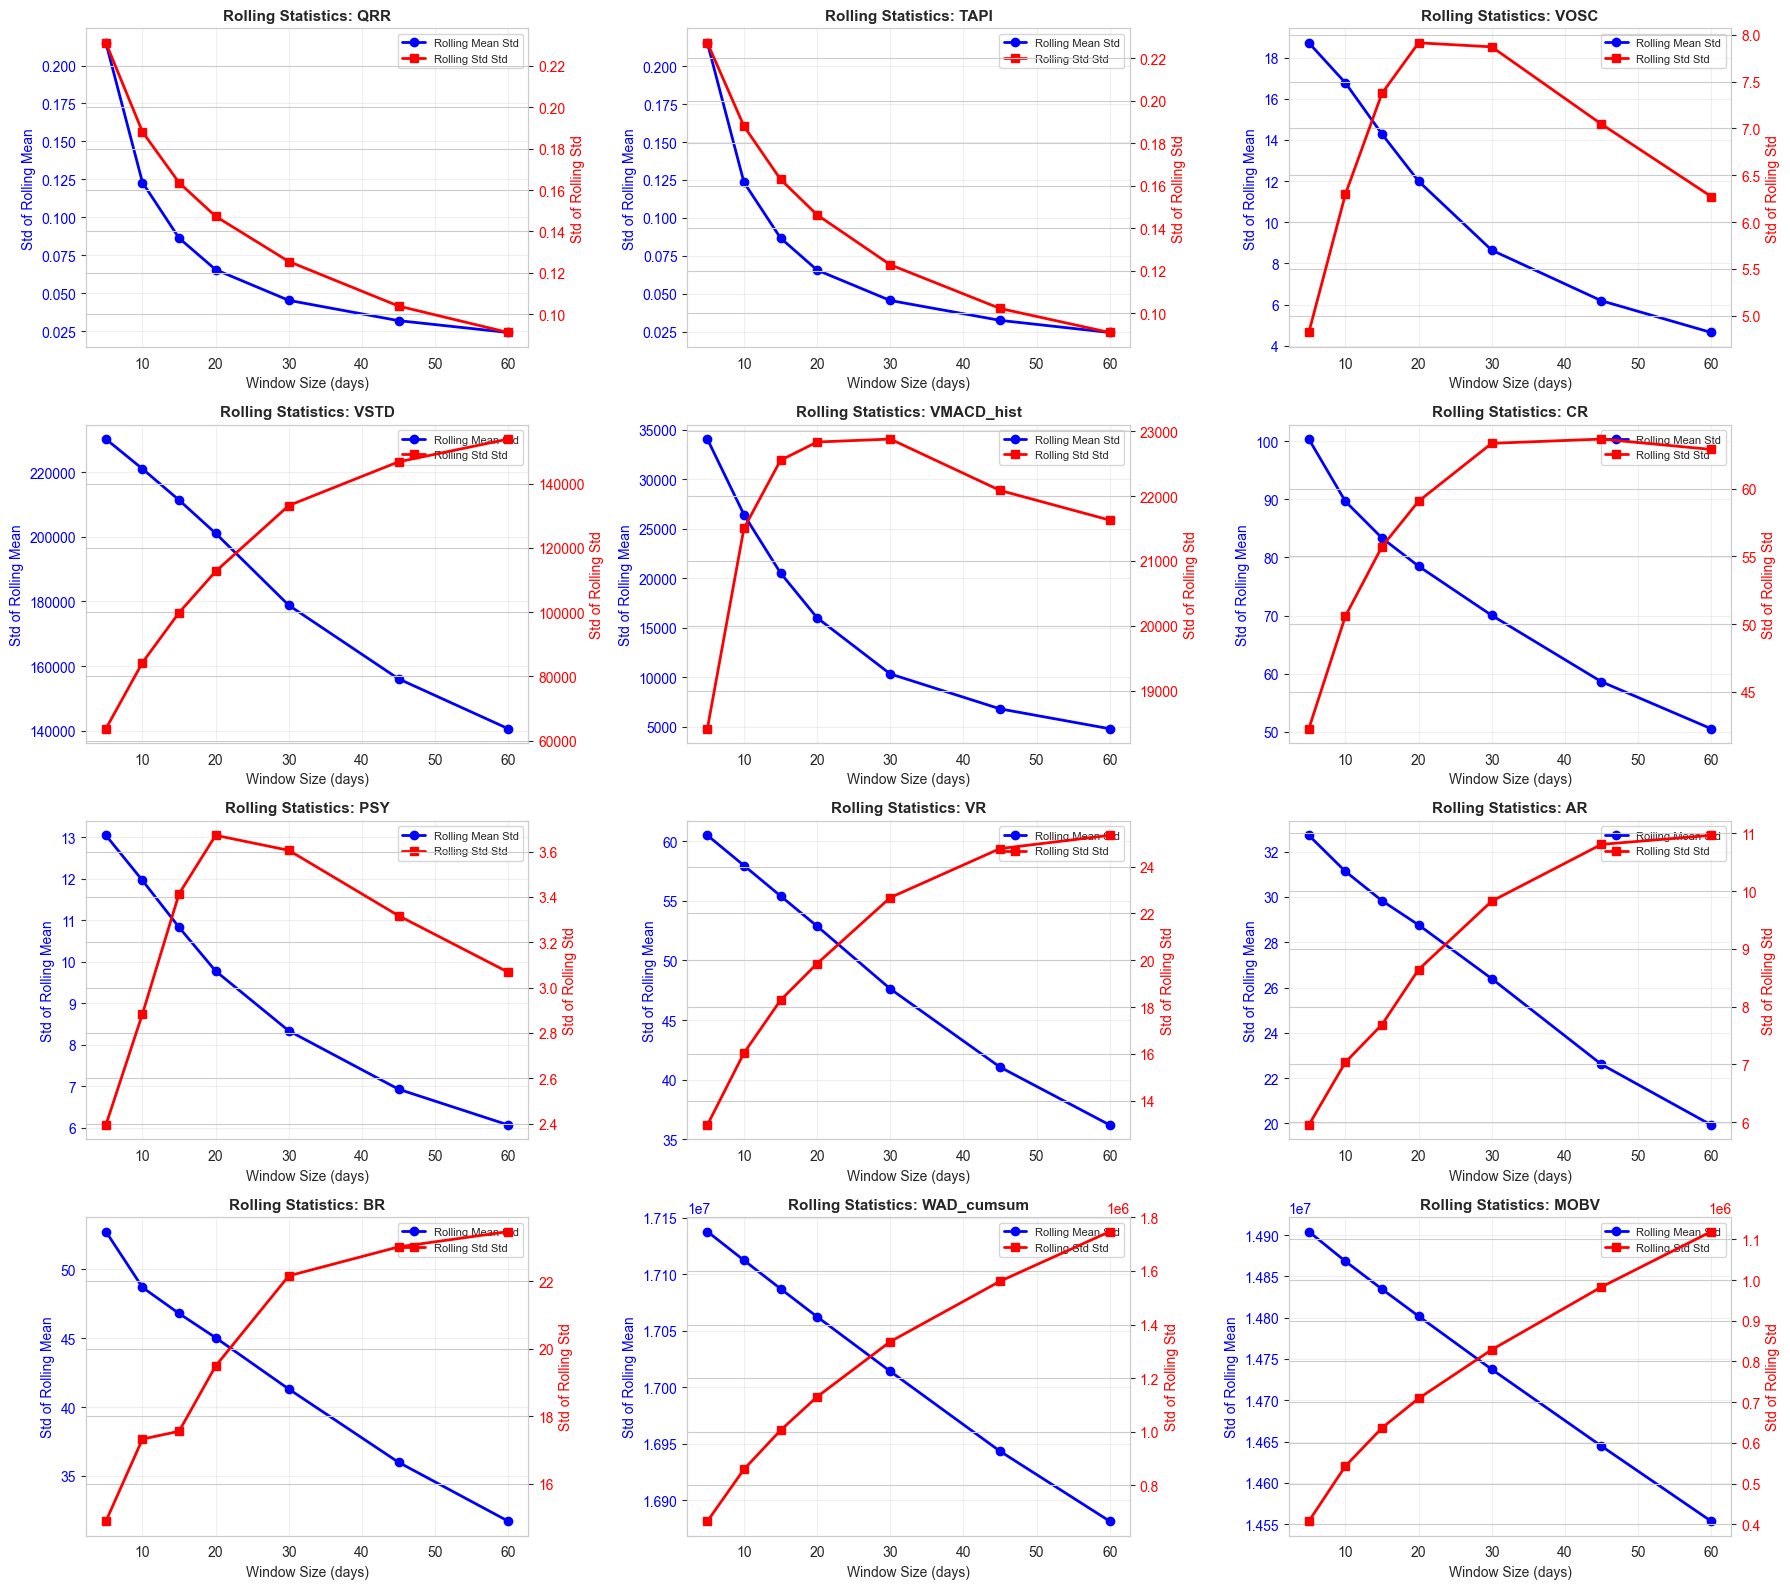


✓ Saved: 06_rolling_statistics_part2.png


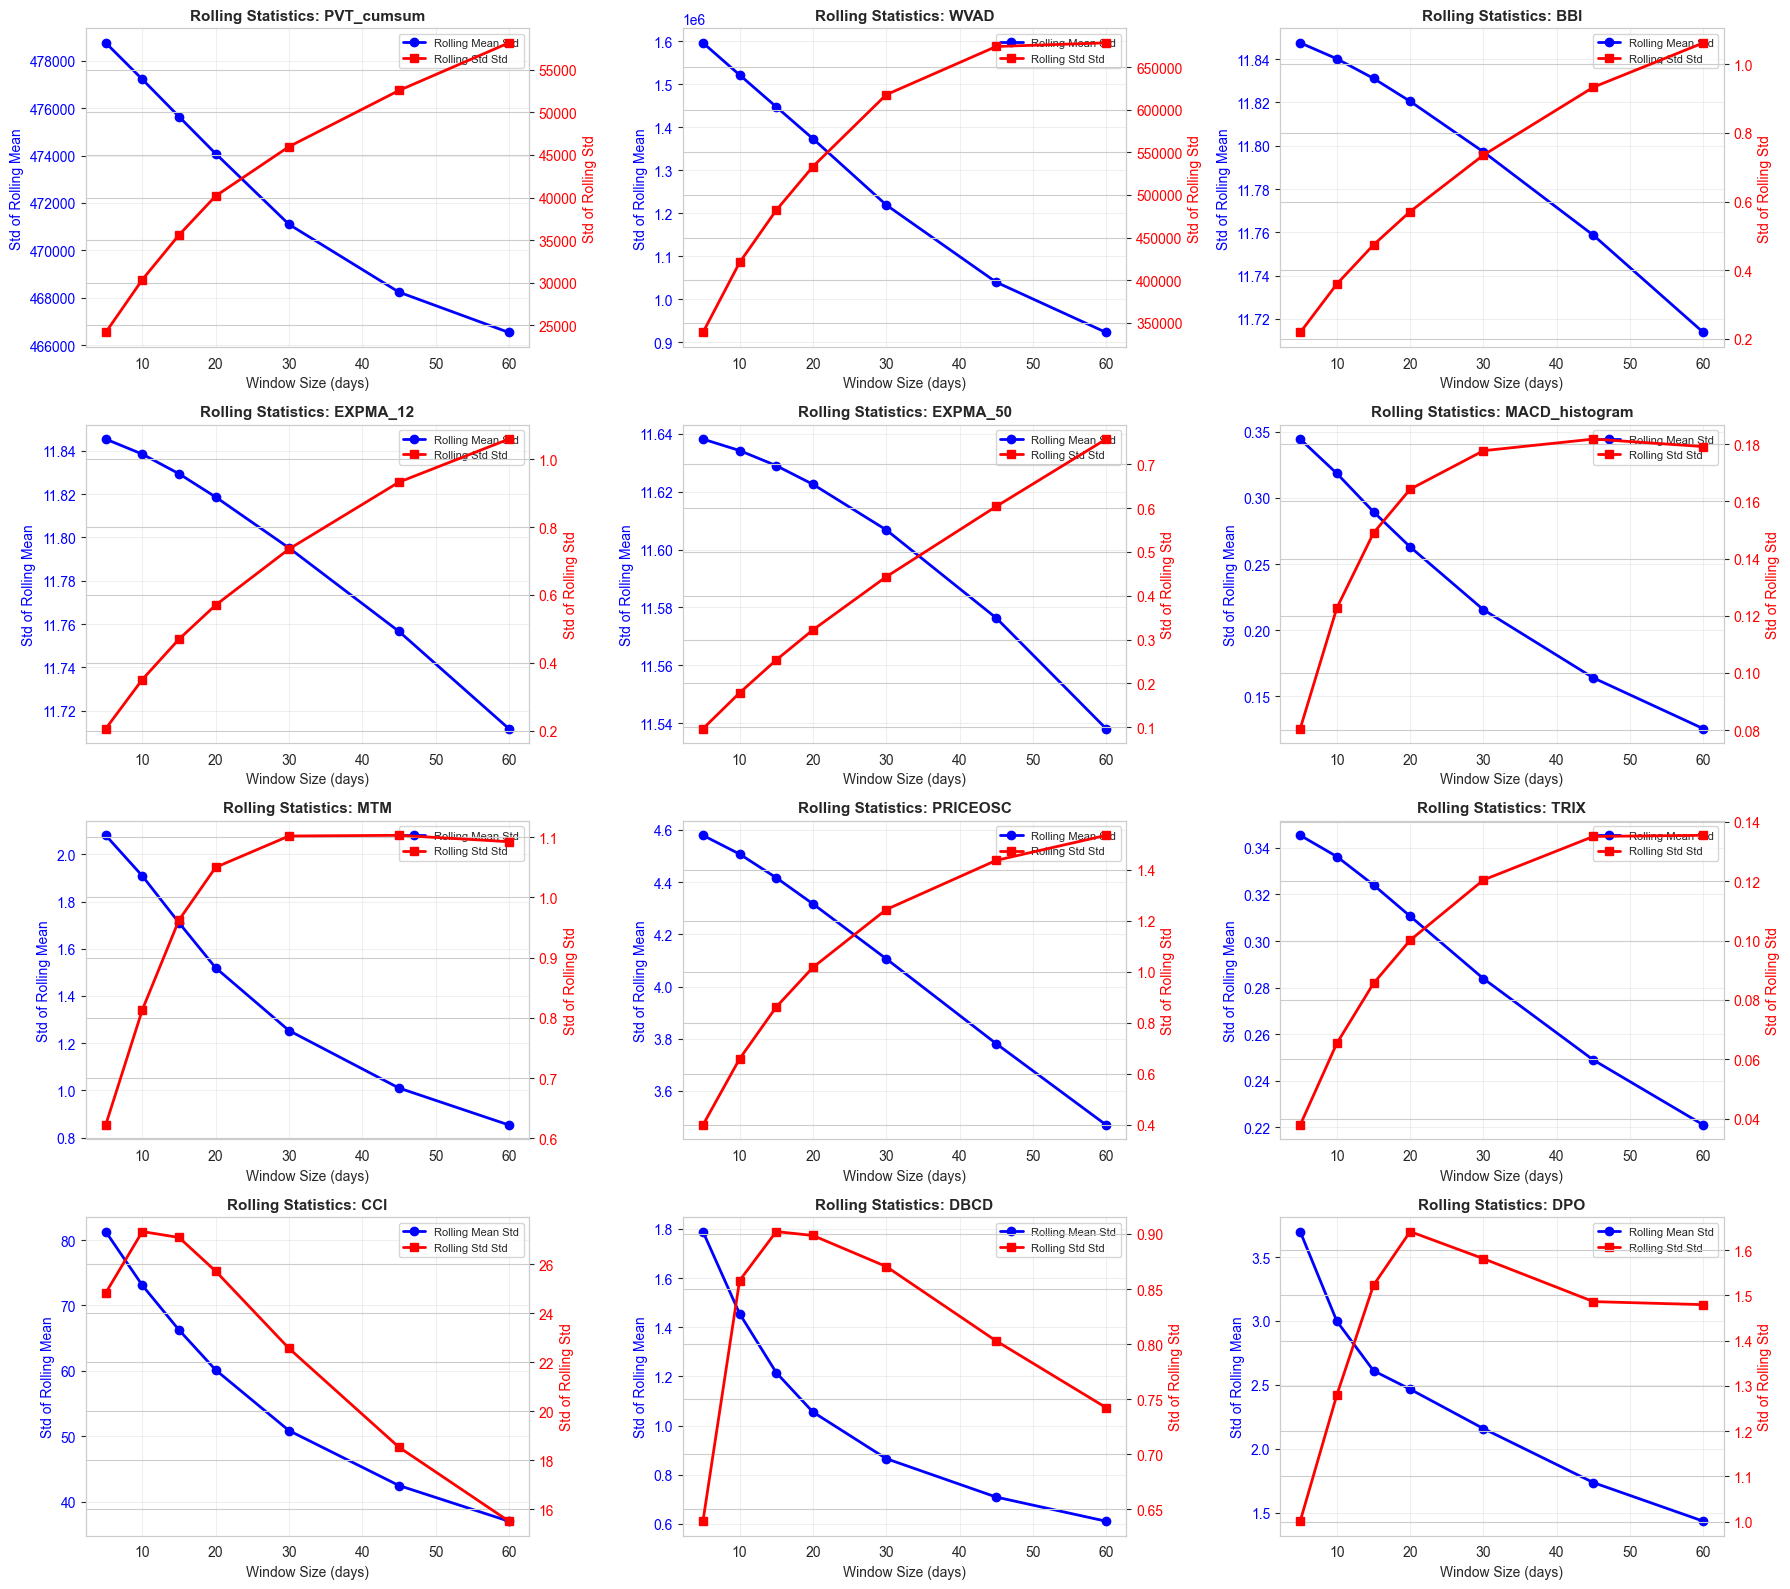


✓ Saved: 06_rolling_statistics_part3.png


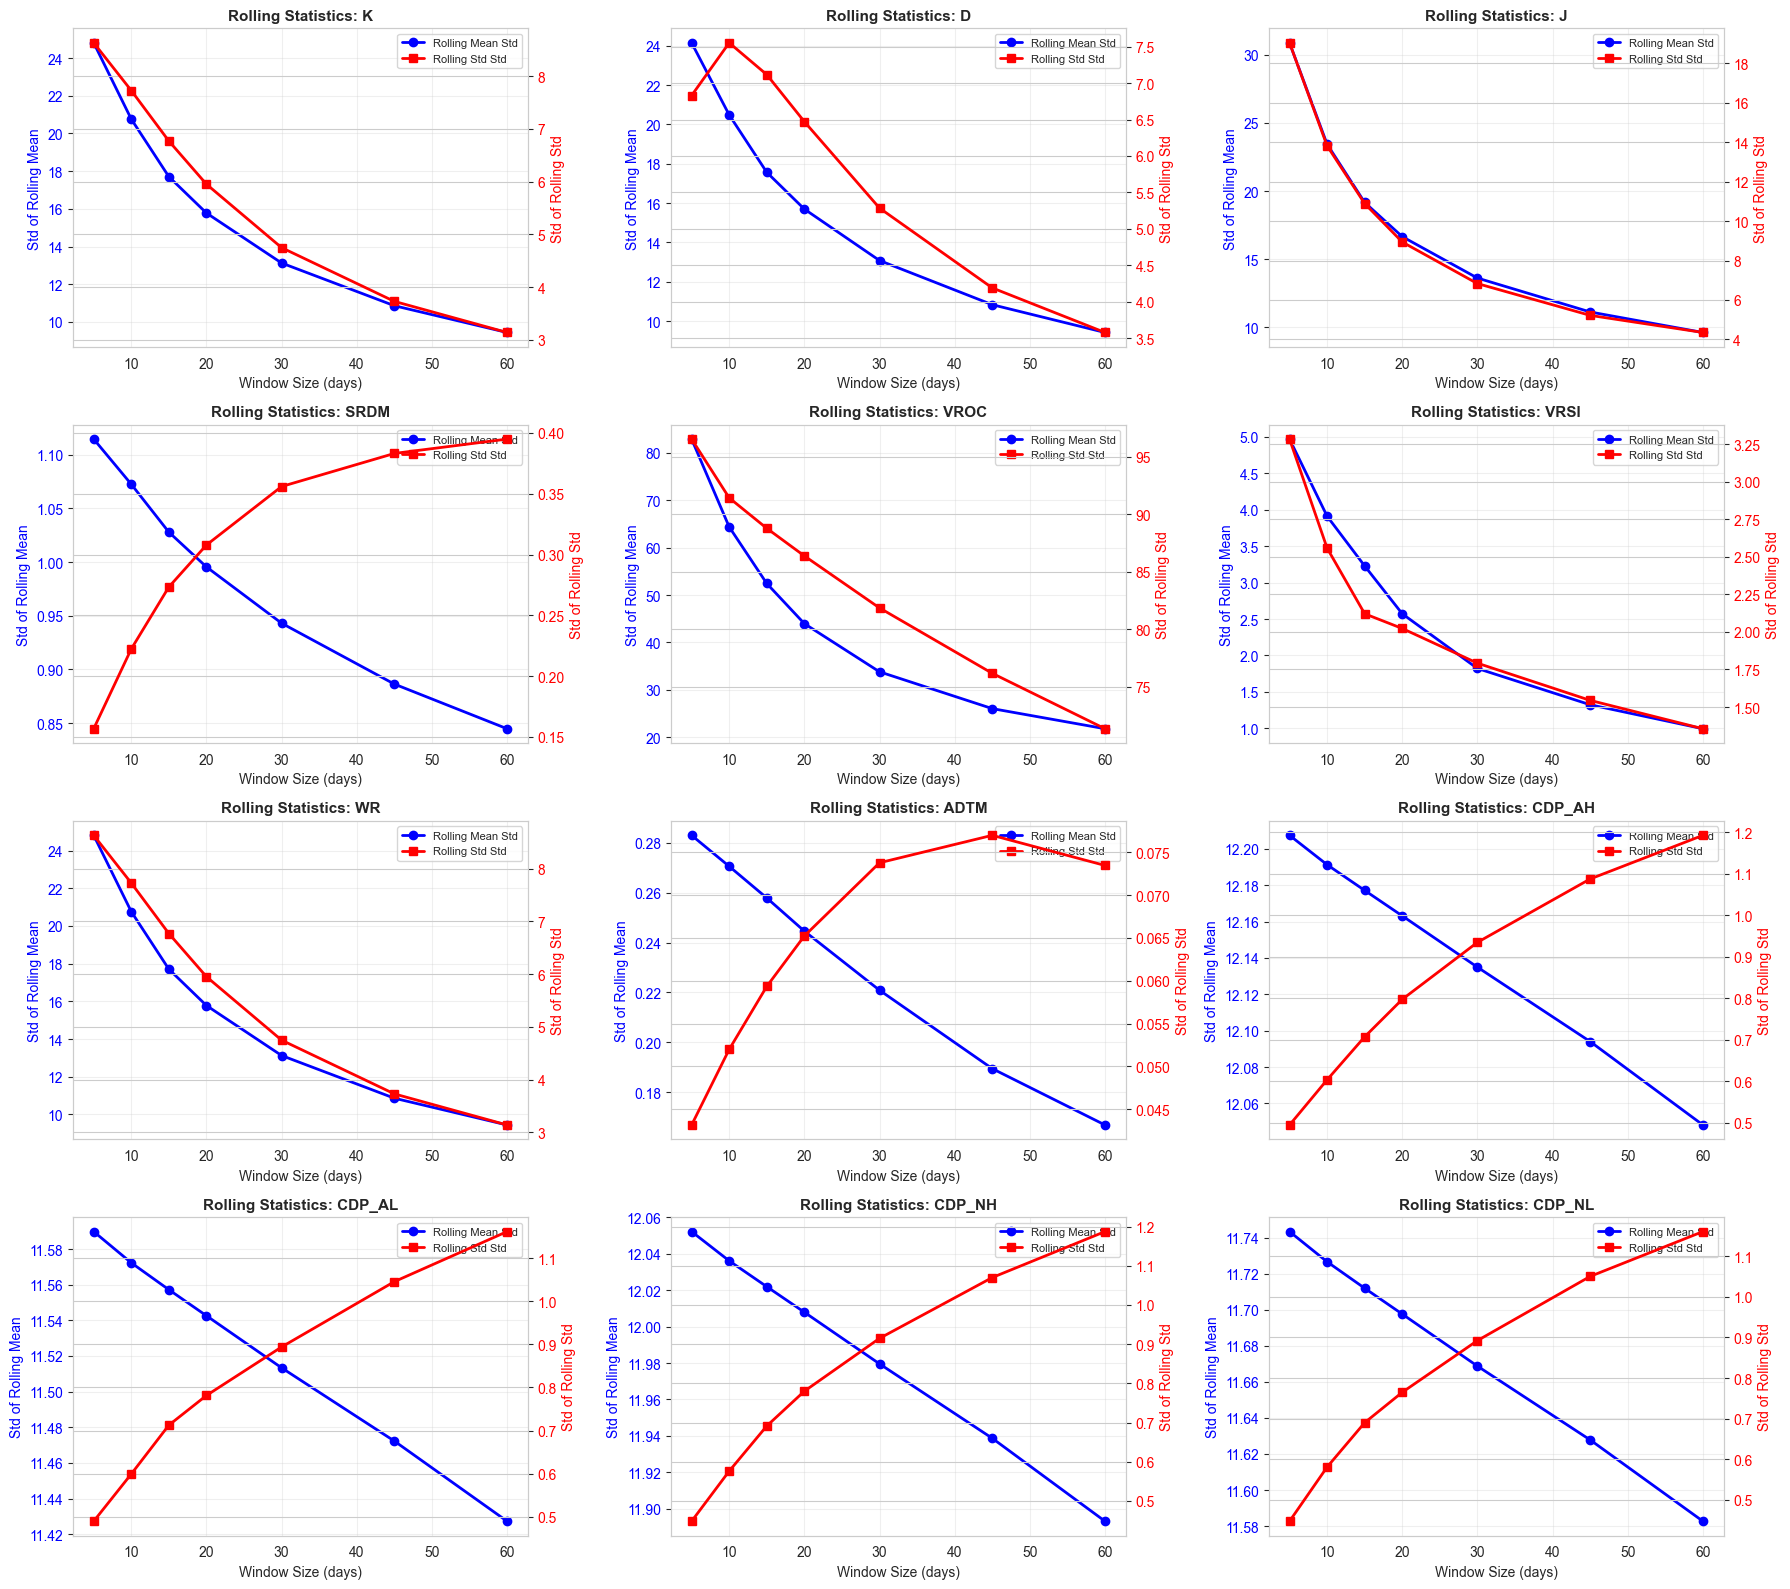


✓ Saved: 06_rolling_statistics_part4.png


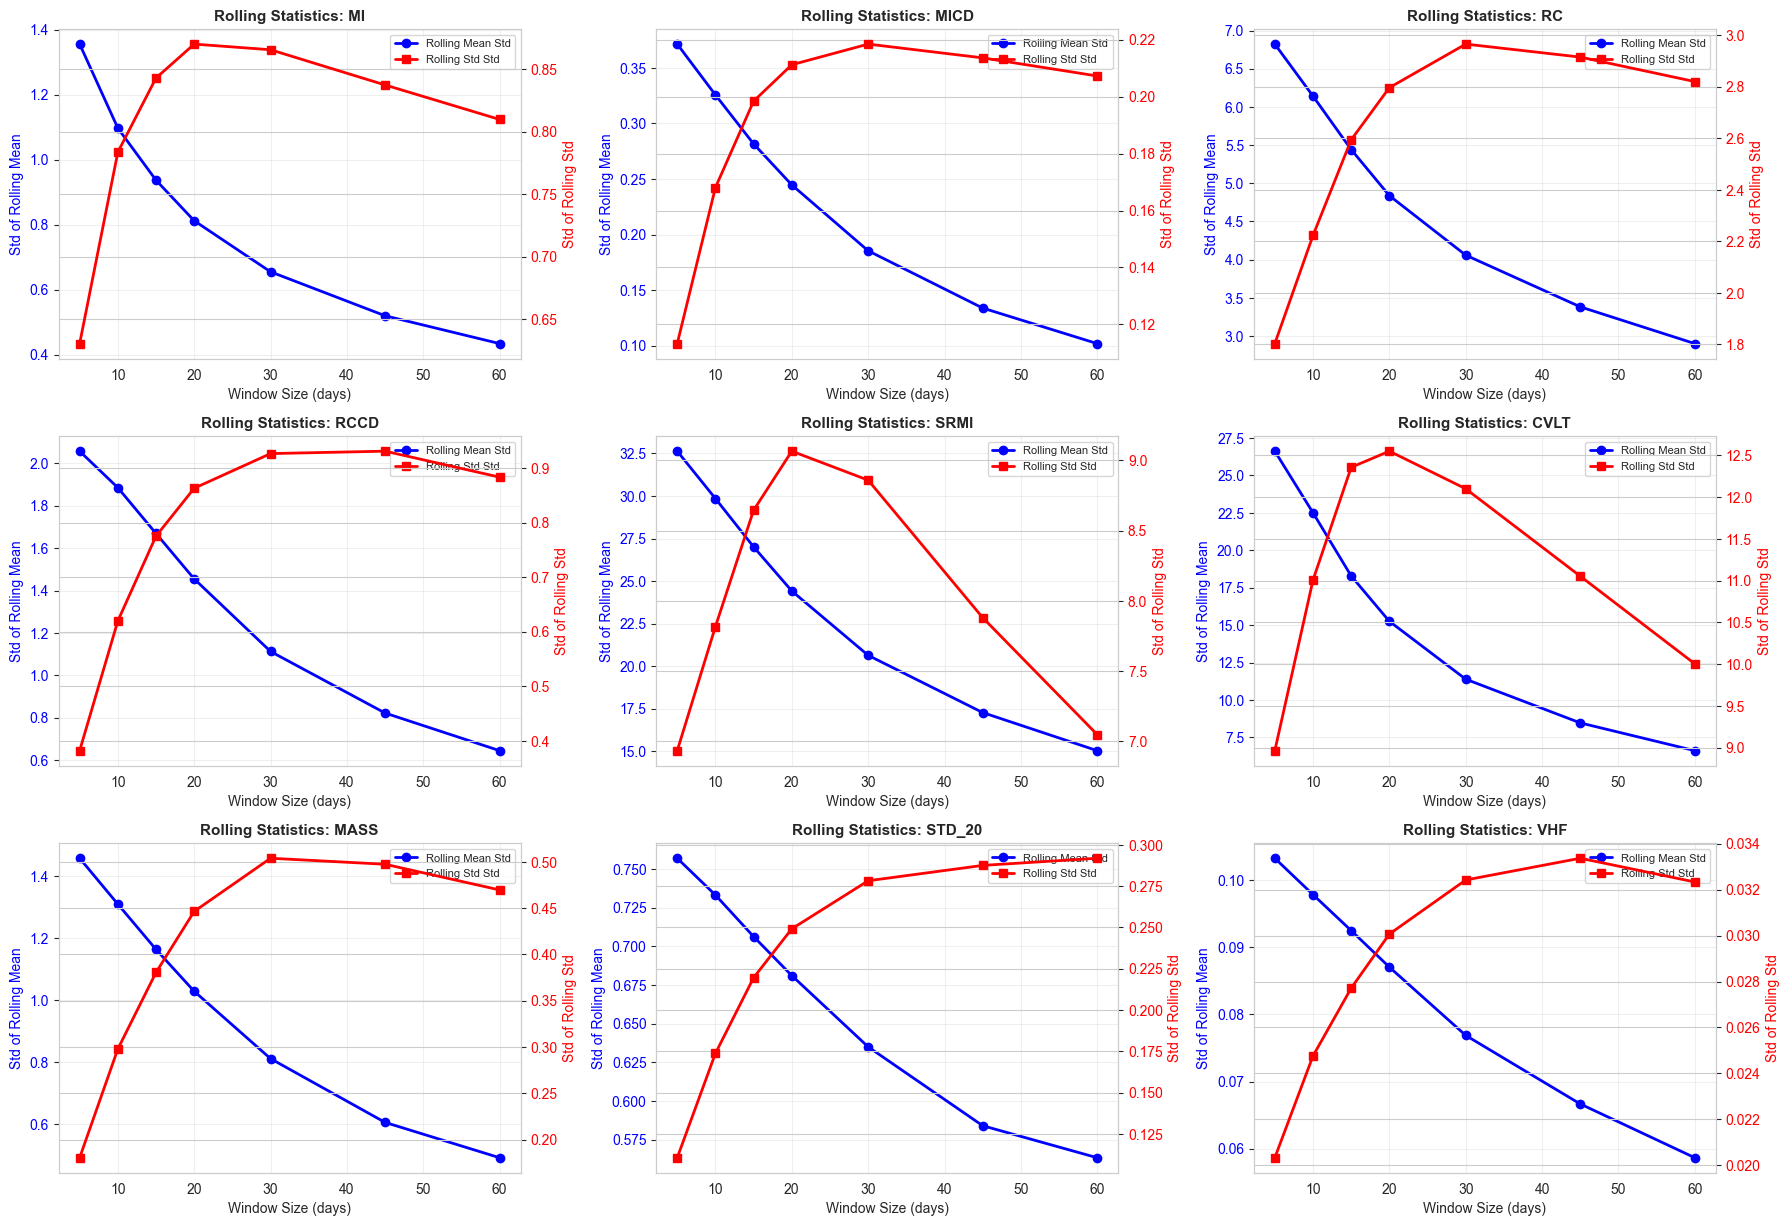


✓ Rolling statistics analysis complete! Created 4 figure(s)

SUMMARY: FEATURE STABILITY ACROSS WINDOWS

Most Stable Features (by Rolling Mean):
       Feature  Avg_Mean_Stability  Avg_Std_Stability  Mean_Stability_Variance  Std_Stability_Variance
           VHF            0.083271           0.028713                 0.015300                0.004428
           QRR            0.084494           0.150080                 0.061843                0.045400
          TAPI            0.084805           0.148602                 0.061948                0.044869
          ADTM            0.233314           0.063413                 0.039770                0.011663
          MICD            0.234917           0.190043                 0.092197                0.034960
MACD_histogram            0.245816           0.150759                 0.074912                0.034672
          TRIX            0.295744           0.097138                 0.043162                0.034034
        STD_20            0.665

In [13]:
# ============================================================================
# SECTION 7: ROLLING STATISTICS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[7] ROLLING STATISTICS ANALYSIS")
print("="*80)
print("Analyzing stability of features across different window sizes")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50   # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS TO INCLUDE
windows = [5, 10, 15, 20, 30, 45, 60]
PLOTS_PER_FIGURE = 12     # Number of subplots per figure (4x3 grid)

# ----------------------------------------------------------------------------
# PREPARE DATA
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])
selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# CALCULATE ROLLING STATISTICS
# ----------------------------------------------------------------------------
rolling_stats_results = {feature: {'windows': [], 'mean_std': [], 'std_std': []}
                         for feature in feature_columns}

# Calculate how many figures we need
num_features = len(feature_columns)
num_figures = int(np.ceil(num_features / PLOTS_PER_FIGURE))

print(f"\nTotal features: {num_features}")
print(f"Plots per figure: {PLOTS_PER_FIGURE}")
print(f"Number of figures to create: {num_figures}")

for feature_idx, feature in enumerate(feature_columns):
    print(f"Analyzing rolling stats: {feature} ({feature_idx+1}/{num_features})")

    for window in windows:

        per_ticker_mean_std = []
        per_ticker_std_std = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            rolling_mean = ticker_data[feature].rolling(window=window).mean()
            rolling_std = ticker_data[feature].rolling(window=window).std()

            mean_stability = rolling_mean.std()
            std_stability = rolling_std.std()

            per_ticker_mean_std.append(mean_stability)
            per_ticker_std_std.append(std_stability)

        # Aggregate across tickers (median)
        rolling_stats_results[feature]['windows'].append(window)
        rolling_stats_results[feature]['mean_std'].append(np.median(per_ticker_mean_std))
        rolling_stats_results[feature]['std_std'].append(np.median(per_ticker_std_std))

# ----------------------------------------------------------------------------
# PLOT
# ----------------------------------------------------------------------------
# Initialize first figure
fig_idx = 0
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
plot_idx_in_figure = 0

for feature_idx, feature in enumerate(feature_columns):
    ax = axes[plot_idx_in_figure]

    windows_list = rolling_stats_results[feature]['windows']
    mean_std_list = rolling_stats_results[feature]['mean_std']
    std_std_list = rolling_stats_results[feature]['std_std']

    ax2 = ax.twinx()

    line1 = ax.plot(windows_list, mean_std_list, 'b-o', label='Rolling Mean Std', linewidth=2)
    line2 = ax2.plot(windows_list, std_std_list, 'r-s', label='Rolling Std Std', linewidth=2)

    ax.set_xlabel('Window Size (days)')
    ax.set_ylabel('Std of Rolling Mean', color='b')
    ax2.set_ylabel('Std of Rolling Std', color='r')
    ax.set_title(f'Rolling Statistics: {feature}', fontsize=11, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.grid(True, alpha=0.3)

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper right', fontsize=8)

    plot_idx_in_figure += 1

    # Check if we need to save current figure and start a new one
    if plot_idx_in_figure == PLOTS_PER_FIGURE or feature_idx == num_features - 1:
        # Hide any unused subplots in the current figure
        for unused_idx in range(plot_idx_in_figure, PLOTS_PER_FIGURE):
            axes[unused_idx].remove()

        plt.tight_layout()
        filename = f'06_rolling_statistics_part{fig_idx+1}.png'
        plt.savefig(os.path.join(IMAGE_DIR, filename), dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: {filename}")
        plt.show()

        # Start new figure if there are more features to plot
        if feature_idx < num_features - 1:
            fig_idx += 1
            fig, axes = plt.subplots(4, 3, figsize=(18, 16))
            axes = axes.flatten()
            plot_idx_in_figure = 0

print("\n" + "="*80)
print(f"✓ Rolling statistics analysis complete! Created {fig_idx + 1} figure(s)")
print("="*80)

# ============================================================================
# OPTIONAL: SUMMARY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: FEATURE STABILITY ACROSS WINDOWS")
print("="*80)

stability_summary = []

for feature in feature_columns:
    mean_std_values = rolling_stats_results[feature]['mean_std']
    std_std_values = rolling_stats_results[feature]['std_std']

    # Calculate stability metrics (lower is more stable)
    avg_mean_stability = np.mean(mean_std_values)
    avg_std_stability = np.mean(std_std_values)

    # Calculate how much stability changes across windows (consistency)
    mean_stability_variance = np.std(mean_std_values)
    std_stability_variance = np.std(std_std_values)

    stability_summary.append({
        'Feature': feature,
        'Avg_Mean_Stability': avg_mean_stability,
        'Avg_Std_Stability': avg_std_stability,
        'Mean_Stability_Variance': mean_stability_variance,
        'Std_Stability_Variance': std_stability_variance
    })

stability_df = pd.DataFrame(stability_summary)
stability_df = stability_df.sort_values('Avg_Mean_Stability')

print("\nMost Stable Features (by Rolling Mean):")
print(stability_df.head(15).to_string(index=False))

print("\n\nLeast Stable Features (by Rolling Mean):")
print(stability_df.tail(10).to_string(index=False))

# Save summary
stability_df.to_csv('rolling_statistics_summary.csv', index=False)
print("\n✓ Saved: rolling_statistics_summary.csv")